In [1]:
import pandas as pd
import numpy as np
import os
os.chdir("C:\\Users\\Admin\\Downloads")

df = pd.read_csv("emvatvaroi (1).csv")
df = df[df['customer_category'] != 'Other']
df.loan_label_next.value_counts()

loan_label_next
0    52420
1     9161
Name: count, dtype: int64

## Preprocess

### Create feature 

In [2]:
df.columns

Index(['master_account', 'loan_label_next', 'customer_category', 'Age',
       'open_date', 'months_since_open', 'unique_shares_2w',
       'unique_shares_3m', 'unique_shares_12m', 'twrp_2w', 'twrm_2w',
       'alpha_2w', 'beta_2w', 'drawdown_2w', 'avg_nav_cash_12m',
       'avg_nav_ck_12m', 'total_trading_amount_12m', 'total_cash_in_12m',
       'total_cash_out_12m', 'trading_count_12m', 'login_count_12m',
       'nav_ck_start_12m', 'nav_ck_end_12m', 'share_out_12m',
       'share_pl_pct_12m', 'order_buy_12m', 'order_sell_12m', 'total_buy_12m',
       'total_sell_12m', 'avg_nav_cash_3m', 'avg_nav_ck_3m',
       'total_trading_amount_3m', 'total_cash_in_3m', 'total_cash_out_3m',
       'trading_count_3m', 'login_count_3m', 'nav_ck_start_3m',
       'nav_ck_end_3m', 'share_out_3m', 'share_pl_pct_3m', 'order_buy_3m',
       'order_sell_3m', 'total_buy_3m', 'total_sell_3m', 'avg_nav_cash_2w',
       'avg_nav_ck_2w', 'total_trading_amount_2w', 'total_cash_in_2w',
       'total_cash_out_2w'

In [3]:
df.shape

(61581, 77)

In [4]:
# login_ratio theo tháng

df['login_ratio_3m']  = df['login_count_3m']  / 60
df['login_ratio_12m'] = df['login_count_12m'] / 240
df['login_ratio_2w']  = df['login_count_2w']  / 10

df['login_trend'] = df['login_count_3m'] / df['login_count_12m']




In [5]:
import numpy as np
import pandas as pd

# ĐỊNH NGHĨA THAM SỐ VOLATILITY ---

MARKET_VOL_CONST = 0.02 ## -- (Ước chừng)

# SỨC NÉN DÒNG TIỀN (INTENSITY) ---
# --- BƯỚC 2: TÍNH VẾ 1 - SỨC NÉN DÒNG TIỀN (INTENSITY) ---
money_pressure = df['total_buy_2w'] / (df['avg_nav_cash_2w'] + df['avg_nav_ck_2w']).fillna(0).replace(0, 1)

# --- BƯỚC 3: TÍNH VẾ 2 - BỐI CẢNH THỊ TRƯỜNG (CONTEXT) ---
# R_market chính là cột twrm_2w của bạn.
market_context_multiplier = 1 + (df['twrm_2w'].abs() / MARKET_VOL_CONST)

# --- BƯỚC 4: TỔNG HỢP CHỈ SỐ RCI ---
df['RCI_Score'] = money_pressure * market_context_multiplier

In [6]:
df.RCI_Score.describe()

count    54084.000000
mean         0.559777
std          4.177006
min          0.000000
25%          0.000000
50%          0.113434
75%          0.674982
max        934.134095
Name: RCI_Score, dtype: float64

In [7]:
# remove master_account if not needed
df = df.drop(columns=['master_account'], axis=1, errors='ignore')
eps = 1e-6



# --- FLOW RATIOS (month windows) ---
# create safe denominators using fillna(0)+eps

df = df.fillna(0)

df['flow_ratio_3m']  = (df['total_buy_3m'] + eps) / (df['total_sell_3m'] + eps)
df['flow_ratio_12m'] = (df['total_buy_12m'] + eps) / (df['total_sell_12m'] + eps)
df['flow_ratio_2w']  = (df['total_buy_2w'] + eps) / (df['total_sell_2w'] + eps)


# -- Buy/Sell Presure --- 
df['buy_sell_pressure_3m']  = (df['total_buy_3m'] - df['total_sell_3m']) / df['total_trading_amount_3m']
df['buy_sell_pressure_12m'] = (df['total_buy_12m'] - df['total_sell_12m']) / df['total_trading_amount_12m']

# -- order ratio ---
df['order_buy_ratio_3m']  = df['order_buy_3m'] / (df['order_buy_3m'] + df['order_sell_3m'] + eps)
df['order_buy_ratio_12m'] = df['order_buy_12m'] / (df['order_buy_12m'] + df['order_sell_12m'] + eps)
df['order_sell_ratio_3m']  = df['order_sell_3m'] / (df['order_buy_3m'] + df['order_sell_3m'] + eps)
df['order_sell_ratio_12m'] = df['order_sell_12m'] / (df['order_buy_12m'] + df['order_sell_12m'] + eps)






In [8]:


# --- TURNOVER RATIOS (theo tháng) ---

df['turnover_3m']  = df['total_trading_amount_3m']  / (df['avg_nav_ck_3m']  + df['avg_nav_cash_3m'])
df['turnover_12m'] = df['total_trading_amount_12m'] / (df['avg_nav_ck_12m'] + df['avg_nav_cash_12m'])



In [9]:
# Thay thế inf bằng NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)


# Sau đó xử lý NaN — ví dụ: thay bằng 0, hoặc dùng fillna(method='ffill'), hoặc drop
df.fillna(0, inplace=True) 


In [10]:
#(Tỷ lệ tiền mặt/Tổng tài sản):

df['Cash_Drag_Ratio_3m'] = df['avg_nav_cash_3m'] / (df['avg_nav_ck_3m'] + df['avg_nav_cash_3m'])
df['Cash_Drag_Ratio_12m'] = df['avg_nav_cash_12m'] / (df['avg_nav_ck_12m'] + df['avg_nav_cash_12m'])



# (Bùng nổ giao dịch)
#df['Trading_Intensity_Surge'] = df['trading_count_3m']/(df['trading_count_12m'] / 4)
df['Trading_Intensity_Surge'] = df['trading_count_3m'] / df['trading_count_12m']
df['Speculative_Index'] = df['turnover_3m'] / df['turnover_12m']

df['asset_allocation_stock_ratio_3m'] = df['avg_nav_ck_3m'] / (df['avg_nav_ck_3m'] + df['avg_nav_cash_3m'])
df['asset_allocation_stock_ratio_12m'] = df['avg_nav_ck_12m'] / (df['avg_nav_ck_12m'] + df['avg_nav_cash_12m'])

#df['net_flow_trend'] = df['net_cash_flow_3m'] - (df['net_cash_flow_12m'] / 4)

#df['order_buy_sell_pressure_3m'] = df['order_buy_3m'] / (df['order_sell_3m'] + 1e-6)
#df['is_loss_chasing'] = ((df['profit_ratio_3m'] < 0) & (df['trading_count_3m'] > df['trading_count_12m']/4)).astype(int)


df['net_buy_pressure_3m'] = (df['order_buy_3m'] - df['order_sell_3m']) / (df['order_buy_3m'] + df['order_sell_3m'])




In [11]:
# Thay thế inf bằng NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)


# Sau đó xử lý NaN — ví dụ: thay bằng 0, hoặc dùng fillna(method='ffill'), hoặc drop
df.fillna(0, inplace=True) 


In [12]:
df.columns

Index(['loan_label_next', 'customer_category', 'Age', 'open_date',
       'months_since_open', 'unique_shares_2w', 'unique_shares_3m',
       'unique_shares_12m', 'twrp_2w', 'twrm_2w', 'alpha_2w', 'beta_2w',
       'drawdown_2w', 'avg_nav_cash_12m', 'avg_nav_ck_12m',
       'total_trading_amount_12m', 'total_cash_in_12m', 'total_cash_out_12m',
       'trading_count_12m', 'login_count_12m', 'nav_ck_start_12m',
       'nav_ck_end_12m', 'share_out_12m', 'share_pl_pct_12m', 'order_buy_12m',
       'order_sell_12m', 'total_buy_12m', 'total_sell_12m', 'avg_nav_cash_3m',
       'avg_nav_ck_3m', 'total_trading_amount_3m', 'total_cash_in_3m',
       'total_cash_out_3m', 'trading_count_3m', 'login_count_3m',
       'nav_ck_start_3m', 'nav_ck_end_3m', 'share_out_3m', 'share_pl_pct_3m',
       'order_buy_3m', 'order_sell_3m', 'total_buy_3m', 'total_sell_3m',
       'avg_nav_cash_2w', 'avg_nav_ck_2w', 'total_trading_amount_2w',
       'total_cash_in_2w', 'total_cash_out_2w', 'trading_count_2w',
   

#### Clean Data

In [536]:
df.Age.isnull().sum()

np.int64(0)

In [13]:
import pandas as pd
import numpy as np

def process_age_binning(df, age_col='Age'):
    """
    Hàm phân loại độ tuổi thành các nhóm Label Encoding:
    0: < 15 hoặc > 100 (Nhóm ngoại lai/Trẻ em)
    1: 15 - 30 (Thanh niên)
    2: 30 - 45 (Trung niên - Lao động chính)
    3: 45 - 60 (Tiền hưu trí)
    4: 60 - 75 (Hưu trí)
    5: 75 - 100 (Cao tuổi)
    """
    # 1. Xử lý dữ liệu lỗi/null trước (nếu có)
    # Fill NaN bằng 0 (hoặc median tùy bạn), ở đây tạm coi NaN là nhóm 0
    age_data = df[age_col].fillna(0)
    
    # 2. Định nghĩa các điều kiện (Conditions)
    conditions = [
        (age_data < 15) | (age_data > 100),   # Nhóm 0: Dưới 15 hoặc trên 100
        (age_data >= 15) & (age_data < 30),   # Nhóm 1: 15 đến dưới 30
        (age_data >= 30) & (age_data < 45),   # Nhóm 2: 30 đến dưới 45
        (age_data >= 45) & (age_data < 60),   # Nhóm 3: 45 đến dưới 60 (Lưu ý: Đã nối liền mạch 50->60)
        (age_data >= 60) & (age_data < 75),   # Nhóm 4: 60 đến dưới 75
        (age_data >= 75) & (age_data <= 100)  # Nhóm 5: 75 đến 100
    ]
    
    # 3. Định nghĩa các nhãn tương ứng (Choices)
    choices = [0, 1, 2, 3, 4, 5]
    
    # 4. Tạo cột mới bằng np.select (Cực nhanh)
    # default=0: Những trường hợp lọt khe (nếu có) sẽ về 0 hết
    df['age_group'] = np.select(conditions, choices, default=0)
    
    return df



# Áp dụng hàm
df = process_age_binning(df, age_col='Age')



In [14]:
import pandas as pd
import numpy as np

def process_tenure_binning(df, tenure_col='months_since_open'):
    """
    Phân nhóm thâm niên khách hàng (Tenure Binning):
    0: < 24 tháng (Junior - Dưới 2 năm)
    1: 24 - 48 tháng (Growth - 2 đến 4 năm) -> Nhóm phổ biến nhất (Median ~46)
    2: 48 - 96 tháng (Mature - 4 đến 8 năm)
    3: 96 - 180 tháng (Veteran - 8 đến 15 năm)
    4: >= 180 tháng (Ancient - Trên 15 năm)
    """
    # 1. Xử lý null (nếu có) -> Gán tạm vào nhóm 0 hoặc median
    # Ở đây mình fill 0 để an toàn
    col_data = df[tenure_col].fillna(0)
    
    # 2. Định nghĩa điều kiện
    conditions = [
        (col_data < 24),                     # Nhóm 0: Dưới 2 năm
        (col_data >= 24) & (col_data < 48),  # Nhóm 1: 2 - 4 năm
        (col_data >= 48) & (col_data < 96),  # Nhóm 2: 4 - 8 năm
        (col_data >= 96) & (col_data < 180), # Nhóm 3: 8 - 15 năm
        (col_data >= 180)                    # Nhóm 4: Trên 15 năm
    ]
    
    # 3. Định nghĩa nhãn
    choices = [0, 1, 2, 3, 4]
    
    # 4. Tạo cột mới
    df['tenure_group'] = np.select(conditions, choices, default=0)
    
    return df


# Chạy hàm
df = process_tenure_binning(df)


# Kiểm tra phân phối (nếu chạy trên data thật)
# print(df['tenure_group'].value_counts().sort_index())

df = df.drop(columns="months_since_open")

In [15]:
df.tenure_group.value_counts().sort_index()

tenure_group
0    10677
1    21702
2    20996
3     5620
4     2586
Name: count, dtype: int64

In [17]:
import pandas as pd
import numpy as np

def process_shares_binning(df, cols=['unique_shares_3m', 'unique_shares_12m', 'unique_shares_2w']):
    """
    Phân nhóm độ đa dạng danh mục cho nhiều cột cùng lúc.
    Logic binning:
    0: 0 mã
    1: 1 - 3 mã (Sniper)
    2: 4 - 8 mã (Balanced)
    3: 9 - 15 mã (Diversified)
    4: > 15 mã (Spray/Bot)
    """
    # Copy để tránh warning SettingWithCopy nếu df là slice
    df = df.copy()

    for col in cols:
        # Kiểm tra nếu cột tồn tại trong df
        if col not in df.columns:
            print(f"Warning: Cột {col} không tồn tại trong DataFrame.")
            continue

        # 1. Xử lý null -> coi là 0
        col_data = df[col].fillna(0)
        
        # 2. Định nghĩa điều kiện (Chạy riêng cho từng cột)
        conditions = [
            (col_data == 0),                     # Nhóm 0
            (col_data >= 1) & (col_data <= 3),   # Nhóm 1
            (col_data >= 4) & (col_data <= 8),   # Nhóm 2
            (col_data >= 9) & (col_data <= 15),  # Nhóm 3
            (col_data > 15)                      # Nhóm 4
        ]
        
        # 3. Định nghĩa nhãn
        choices = [0, 1, 2, 3, 4]
        
        # 4. Tạo tên cột mới tự động
        # Logic: unique_shares_3m -> portfolio_breadth_group_3m
        new_col_name = col.replace('unique_shares', 'unique_shares')
        
        # 5. Gán giá trị
        df[new_col_name] = np.select(conditions, choices, default=0)
        print(f"-> Đã tạo cột binning: {new_col_name}")

    return df



# Chạy hàm
df = process_shares_binning(df)



-> Đã tạo cột binning: unique_shares_3m
-> Đã tạo cột binning: unique_shares_12m
-> Đã tạo cột binning: unique_shares_2w


In [541]:
def clean_dataframe(df):
    """
    Hàm xóa các cột dữ liệu thô, dữ liệu trùng lặp hoặc ít giá trị dự báo
    để làm gọn DataFrame trước khi đưa vào mô hình.
    """
    cols_to_drop = [
        # --- 1. Nhóm Giao dịch & Dòng tiền thô (Raw Buy/Sell/Cash) ---
        'total_buy_1w', 'total_sell_1w', 'total_cash_in_1w', 'total_cash_out_1w',
        'total_buy_2w', 'total_sell_2w', 'total_cash_in_2w', 'total_cash_out_2w',
        'total_buy_3m', 'total_sell_3m', 'total_cash_in_3m', 'total_cash_out_3m',
        'total_buy_12m', 'total_sell_12m', 'total_cash_in_12m', 'total_cash_out_12m',
        
        # --- 2. Nhóm Login (Đăng nhập) ---
        'login_count_2w', 'login_count_3m', 'login_count_12m',
        'login_ratio_3m', 'login_ratio_6m', 'login_ratio_12m',

        # --- 3. Nhóm Chỉ số 1 Tuần & 2 Tuần (Short-term Noise) ---
        'total_trading_amount_2w', 'trading_count_2w', 
        'avg_nav_ck_2w', 'avg_nav_cash_2w', 'total_nav_1w',
        'nav_ck_start_1w', 'nav_ck_end_1w', 'nav_ck_start_2w', 'nav_ck_end_2w',
        'share_out_2w', 'share_quantity_2w', 'share_pl_pct_2w',
        'order_buy_2w', 'order_sell_2w', 'buying_power_2w',
        'profit_ratio_2w', 'profit_value_2w',
        'flow_ratio_2w', 'turnover_2w', 'twrp_2w', 'twrm_2w',
        'client_return_pct_1w', 'avg_nav_cash_1w',
        
        # --- 4. Nhóm Chỉ số 3M, 6M, 12M (Dư thừa hoặc dùng làm Base) ---
        'avg_nav_cash_3m', 'avg_nav_cash_6m', 'avg_nav_cash_12m',
        'avg_nav_ck_6m', 'avg_nav_ck_12m',
        'nav_ck_start_3m', 'nav_ck_end_3m', 'nav_ck_start_12m', 'nav_ck_end_12m',
        'total_trading_amount_3m', 'total_trading_amount_6m', 'total_trading_amount_12m',
        'trading_count_6m',
        'share_quantity_3m', 'share_quantity_6m', 'share_quantity_12m',
        'share_out_3m', 'share_out_6m', 'share_out_12m',
        'share_pl_pct_6m',
        'order_buy_3m', 'order_sell_3m', 'order_buy_6m', 'order_sell_6m', 'order_buy_12m', 'order_sell_12m',
        'buying_power_3m', 'buying_power_6m', 'buying_power_12m',
        'buying_power_3m_ratio', 'buying_power_6m_ratio',
        'profit_value_3m', 'profit_value_6m', 'profit_value_12m', 'profit_ratio_6m',
        'flow_ratio_6m', 'net_cash_flow_6m', 'turnover_6m',
        'share_out_to_quantity_ratio_3m', 'share_out_to_quantity_ratio_6m', 'share_out_to_quantity_ratio_12m',

        # --- 5. Nhóm Margin & Loan (Dư nợ, Tỷ lệ vay) ---
        'loan_balance',
        'avg_margin_loan_1w', 'avg_margin_loan_2w', 'avg_margin_loan_3m', 'avg_margin_loan_6m', 'avg_margin_loan_12m',
        'min_margin_loan_12m', 'max_margin_loan_12m',
        'last_margin_loan_date_1w', 'last_margin_loan_date_2w',
        'time_since_last_margin_loan_1w', 'time_since_last_margin_loan_2w', 'time_since_last_margin_loan_3m', 'time_since_last_margin_loan_6m', 'time_since_last_margin_loan_12m',
        'margin_to_cash_in_ratio_2w', 'margin_to_cash_in_ratio_3m', 'margin_to_cash_in_ratio_6m', 'margin_to_cash_in_ratio_12m',

        # --- 6. Nhóm Thị trường & Vĩ mô (Market Index) ---
        'vn_index_2w', 'vn_changed_2w', 'vn_changed_pct_2w', 'vn_traded_2w',
        'vn_min_1w', 'vn_max_1w', 'vn_avg_1w', 
        'vn_vol_min_1w', 'vn_vol_max_1w', 'vn_vol_avg_1w',
        'market_amplitude_pct_1w', 'market_liquidity_spread', 'Speculative_Index',

        # --- 7. Thông tin tĩnh & Khác ---
        'customer_category', 'Age', 'open_date', 'days_since_open', 'months_since_open'
    ]

    cols_to_drop = list(set(cols_to_drop))
    

    df_cleaned = df.drop(columns=cols_to_drop, axis=1, errors='ignore')
    
 
    n_deleted = len(df.columns) - len(df_cleaned.columns)
    print(f"--- Đã xóa xong {n_deleted} cột dư thừa ---")
    print(f"Số lượng cột còn lại: {len(df_cleaned.columns)}")
    
    return df_cleaned


df = clean_dataframe(df)



--- Đã xóa xong 60 cột dư thừa ---
Số lượng cột còn lại: 35


[LightGBM] [Info] Number of positive: 9161, number of negative: 52420
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6986
[LightGBM] [Info] Number of data points in the train set: 61581, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148763 -> initscore=-1.744333
[LightGBM] [Info] Start training from score -1.744333


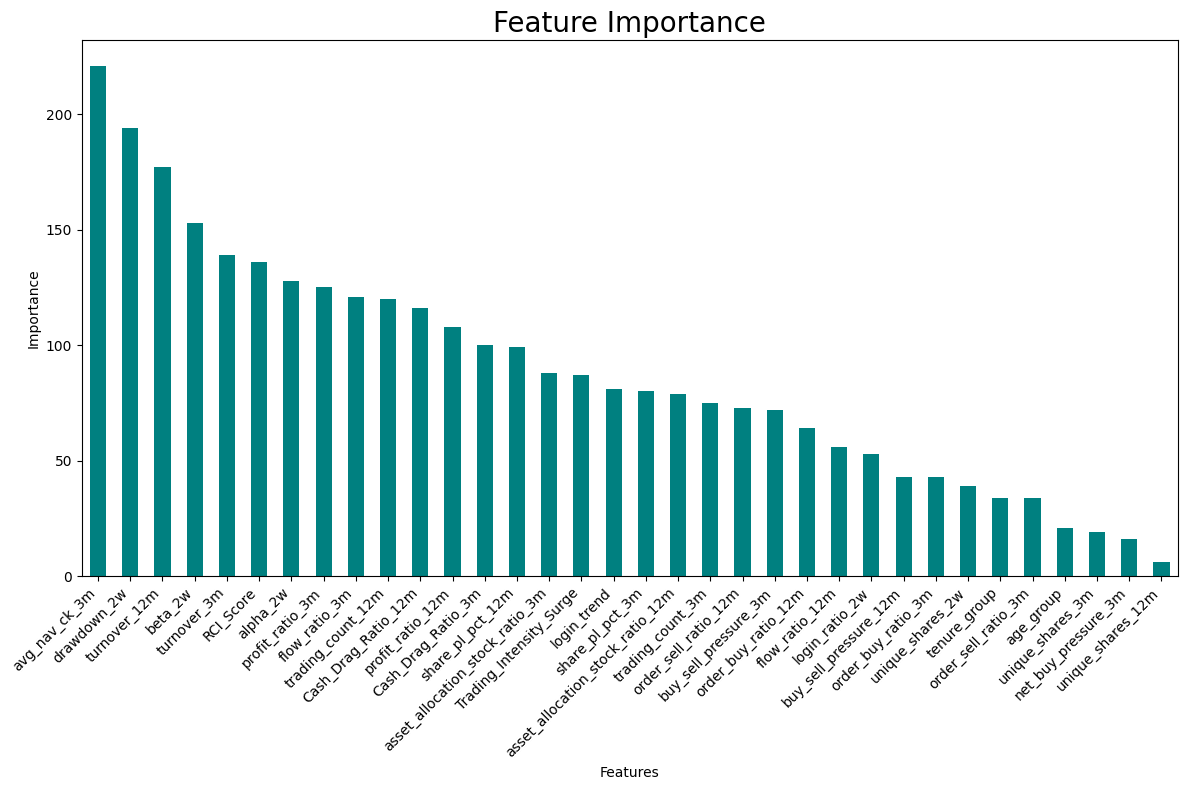


--- Feature Importance (Top 10) ---
avg_nav_ck_3m        221
drawdown_2w          194
turnover_12m         177
beta_2w              153
turnover_3m          139
RCI_Score            136
alpha_2w             128
profit_ratio_3m      125
flow_ratio_3m        121
trading_count_12m    120
dtype: int32


In [542]:
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


X = df.drop(columns="loan_label_next", axis=1, errors='ignore')
y = df['loan_label_next']




rf = LGBMClassifier(random_state=42)
rf.fit(X, y)


feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8)) # Điều chỉnh kích thước biểu đồ cho dễ nhìn
feature_importance.plot(kind='bar', color='teal')
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=10)
plt.ylabel('Importance', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=10) # Xoay nhãn trục x để dễ đọc
plt.tight_layout() # Đảm bảo tất cả nhãn đều hiển thị
plt.show()

print("\n--- Feature Importance (Top 10) ---")
print(feature_importance.head(10))

## EDA

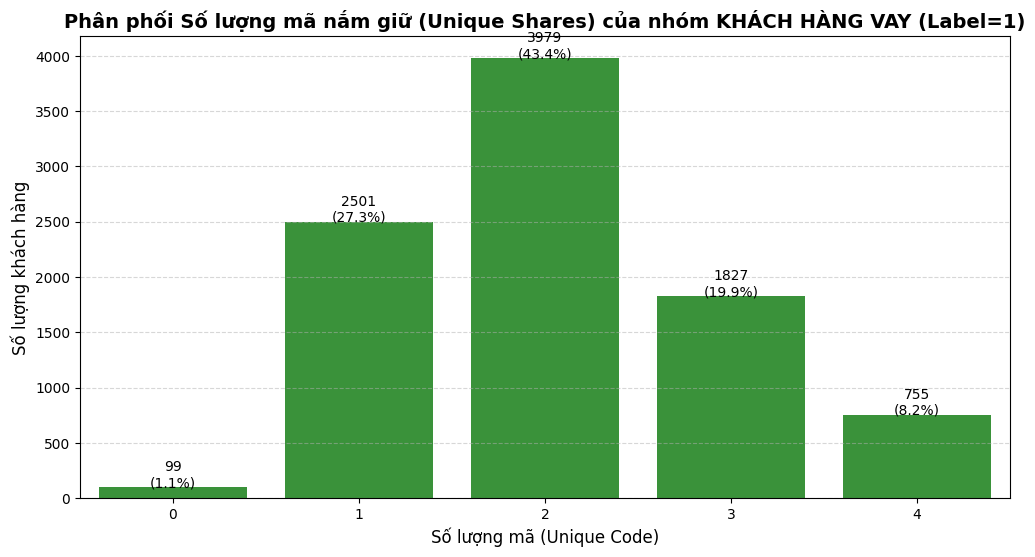

--- Thống kê Unique Code của nhóm VAY ---
count    9161.000000
mean        2.069643
std         0.916823
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: unique_shares_2w, dtype: float64


In [543]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Lọc dữ liệu: Chỉ lấy KH CÓ VAY (loan_label_next = 1)
df_borrowers = df[df['loan_label_next'] == 1].copy()

# 2. Vẽ biểu đồ đếm tần suất (Countplot)
plt.figure(figsize=(12, 6))

# Vẽ biểu đồ
ax = sns.countplot(
    data=df_borrowers, 
    x='unique_shares_2w',
    color='#2ca02c'       # Màu xanh lá (tượng trưng cho nhóm vay)
)


# Tính tổng số khách hàng vay để tính %
total_borrowers = len(df_borrowers)

for p in ax.patches:
    height = p.get_height()
    # Hiển thị số lượng + (phần trăm)
    ax.text(p.get_x() + p.get_width() / 2., height + 0.5, 
            f'{int(height)}\n({height/total_borrowers:.1%})', 
            ha="center", fontsize=10, color='black')

plt.title('Phân phối Số lượng mã nắm giữ (Unique Shares) của nhóm KHÁCH HÀNG VAY (Label=1)', fontsize=14, fontweight='bold')
plt.xlabel('Số lượng mã (Unique Code)', fontsize=12)
plt.ylabel('Số lượng khách hàng', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

# 4. In thống kê mô tả ra để bạn lấy số liệu báo cáo
print("--- Thống kê Unique Code của nhóm VAY ---")
print(df_borrowers['unique_shares_2w'].describe())

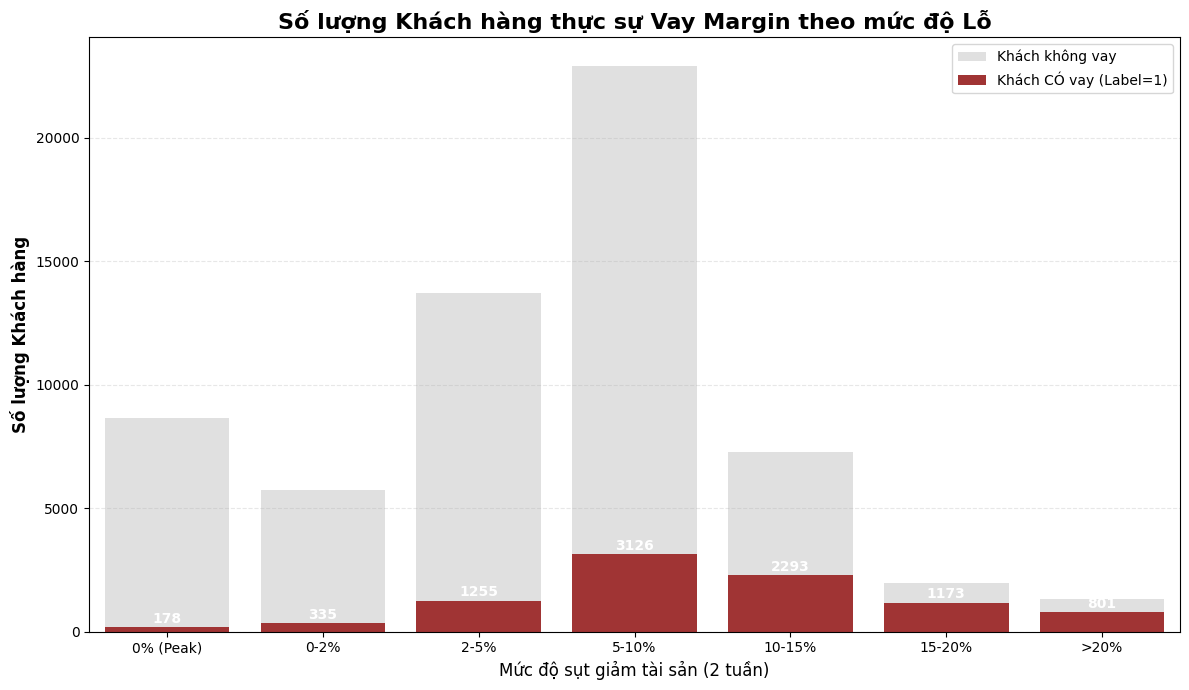

In [544]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Lấy trị tuyệt đối của drawdown
eda_df = df[['drawdown_2w', 'loan_label_next']].copy()
eda_df['dd_pct'] = eda_df['drawdown_2w'].abs() * 100 

# 2. Binning
bins = [-0.001, 0.001, 2, 5, 10, 15, 20, 100]
labels = ['0% (Peak)', '0-2%', '2-5%', '5-10%', '10-15%', '15-20%', '>20%']
eda_df['dd_group'] = pd.cut(eda_df['dd_pct'], bins=bins, labels=labels, include_lowest=True)

# Chỉ lấy những người thực sự vay (loan_label_next == 1)
borrowers_df = eda_df[eda_df['loan_label_next'] == 1]

# Đếm số lượng người vay trong từng nhóm
borrower_counts = borrowers_df.groupby('dd_group', observed=False).size().reset_index(name='borrower_count')

#  tổng số người trong nhóm đó (Total Volume)
total_counts = eda_df.groupby('dd_group', observed=False).size().reset_index(name='total_count')


merged_df = pd.merge(total_counts, borrower_counts, on='dd_group')

# 4. VẼ BIỂU ĐỒ STACKED BAR (Hiệu quả nhất)
fig, ax = plt.subplots(figsize=(12, 7))

# Vẽ cột TỔNG (Màu xám nhạt làm nền - Background)
sns.barplot(data=merged_df, x='dd_group', y='total_count', color='#e0e0e0', label='Khách không vay', ax=ax)

# Vẽ cột NGƯỜI VAY (Màu đỏ đè lên trên - Foreground)
# Đây chính là số lượng bạn đang muốn xem
sns.barplot(data=merged_df, x='dd_group', y='borrower_count', color='#b22222', label='Khách CÓ vay (Label=1)', ax=ax)

# Trang trí
ax.set_ylabel('Số lượng Khách hàng', fontsize=12, fontweight='bold')
ax.set_xlabel('Mức độ sụt giảm tài sản (2 tuần)', fontsize=12)
plt.title('Số lượng Khách hàng thực sự Vay Margin theo mức độ Lỗ', fontsize=16, fontweight='bold')
plt.legend()

# Thêm label số lượng cụ thể lên cột Đỏ
for index, row in merged_df.iterrows():
    # Ghi số lượng người vay
    ax.text(index, row['borrower_count'] + 50, f"{int(row['borrower_count'])}", 
            color='white', ha='center', va='bottom', fontweight='bold')
    
    # Ghi chú thêm tỷ lệ % ngay trên đầu cột xám (optional)
    # pct = row['borrower_count'] / row['total_count']
    # ax.text(index, row['total_count'] + 100, f"{pct:.1%}", color='gray', ha='center', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [545]:
df.alpha_2w.describe()

count    61581.000000
mean        -0.023852
std          0.064194
min         -0.961972
25%         -0.053299
50%         -0.026104
75%          0.000000
max          1.158820
Name: alpha_2w, dtype: float64

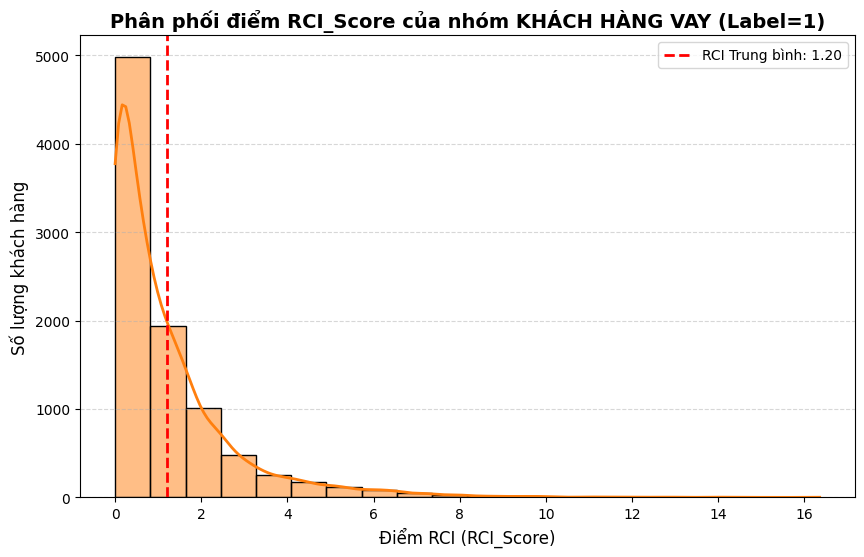

--- Thống kê RCI_Score của nhóm VAY ---
count    9161.000000
mean        1.197931
std         1.509597
min         0.000000
25%         0.199722
50%         0.699827
75%         1.615257
max        16.360705
Name: RCI_Score, dtype: float64


In [546]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Lọc dữ liệu: Chỉ lấy KH CÓ VAY (loan_label_next = 1)
df_borrowers = df[df['loan_label_next'] == 1].copy()

# 2. Vẽ biểu đồ phân phối (Histogram + KDE)
plt.figure(figsize=(10, 6))

# Histogram màu cam để khác biệt với các biểu đồ trước
sns.histplot(
    data=df_borrowers, 
    x='RCI_Score', 
    kde=True,          # Vẽ đường cong mật độ để dễ nhìn xu hướng
    bins=20,           # Chia nhỏ các khoảng điểm
    color='#ff7f0e',   # Màu cam
    line_kws={'linewidth': 2}
)

# Thêm đường trung bình để làm mốc so sánh
mean_rci = df_borrowers['RCI_Score'].mean()
plt.axvline(mean_rci, color='red', linestyle='dashed', linewidth=2, label=f'RCI Trung bình: {mean_rci:.2f}')

plt.title('Phân phối điểm RCI_Score của nhóm KHÁCH HÀNG VAY (Label=1)', fontsize=14, fontweight='bold')
plt.xlabel('Điểm RCI (RCI_Score)', fontsize=12)
plt.ylabel('Số lượng khách hàng', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

# 3. In thống kê mô tả chi tiết
print("--- Thống kê RCI_Score của nhóm VAY ---")
print(df_borrowers['RCI_Score'].describe())

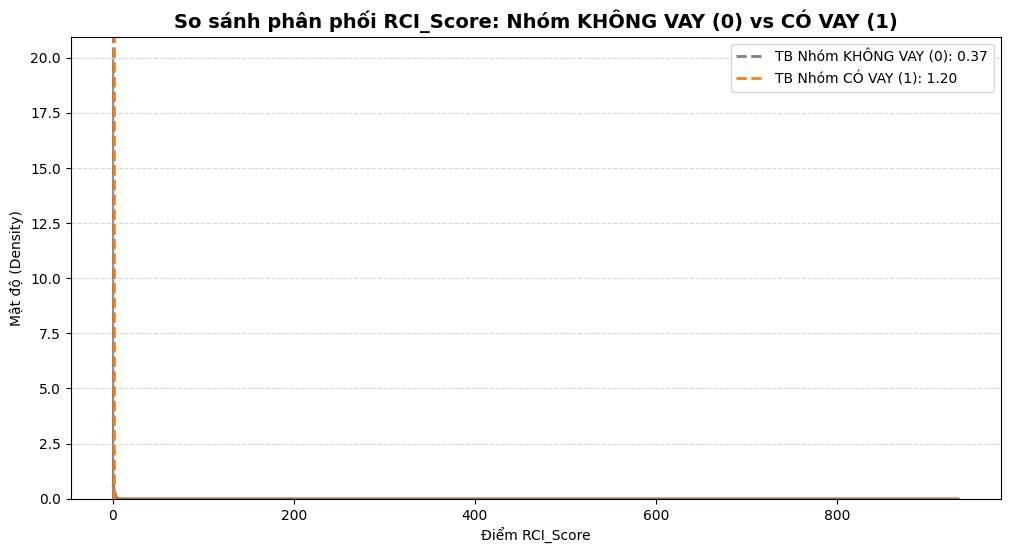

C:\Users\Admin\AppData\Local\Temp\ipykernel_10776\2780722370.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


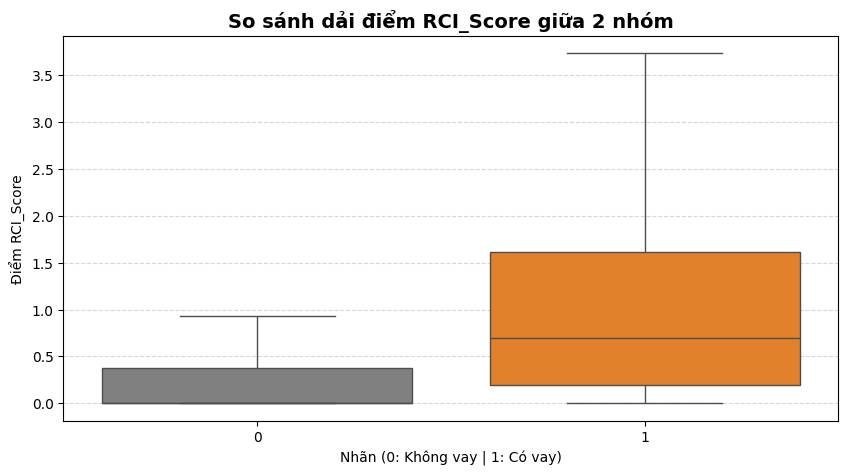


BẢNG SO SÁNH CHỈ SỐ THỐNG KÊ RCI_SCORE
                   count      mean       std  min       25%       50%  \
loan_label_next                                                         
0                52420.0  0.368194  4.188072  0.0  0.000000  0.000000   
1                 9161.0  1.197931  1.509597  0.0  0.199722  0.699827   

                      75%         max  
loan_label_next                        
0                0.372656  934.134095  
1                1.615257   16.360705  


In [547]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. CHUẨN BỊ DỮ LIỆU ---
# Lọc lấy các cột cần thiết và loại bỏ NaN
df_compare = df[['loan_label_next', 'RCI_Score']].dropna().copy()

# [FIX LỖI QUAN TRỌNG]: Ép kiểu dữ liệu về số nguyên (int) để đồng nhất
# Nếu dữ liệu đang là string '0', '1' hoặc float 0.0, 1.0 sẽ về hết int 0, 1
try:
    df_compare['loan_label_next'] = df_compare['loan_label_next'].astype(int)
except ValueError:
    # Phòng trường hợp dữ liệu lỗi không thể ép kiểu, ta in ra để kiểm tra
    print("Cảnh báo: Dữ liệu loan_label_next chứa giá trị không phải số.")
    print(df_compare['loan_label_next'].unique())

# --- 2. VẼ BIỂU ĐỒ HISTOGRAM ---
plt.figure(figsize=(12, 6))

# Định nghĩa palette bao trọn cả trường hợp số (0, 1) và chuỗi ('0', '1') để không bao giờ lỗi
safe_palette = {
    0: 'gray', 1: '#ff7f0e', 
    '0': 'gray', '1': '#ff7f0e'
}

sns.histplot(
    data=df_compare, 
    x='RCI_Score', 
    hue='loan_label_next',     
    kde=True,                  
    palette=safe_palette,      # Sử dụng palette an toàn
    stat="density",            
    common_norm=False,         
    element="step",            
    alpha=0.3                  
)

# Tính đường trung bình (chỉ tính trên dữ liệu int cho chính xác)
mean_0 = df_compare[df_compare['loan_label_next'] == 0]['RCI_Score'].mean()
mean_1 = df_compare[df_compare['loan_label_next'] == 1]['RCI_Score'].mean()

plt.axvline(mean_0, color='gray', linestyle='--', linewidth=2, label=f'TB Nhóm KHÔNG VAY (0): {mean_0:.2f}')
plt.axvline(mean_1, color='#ff7f0e', linestyle='--', linewidth=2, label=f'TB Nhóm CÓ VAY (1): {mean_1:.2f}')

plt.title('So sánh phân phối RCI_Score: Nhóm KHÔNG VAY (0) vs CÓ VAY (1)', fontsize=14, fontweight='bold')
plt.xlabel('Điểm RCI_Score')
plt.ylabel('Mật độ (Density)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# --- 3. VẼ BIỂU ĐỒ BOXPLOT ---
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_compare, 
    x='loan_label_next', 
    y='RCI_Score', 
    palette=safe_palette, # Dùng lại palette an toàn
    showfliers=False  
)

plt.title('So sánh dải điểm RCI_Score giữa 2 nhóm', fontsize=14, fontweight='bold')
plt.xlabel('Nhãn (0: Không vay | 1: Có vay)')
plt.ylabel('Điểm RCI_Score')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# --- 4. BẢNG THỐNG KÊ ---
print("\n" + "="*40)
print("BẢNG SO SÁNH CHỈ SỐ THỐNG KÊ RCI_SCORE")
print("="*40)
print(df_compare.groupby('loan_label_next')['RCI_Score'].describe())

C:\Users\Admin\AppData\Local\Temp\ipykernel_10776\3921025090.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Admin\AppData\Local\Temp\ipykernel_10776\3921025090.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


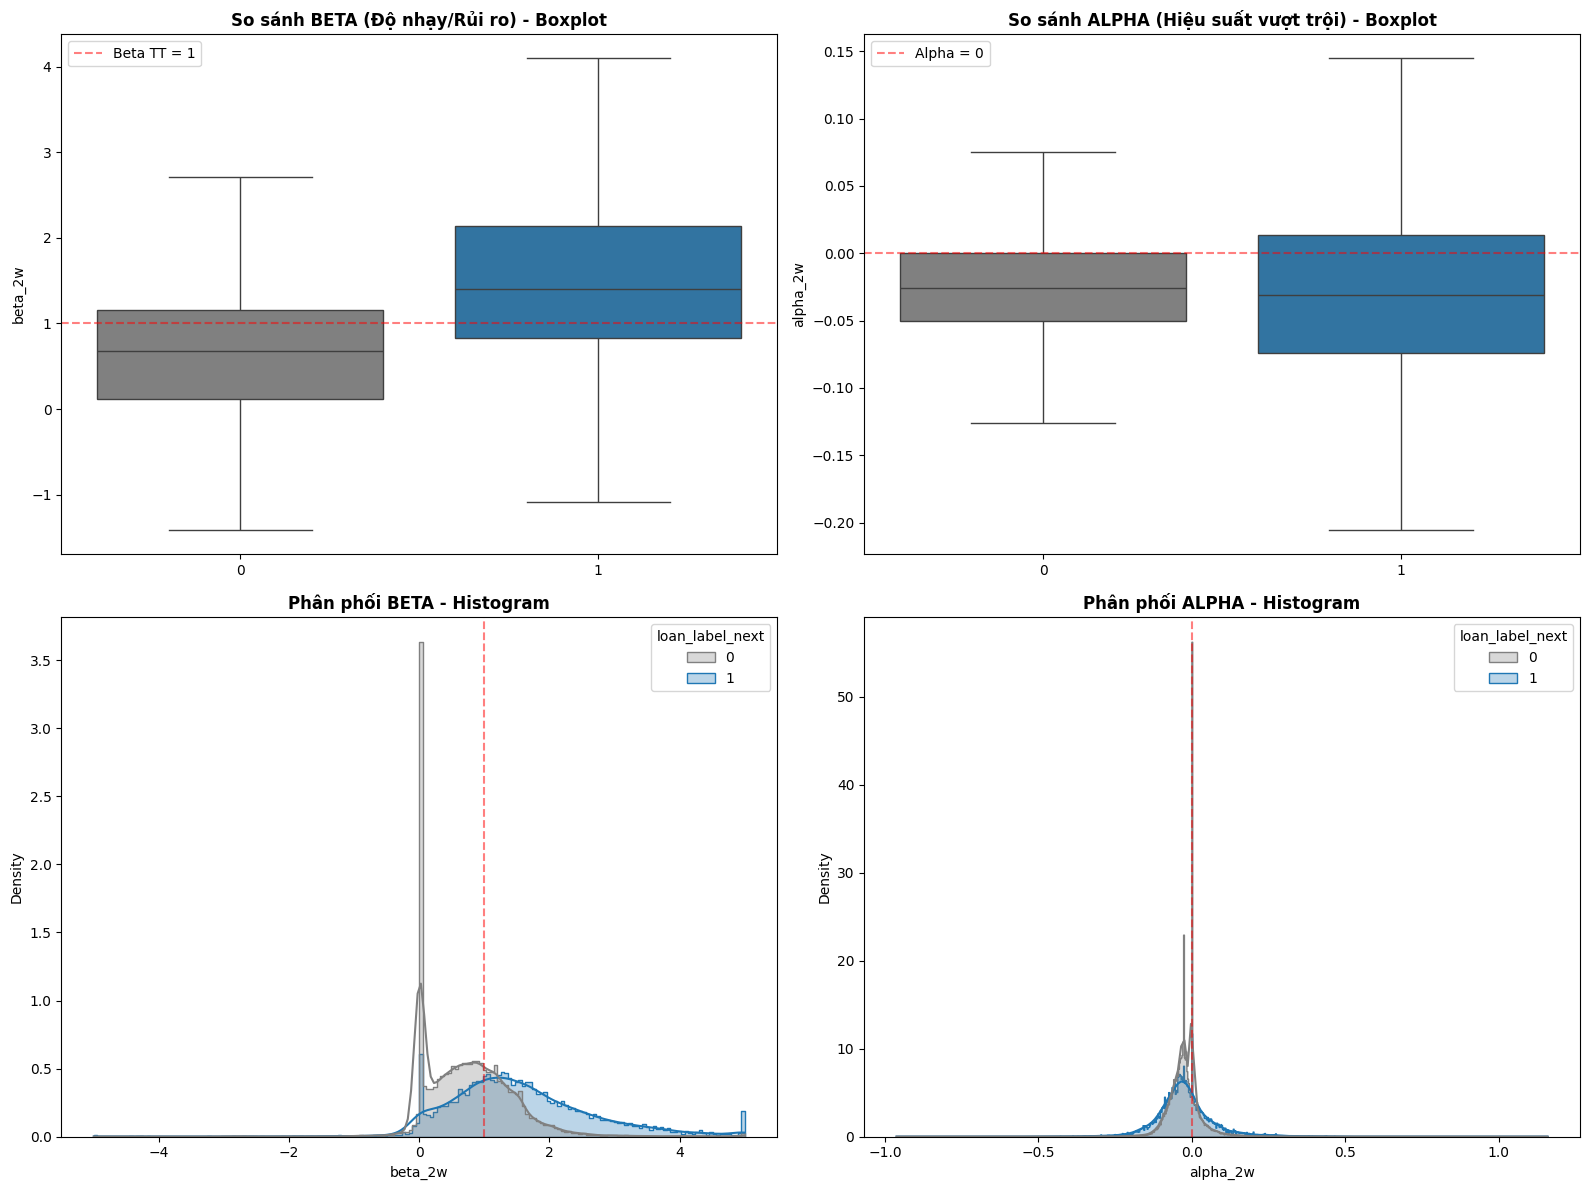

BẢNG SO SÁNH TRUNG BÌNH (MEAN) & TRUNG VỊ (MEDIAN)
loan_label_next         0         1
beta_2w  mean    0.730342  1.561219
         50%     0.675377  1.407725
alpha_2w mean   -0.023562 -0.025509
         50%    -0.025422 -0.030881


In [548]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. CHUẨN BỊ DỮ LIỆU ---
cols = ['loan_label_next', 'alpha_2w', 'beta_2w']
df_compare = df[cols].dropna().copy()

# Ép kiểu nhãn về số nguyên để tránh lỗi
try:
    df_compare['loan_label_next'] = df_compare['loan_label_next'].astype(int)
except:
    pass

# Định nghĩa màu sắc an toàn (chấp nhận cả int và str)
safe_palette = {0: 'gray', 1: '#1f77b4', '0': 'gray', '1': '#1f77b4'} # Nhóm 1 dùng màu Xanh dương

# --- 2. VẼ BIỂU ĐỒ (Lưới 2x2) ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# === CỘT 1: SO SÁNH BETA (Rủi ro) ===

# [Hàng 1, Cột 1] Boxplot Beta
sns.boxplot(
    data=df_compare, x='loan_label_next', y='beta_2w',
    palette=safe_palette, showfliers=False, ax=axes[0, 0] # Ẩn ngoại lai để dễ so sánh
)
axes[0, 0].set_title('So sánh BETA (Độ nhạy/Rủi ro) - Boxplot', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('')
axes[0, 0].axhline(1, color='red', linestyle='--', alpha=0.5, label='Beta TT = 1')
axes[0, 0].legend()

# [Hàng 2, Cột 1] Histogram Beta
sns.histplot(
    data=df_compare, x='beta_2w', hue='loan_label_next',
    palette=safe_palette, kde=True, stat="density", common_norm=False, 
    element="step", alpha=0.3, ax=axes[1, 0]
)
axes[1, 0].set_title('Phân phối BETA - Histogram', fontsize=12, fontweight='bold')
axes[1, 0].axvline(1, color='red', linestyle='--', alpha=0.5)


# === CỘT 2: SO SÁNH ALPHA (Hiệu suất) ===

# [Hàng 1, Cột 2] Boxplot Alpha
sns.boxplot(
    data=df_compare, x='loan_label_next', y='alpha_2w',
    palette=safe_palette, showfliers=False, ax=axes[0, 1]
)
axes[0, 1].set_title('So sánh ALPHA (Hiệu suất vượt trội) - Boxplot', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('')
axes[0, 1].axhline(0, color='red', linestyle='--', alpha=0.5, label='Alpha = 0')
axes[0, 1].legend()

# [Hàng 2, Cột 2] Histogram Alpha
sns.histplot(
    data=df_compare, x='alpha_2w', hue='loan_label_next',
    palette=safe_palette, kde=True, stat="density", common_norm=False,
    element="step", alpha=0.3, ax=axes[1, 1]
)
axes[1, 1].set_title('Phân phối ALPHA - Histogram', fontsize=12, fontweight='bold')
axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# --- 3. BẢNG THỐNG KÊ CHI TIẾT ---
print("="*50)
print("BẢNG SO SÁNH TRUNG BÌNH (MEAN) & TRUNG VỊ (MEDIAN)")
print("="*50)

# Gom nhóm và tính toán
summary = df_compare.groupby('loan_label_next')[['beta_2w', 'alpha_2w']].describe()

# Lọc lấy Mean và 50% (Median) để hiển thị gọn
display_cols = [('beta_2w', 'mean'), ('beta_2w', '50%'), ('alpha_2w', 'mean'), ('alpha_2w', '50%')]
print(summary[display_cols].T)

In [549]:
df.Trading_Intensity_Surge.describe()

count    61581.000000
mean         0.513206
std          0.288583
min          0.000000
25%          0.286957
50%          0.450000
75%          0.714286
max          1.000000
Name: Trading_Intensity_Surge, dtype: float64

In [550]:
df.beta_2w.describe()   

count    61581.000000
mean         0.853946
std          0.826812
min         -5.000000
25%          0.198667
50%          0.765597
75%          1.275585
max          5.000000
Name: beta_2w, dtype: float64

In [551]:
df.columns

Index(['loan_label_next', 'unique_shares_2w', 'unique_shares_3m',
       'unique_shares_12m', 'alpha_2w', 'beta_2w', 'drawdown_2w',
       'trading_count_12m', 'share_pl_pct_12m', 'avg_nav_ck_3m',
       'trading_count_3m', 'share_pl_pct_3m', 'profit_ratio_12m',
       'profit_ratio_3m', 'turnover_12m', 'turnover_3m', 'flow_ratio_12m',
       'flow_ratio_3m', 'login_ratio_2w', 'login_trend', 'RCI_Score',
       'buy_sell_pressure_3m', 'buy_sell_pressure_12m', 'order_buy_ratio_3m',
       'order_buy_ratio_12m', 'order_sell_ratio_3m', 'order_sell_ratio_12m',
       'Cash_Drag_Ratio_3m', 'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'net_buy_pressure_3m', 'age_group', 'tenure_group'],
      dtype='object')

In [552]:
df = df.drop(columns=['turnover_3m'], axis=1)

In [553]:
df = df.drop(columns=['net_buy_pressure_3m'], axis=1) 

In [554]:
# Tính toán ma trận tương quan
correlation_matrix = df.corr()
print("--- Ma trận tương quan (Correlation Matrix) ---")
print(correlation_matrix)

--- Ma trận tương quan (Correlation Matrix) ---
                                  loan_label_next  unique_shares_2w  \
loan_label_next                          1.000000          0.221328   
unique_shares_2w                         0.221328          1.000000   
unique_shares_3m                         0.300252          0.769536   
unique_shares_12m                        0.309835          0.657504   
alpha_2w                                -0.010795         -0.054679   
beta_2w                                  0.357607          0.315592   
drawdown_2w                             -0.295613         -0.216399   
trading_count_12m                        0.384998          0.415986   
share_pl_pct_12m                         0.009595          0.002320   
avg_nav_ck_3m                            0.030911          0.007267   
trading_count_3m                         0.415971          0.525869   
share_pl_pct_3m                          0.004718          0.020245   
profit_ratio_12m             

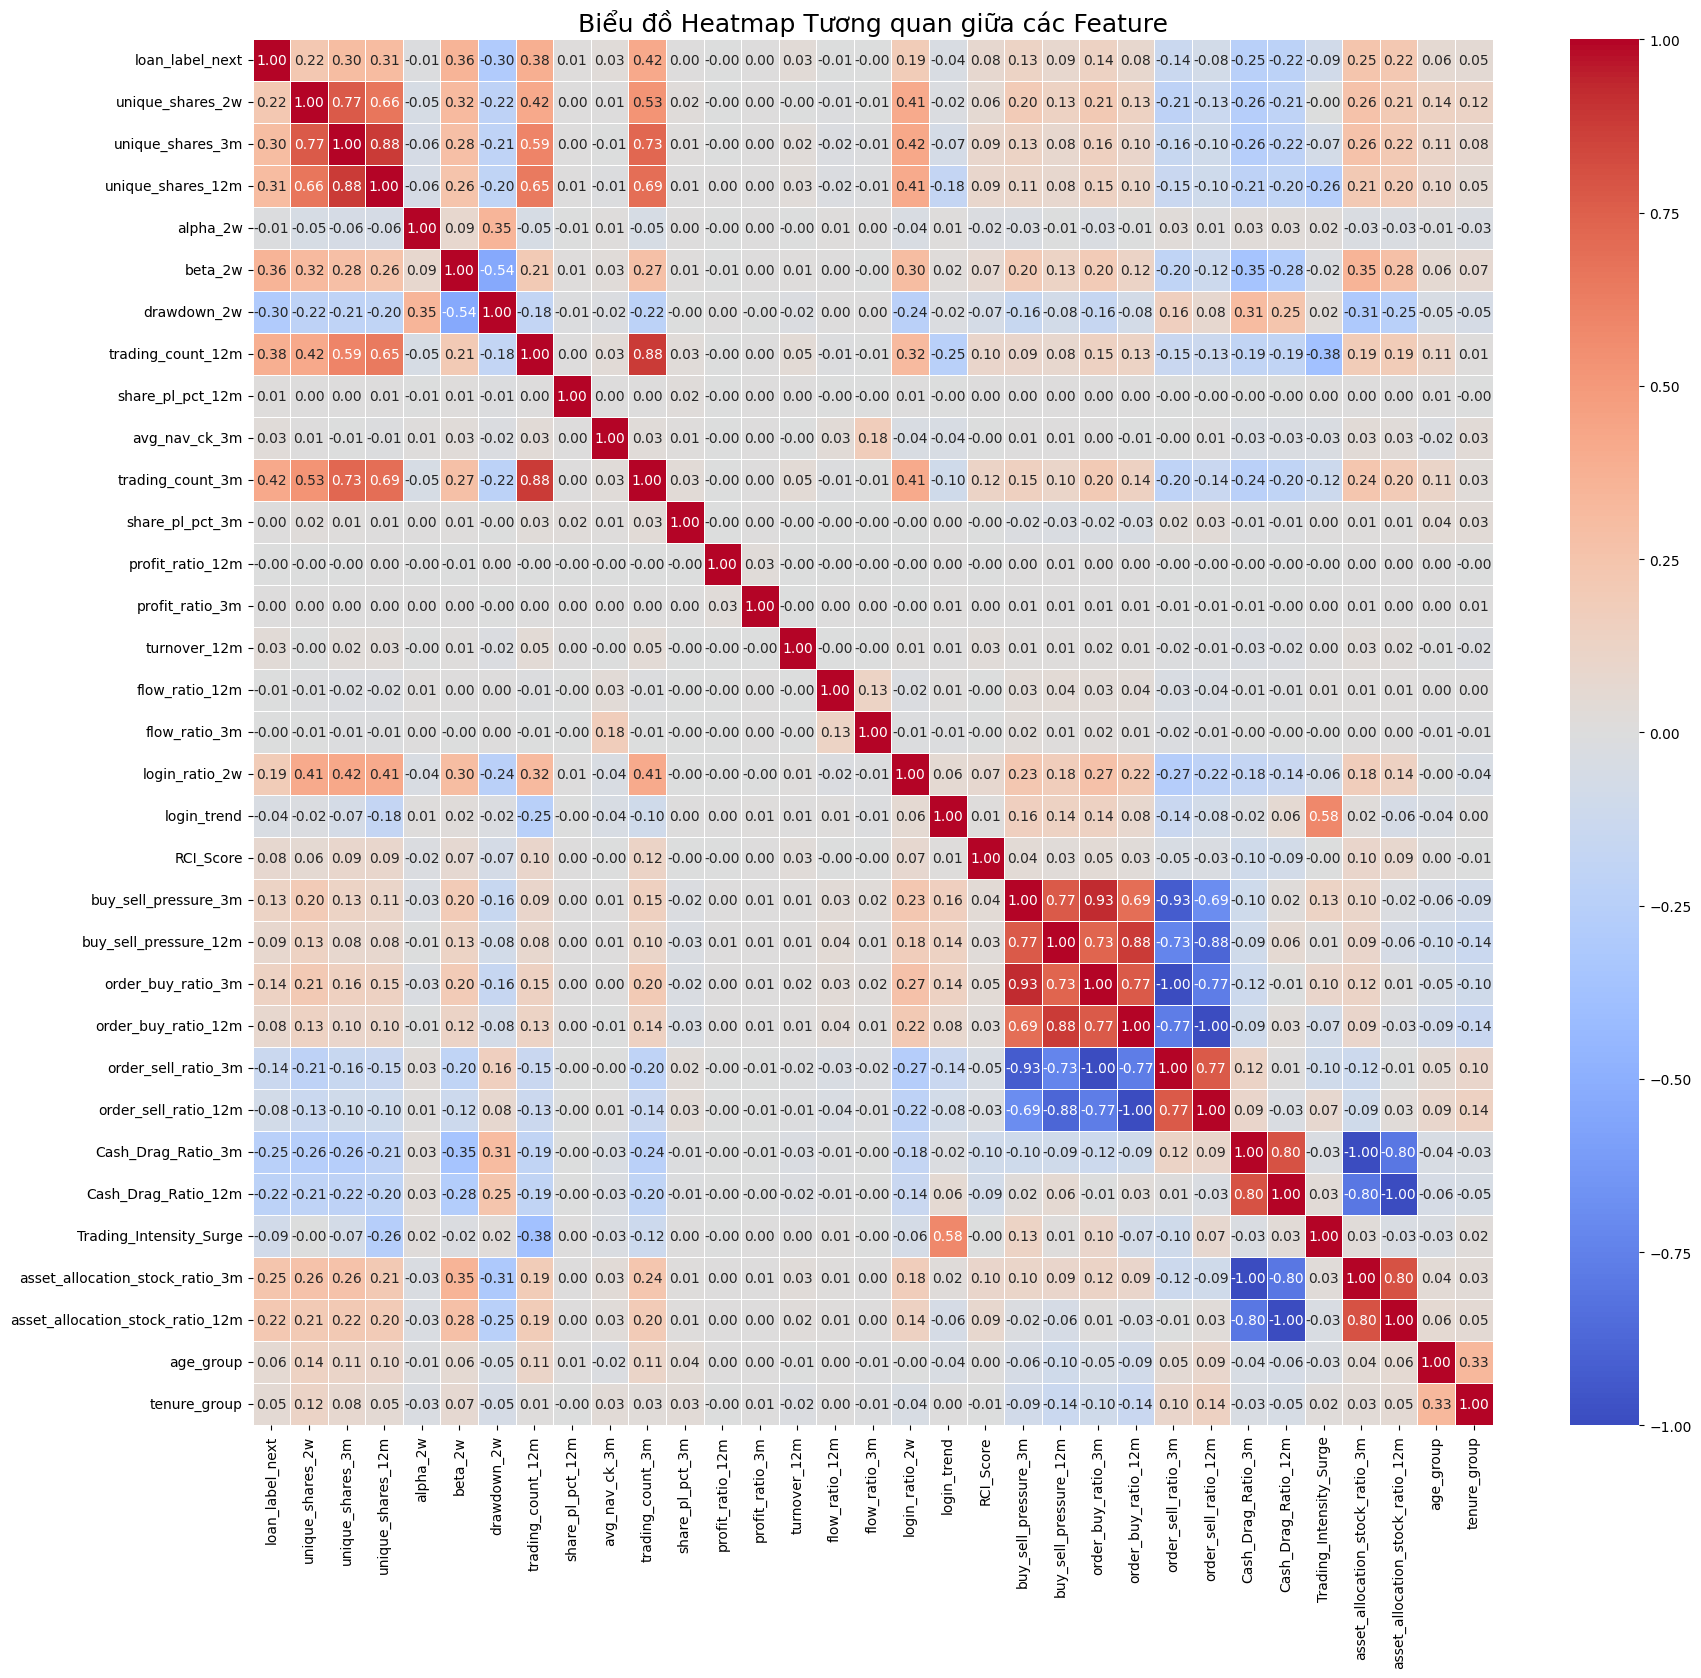

In [555]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cấu hình kích thước biểu đồ
plt.figure(figsize=(20, 18))

# Tạo Heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,              # Hiển thị giá trị tương quan trên ô
    fmt=".2f",               # Định dạng số thập phân 2 chữ số
    cmap='coolwarm',         # Sử dụng bảng màu coolwarm (đỏ/xanh)
    linewidths=.5,           # Độ dày đường kẻ giữa các ô
    cbar=True                # Hiển thị thanh màu
)

# Đặt tiêu đề và điều chỉnh
plt.title('Biểu đồ Heatmap Tương quan giữa các Feature', fontsize=18)
plt.show()

In [556]:
import pandas as pd
import numpy as np

def get_redundant_pairs(corr_matrix, threshold=0.95):
    """
    Hàm trả về DataFrame các cặp biến có độ tương quan cao hơn ngưỡng (threshold).
    Xử lý cả tương quan dương (> 0.95) và âm (< -0.95).
    """
    # 1. Lấy tam giác trên của ma trận tương quan (để tránh trùng lặp A-B và B-A)
    # k=1 để loại bỏ đường chéo chính (tương quan với chính nó luôn là 1)
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # 2. Chuyển ma trận thành dạng cột (Stacking) để dễ lọc
    stacked_corr = upper_tri.stack()

    # 3. Lọc các giá trị có độ lớn (abs) > threshold
    # Dùng abs() vì tương quan -0.99 cũng gây hại như 0.99 (nghịch biến hoàn hảo)
    high_corr_pairs = stacked_corr[abs(stacked_corr) > threshold]

    # 4. Trình bày đẹp
    result_df = pd.DataFrame(high_corr_pairs, columns=['Correlation_Coefficient'])
    result_df.index.names = ['Feature_1', 'Feature_2']
    
    # Sắp xếp giảm dần theo độ lớn tương quan
    return result_df.sort_values(by='Correlation_Coefficient', ascending=False)

# --- THỰC THI ---

# Giả sử bạn đã có correlation_matrix từ bước trước
# Nếu chưa: correlation_matrix = df_final.corr()

high_corr_df = get_redundant_pairs(correlation_matrix, threshold=0.95)

print(f"Tổng số cặp biến có tương quan > 0.95: {len(high_corr_df)}")
print("-" * 50)
print(high_corr_df)

# --- GỢI Ý DROP TỰ ĐỘNG (OPTIONAL) ---
# Lấy danh sách các biến cần drop (lấy biến thứ 2 trong cặp để drop)
to_drop = [pair[1] for pair in high_corr_df.index]
unique_to_drop = list(set(to_drop))
print(f"\nDanh sách gợi ý các biến nên xóa (Biến thứ 2 trong cặp): \n{unique_to_drop}")

Tổng số cặp biến có tương quan > 0.95: 4
--------------------------------------------------
                                                      Correlation_Coefficient
Feature_1           Feature_2                                                
order_buy_ratio_3m  order_sell_ratio_3m                                  -1.0
order_buy_ratio_12m order_sell_ratio_12m                                 -1.0
Cash_Drag_Ratio_12m asset_allocation_stock_ratio_12m                     -1.0
Cash_Drag_Ratio_3m  asset_allocation_stock_ratio_3m                      -1.0

Danh sách gợi ý các biến nên xóa (Biến thứ 2 trong cặp): 
['order_sell_ratio_12m', 'order_sell_ratio_3m', 'asset_allocation_stock_ratio_12m', 'asset_allocation_stock_ratio_3m']


In [557]:
df.columns

Index(['loan_label_next', 'unique_shares_2w', 'unique_shares_3m',
       'unique_shares_12m', 'alpha_2w', 'beta_2w', 'drawdown_2w',
       'trading_count_12m', 'share_pl_pct_12m', 'avg_nav_ck_3m',
       'trading_count_3m', 'share_pl_pct_3m', 'profit_ratio_12m',
       'profit_ratio_3m', 'turnover_12m', 'flow_ratio_12m', 'flow_ratio_3m',
       'login_ratio_2w', 'login_trend', 'RCI_Score', 'buy_sell_pressure_3m',
       'buy_sell_pressure_12m', 'order_buy_ratio_3m', 'order_buy_ratio_12m',
       'order_sell_ratio_3m', 'order_sell_ratio_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'age_group', 'tenure_group'],
      dtype='object')

##### Handel outlier and transform 

In [558]:
#df = df.drop(columns=['trading_count_3m', 'trading_count_12m'], axis=1)

In [559]:
df.columns

Index(['loan_label_next', 'unique_shares_2w', 'unique_shares_3m',
       'unique_shares_12m', 'alpha_2w', 'beta_2w', 'drawdown_2w',
       'trading_count_12m', 'share_pl_pct_12m', 'avg_nav_ck_3m',
       'trading_count_3m', 'share_pl_pct_3m', 'profit_ratio_12m',
       'profit_ratio_3m', 'turnover_12m', 'flow_ratio_12m', 'flow_ratio_3m',
       'login_ratio_2w', 'login_trend', 'RCI_Score', 'buy_sell_pressure_3m',
       'buy_sell_pressure_12m', 'order_buy_ratio_3m', 'order_buy_ratio_12m',
       'order_sell_ratio_3m', 'order_sell_ratio_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'age_group', 'tenure_group'],
      dtype='object')

In [560]:
df = df.drop(columns=[ 'unique_shares_2w','login_ratio_2w',])

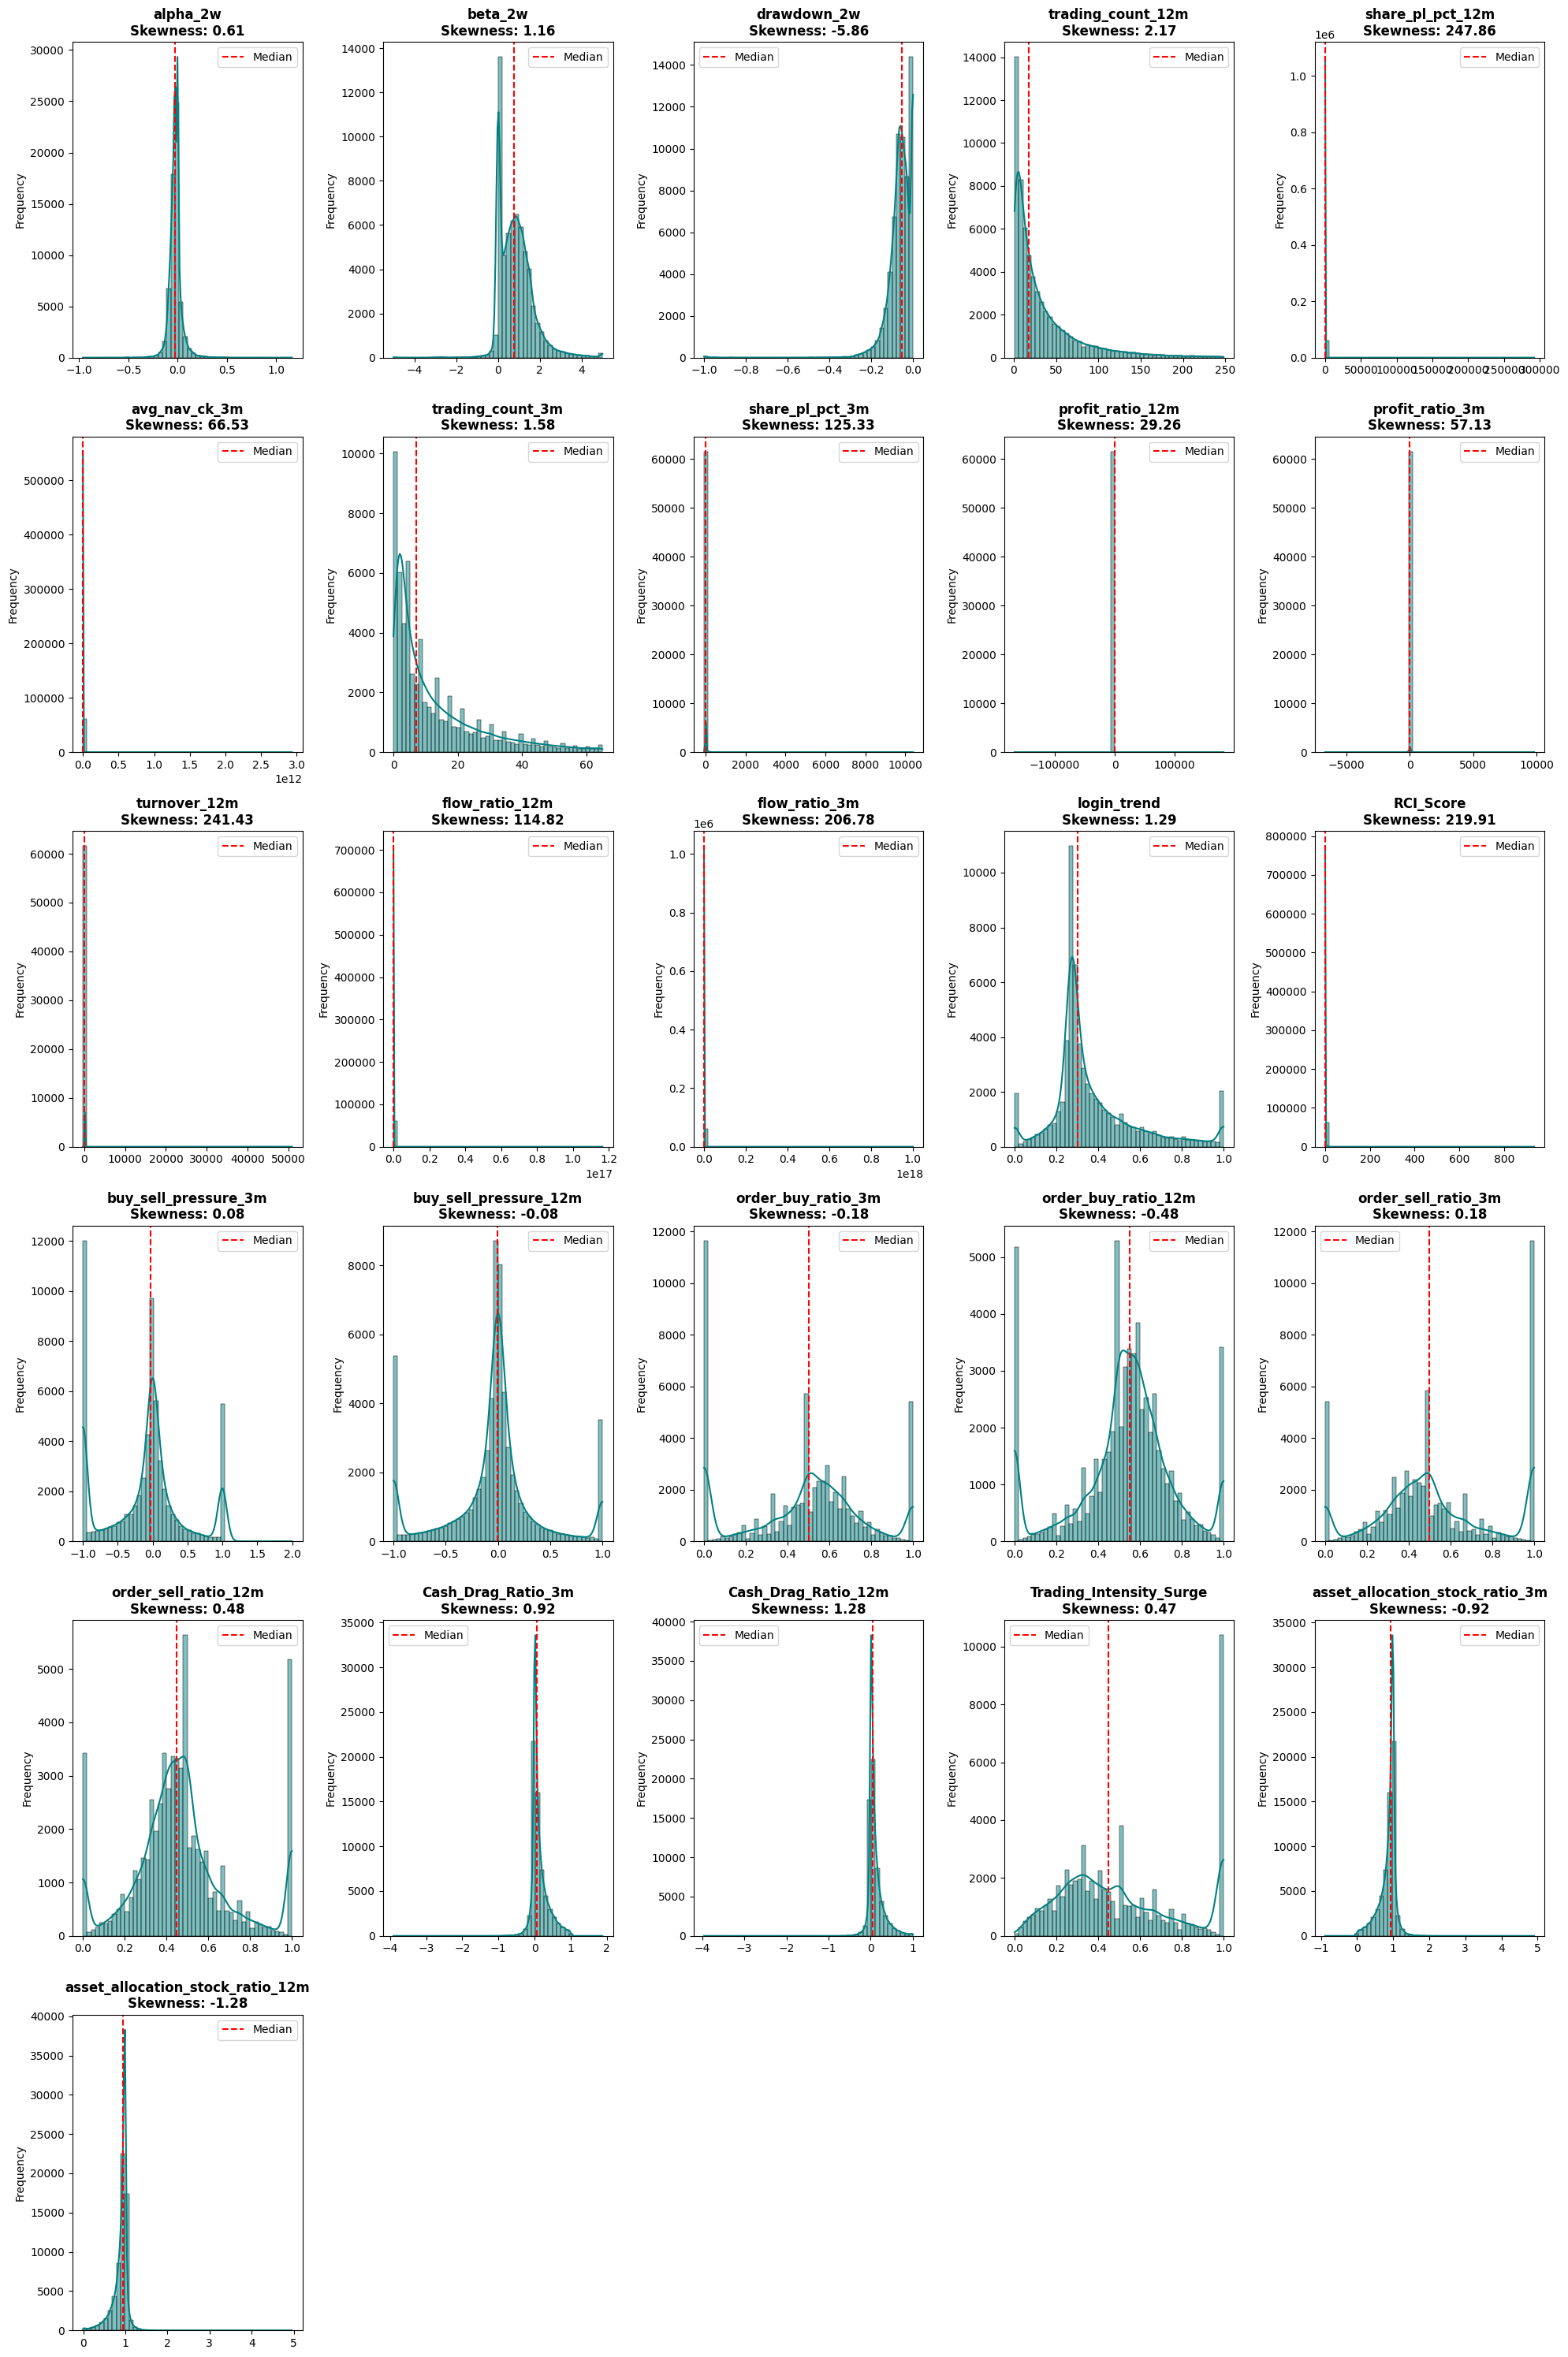

In [561]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def check_money_distribution(df, cols_to_check):
    """
    Vẽ biểu đồ phân phối và tính độ lệch (Skewness)
    """
    # Lọc các cột thực sự tồn tại trong df
    valid_cols = [c for c in cols_to_check if c in df.columns]
    
    n_cols = 5
    n_rows = (len(valid_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(20, 5 * n_rows))
    
    for i, col in enumerate(valid_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # 1. Vẽ Histogram và đường KDE (Kernel Density Estimate)
        sns.histplot(df[col], kde=True, color='teal', bins=50)
        
        # 2. Tính chỉ số Skewness (Độ lệch)
        # Skewness = 0: Chuẩn tuyệt đối
        # Skewness > 0: Lệch phải (đuôi dài bên phải)
        # Skewness < 0: Lệch trái (đuôi dài bên trái)
        skew_val = df[col].skew()
        
        # 3. Trang trí
        plt.title(f'{col}\nSkewness: {skew_val:.2f}', fontsize=12, fontweight='bold')
        plt.xlabel('')
        plt.ylabel('Frequency')
        
        # Thêm đường kẻ dọc tại trung vị (Median)
        plt.axvline(df[col].median(), color='red', linestyle='--', label='Median')
        plt.legend()

    plt.tight_layout()
    plt.show()

# --- DANH SÁCH CÁC TRƯỜNG TIỀN TỆ CẦN KIỂM TRA ---
# Đây là danh sách các biến bạn vừa Log/Yeo-Johnson
money_cols_to_check = [
    # Nhóm Log1p
       'alpha_2w', 'beta_2w', 'drawdown_2w',
       'trading_count_12m', 'share_pl_pct_12m', 'avg_nav_ck_3m',
       'trading_count_3m', 'share_pl_pct_3m', 'profit_ratio_12m',
       'profit_ratio_3m', 'turnover_12m', 'flow_ratio_12m', 'flow_ratio_3m',
       'login_ratio_2w', 'login_trend', 'RCI_Score', 'buy_sell_pressure_3m',
       'buy_sell_pressure_12m', 'order_buy_ratio_3m', 'order_buy_ratio_12m',
       'order_sell_ratio_3m', 'order_sell_ratio_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m'
]

# --- THỰC THI ---
# df_clean của bạn lúc này đã là df_ready_for_scale (đã transform)
check_money_distribution(df, money_cols_to_check)

In [562]:
df.columns

Index(['loan_label_next', 'unique_shares_3m', 'unique_shares_12m', 'alpha_2w',
       'beta_2w', 'drawdown_2w', 'trading_count_12m', 'share_pl_pct_12m',
       'avg_nav_ck_3m', 'trading_count_3m', 'share_pl_pct_3m',
       'profit_ratio_12m', 'profit_ratio_3m', 'turnover_12m', 'flow_ratio_12m',
       'flow_ratio_3m', 'login_trend', 'RCI_Score', 'buy_sell_pressure_3m',
       'buy_sell_pressure_12m', 'order_buy_ratio_3m', 'order_buy_ratio_12m',
       'order_sell_ratio_3m', 'order_sell_ratio_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'age_group', 'tenure_group'],
      dtype='object')

In [563]:
import pandas as pd
import numpy as np

# 1. Nhóm các biến chỉ có giá trị dương (Cần chặn trên 99%)
pos_cols = [
        'turnover_12m', 'flow_ratio_12m',
       'flow_ratio_3m','order_buy_ratio_3m', 'order_buy_ratio_12m', 'order_sell_ratio_3m', 'order_sell_ratio_12m',
        'Trading_Intensity_Surge', 'login_trend', 'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m', 'trading_count_12m',
       'trading_count_3m', "RCI_Score",
]

# 2. Nhóm các biến có giá trị âm (Cần chặn cả 2 đầu: 1% và 99%)
# Đặc biệt quan trọng cho Beta, Alpha, Profit, Net Flow
two_way_cols = [
    'profit_ratio_3m',
    'cash_flow_3m', 'cash_flow_12m', 
    'buy_sell_pressure_3m', 'buy_sell_pressure_12m',
    'order_buy_sell_pressure_3m', 'beta_2w', 'alpha_2w', 'drawdown_2w', 'Cash_Drag_Ratio_3m', 'Cash_Drag_Ratio_12m',
]

def handle_outliers(df):
    df_capped = df.copy()
    
    # Xử lý nhóm chặn trên 0.99
    for col in pos_cols:
        if col in df_capped.columns:
            upper_limit = df_capped[col].quantile(0.99)
            df_capped[col] = df_capped[col].clip(upper=upper_limit)
            
    # Xử lý nhóm chặn 2 đầu (0.01 và 0.99)
    for col in two_way_cols:
        if col in df_capped.columns:
            lower_limit = df_capped[col].quantile(0.01)
            upper_limit = df_capped[col].quantile(0.99)
            df_capped[col] = df_capped[col].clip(lower=lower_limit, upper=upper_limit)
            
    return df_capped

# Áp dụng
df = handle_outliers(df)

In [564]:
df.loan_label_next.value_counts()

loan_label_next
0    52420
1     9161
Name: count, dtype: int64

In [565]:
df.columns

Index(['loan_label_next', 'unique_shares_3m', 'unique_shares_12m', 'alpha_2w',
       'beta_2w', 'drawdown_2w', 'trading_count_12m', 'share_pl_pct_12m',
       'avg_nav_ck_3m', 'trading_count_3m', 'share_pl_pct_3m',
       'profit_ratio_12m', 'profit_ratio_3m', 'turnover_12m', 'flow_ratio_12m',
       'flow_ratio_3m', 'login_trend', 'RCI_Score', 'buy_sell_pressure_3m',
       'buy_sell_pressure_12m', 'order_buy_ratio_3m', 'order_buy_ratio_12m',
       'order_sell_ratio_3m', 'order_sell_ratio_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'age_group', 'tenure_group'],
      dtype='object')

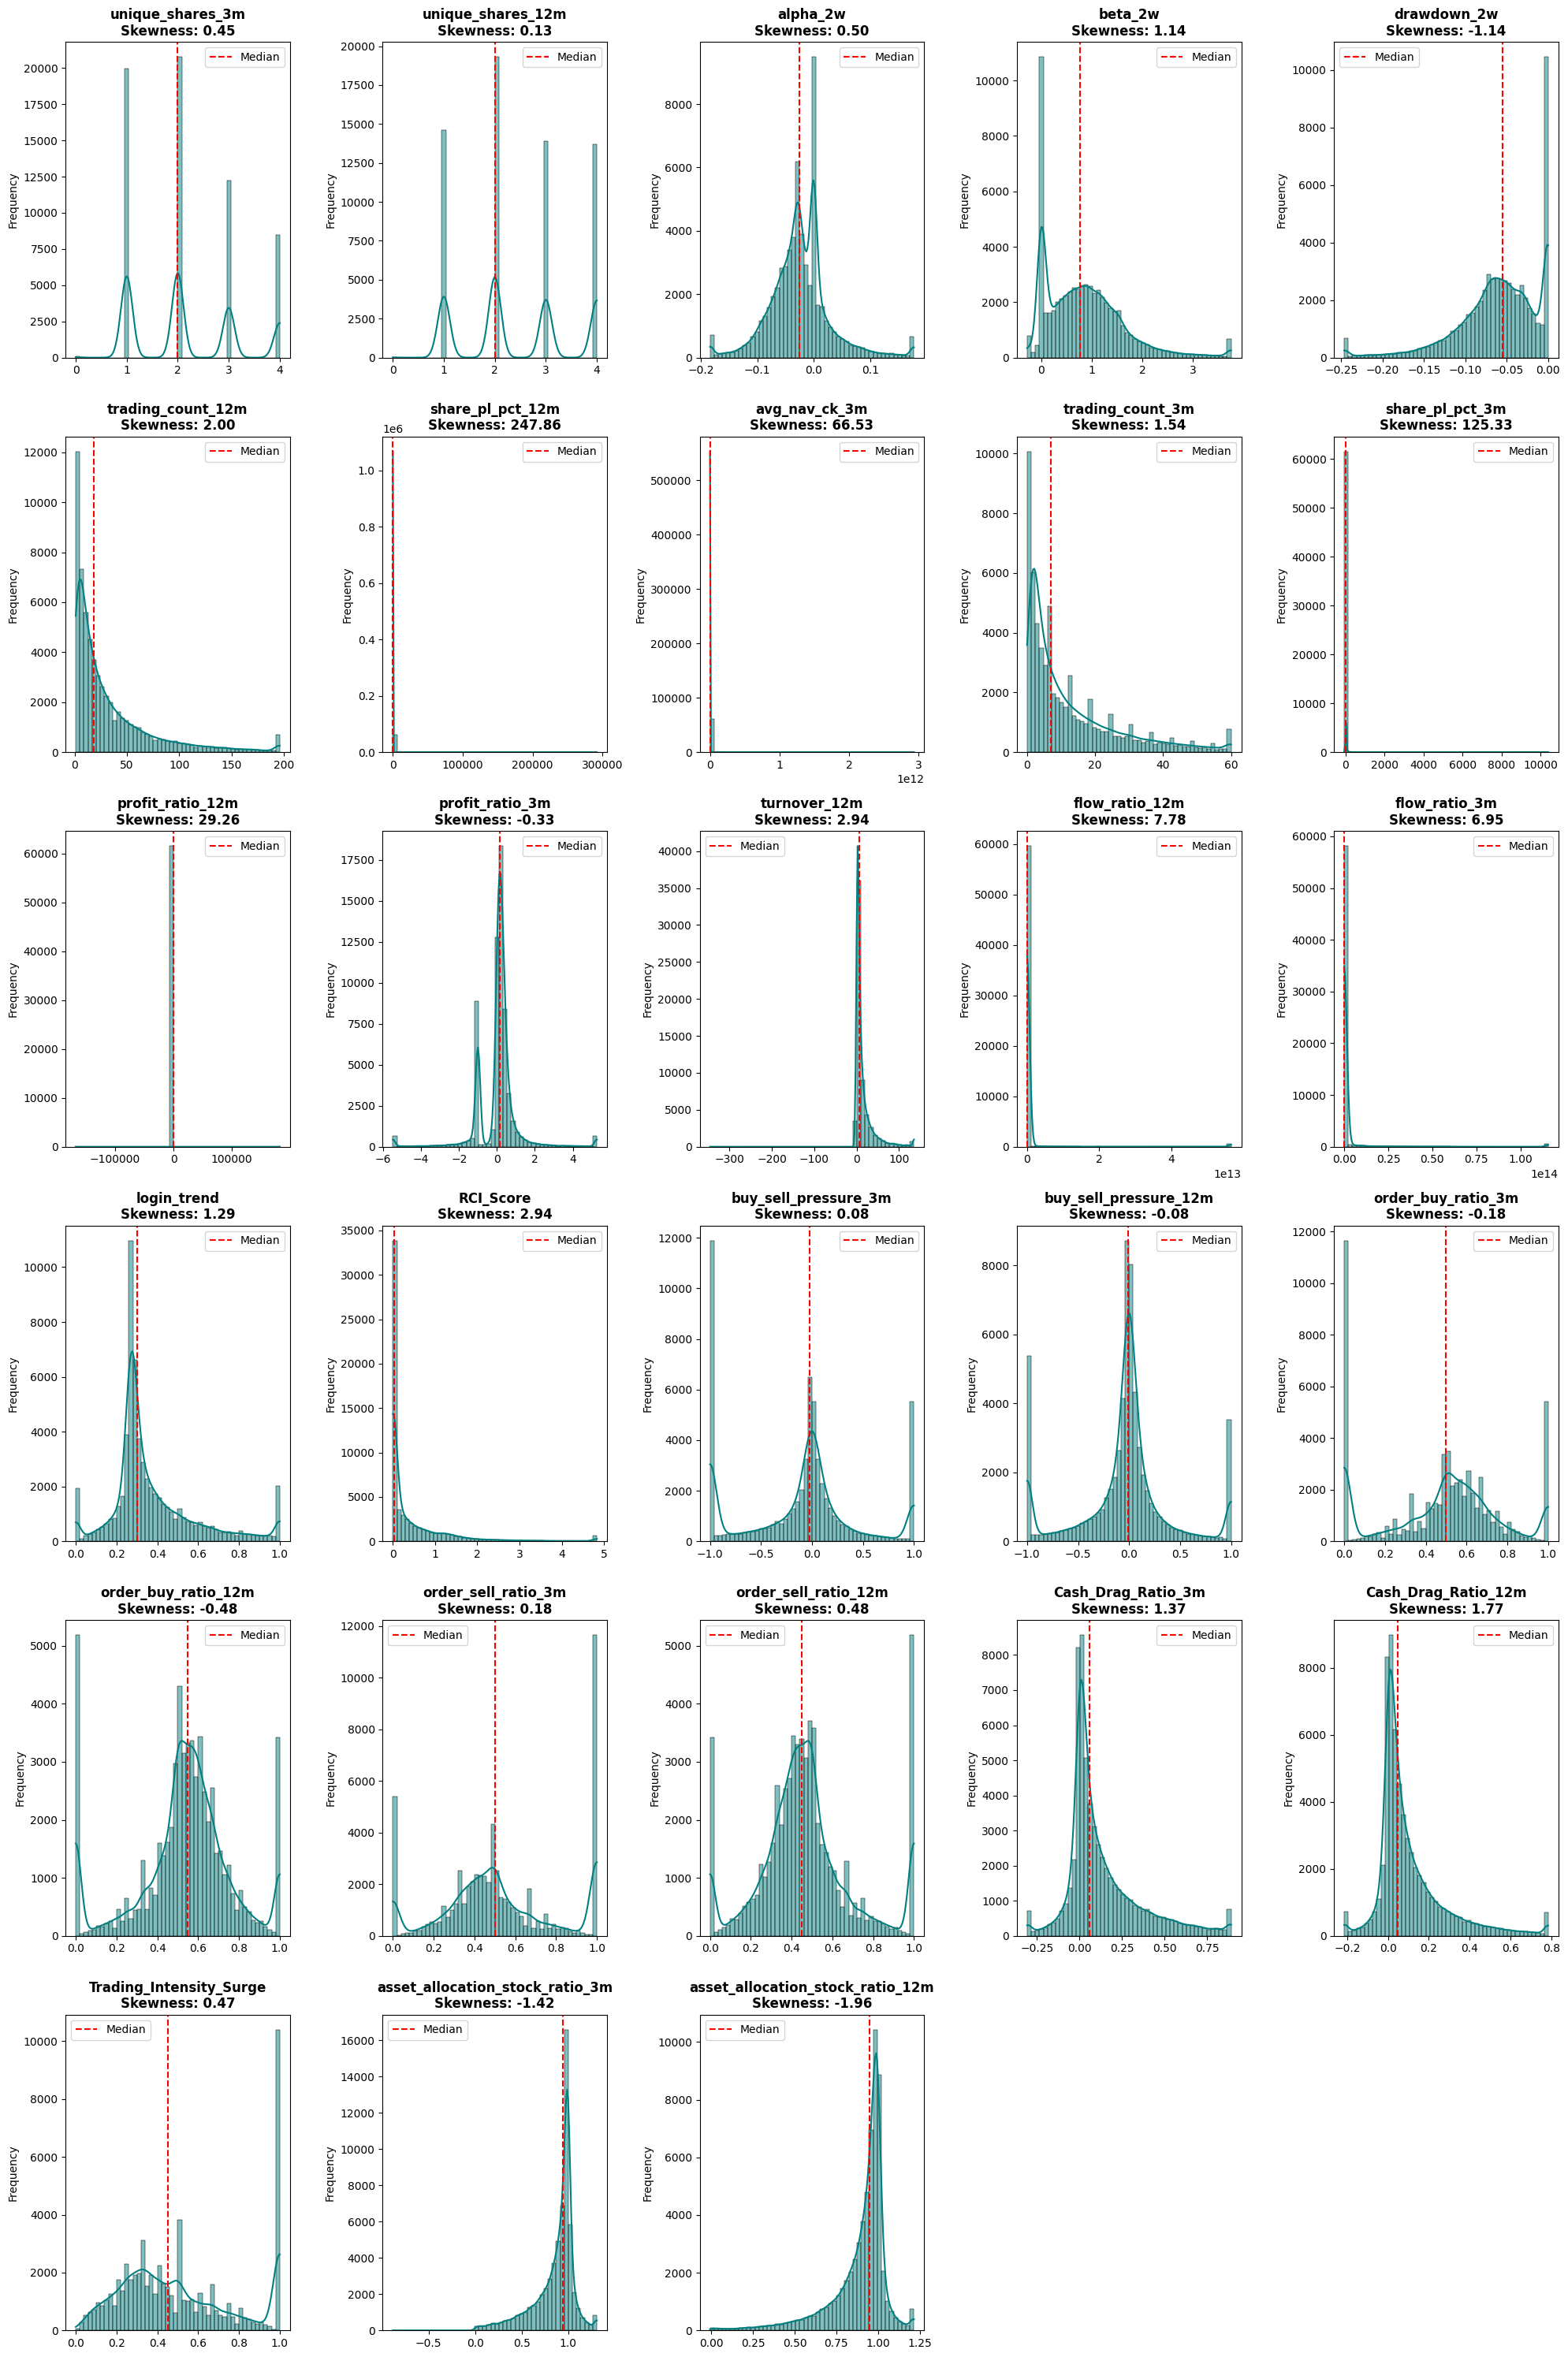

In [566]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def check_money_distribution(df, cols_to_check):
    """
    Vẽ biểu đồ phân phối và tính độ lệch (Skewness)
    """

    valid_cols = [c for c in cols_to_check if c in df.columns]
    
    n_cols = 5
    n_rows = (len(valid_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(20, 5 * n_rows))
    
    for i, col in enumerate(valid_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # 1. Vẽ Histogram và đường KDE (Kernel Density Estimate)
        sns.histplot(df[col], kde=True, color='teal', bins=50)
        

        skew_val = df[col].skew()
        
        # 3. Trang trí
        plt.title(f'{col}\nSkewness: {skew_val:.2f}', fontsize=12, fontweight='bold')
        plt.xlabel('')
        plt.ylabel('Frequency')
        
        # Thêm đường kẻ dọc tại trung vị (Median)
        plt.axvline(df[col].median(), color='red', linestyle='--', label='Median')
        plt.legend()

    plt.tight_layout()
    plt.show()

# --- DANH SÁCH CÁC TRƯỜNG TIỀN TỆ CẦN KIỂM TRA ---

money_cols_to_check = [
    # Nhóm Log1p
       'unique_shares_3m', 'unique_shares_12m', 'alpha_2w',
       'beta_2w', 'drawdown_2w', 'trading_count_12m', 'share_pl_pct_12m',
       'avg_nav_ck_3m', 'trading_count_3m', 'share_pl_pct_3m',
       'profit_ratio_12m', 'profit_ratio_3m', 'turnover_12m', 'flow_ratio_12m',
       'flow_ratio_3m', 'login_trend', 'RCI_Score', 'buy_sell_pressure_3m',
       'buy_sell_pressure_12m', 'order_buy_ratio_3m', 'order_buy_ratio_12m',
       'order_sell_ratio_3m', 'order_sell_ratio_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'order_buy_sell_pressure_3m',
]

check_money_distribution(df, money_cols_to_check)

In [567]:
df.isnull().sum()

loan_label_next                     0
unique_shares_3m                    0
unique_shares_12m                   0
alpha_2w                            0
beta_2w                             0
drawdown_2w                         0
trading_count_12m                   0
share_pl_pct_12m                    0
avg_nav_ck_3m                       0
trading_count_3m                    0
share_pl_pct_3m                     0
profit_ratio_12m                    0
profit_ratio_3m                     0
turnover_12m                        0
flow_ratio_12m                      0
flow_ratio_3m                       0
login_trend                         0
RCI_Score                           0
buy_sell_pressure_3m                0
buy_sell_pressure_12m               0
order_buy_ratio_3m                  0
order_buy_ratio_12m                 0
order_sell_ratio_3m                 0
order_sell_ratio_12m                0
Cash_Drag_Ratio_3m                  0
Cash_Drag_Ratio_12m                 0
Trading_Inte

In [568]:
# Thay thế inf bằng NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)


# Sau đó xử lý NaN — ví dụ: thay bằng 0, hoặc dùng fillna(method='ffill'), hoặc drop
df.fillna(0, inplace=True) 


[LightGBM] [Info] Number of positive: 9161, number of negative: 52420
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6396
[LightGBM] [Info] Number of data points in the train set: 61581, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148763 -> initscore=-1.744333
[LightGBM] [Info] Start training from score -1.744333


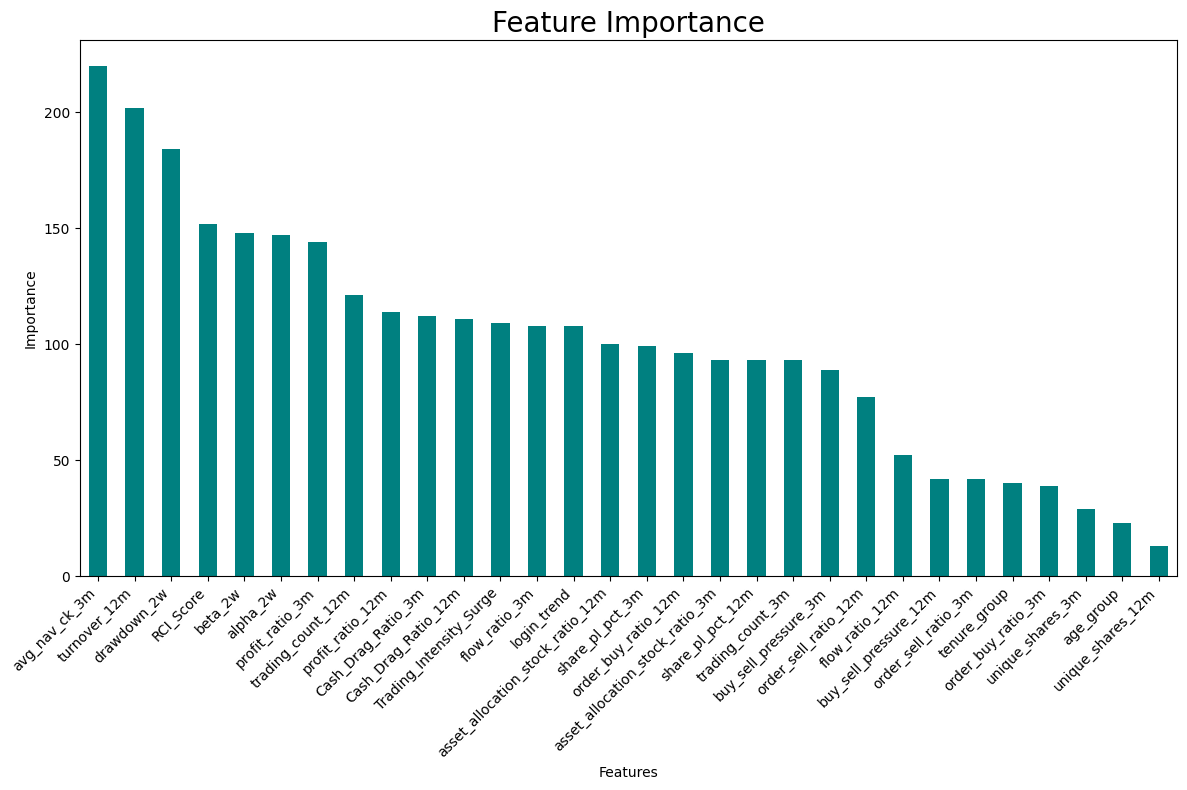


--- Feature Importance (Top 10) ---
avg_nav_ck_3m         220
turnover_12m          202
drawdown_2w           184
RCI_Score             152
beta_2w               148
alpha_2w              147
profit_ratio_3m       144
trading_count_12m     121
profit_ratio_12m      114
Cash_Drag_Ratio_3m    112
dtype: int32


In [569]:
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier



X = df.drop(columns="loan_label_next", axis=1, errors='ignore')
y = df['loan_label_next']




rf = LGBMClassifier(random_state=42)
rf.fit(X, y)


feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8)) # Điều chỉnh kích thước biểu đồ cho dễ nhìn
feature_importance.plot(kind='bar', color='teal')
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=10)
plt.ylabel('Importance', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=10) # Xoay nhãn trục x để dễ đọc
plt.tight_layout() # Đảm bảo tất cả nhãn đều hiển thị
plt.show()

print("\n--- Feature Importance (Top 10) ---")
print(feature_importance.head(10))

In [570]:
df.columns

Index(['loan_label_next', 'unique_shares_3m', 'unique_shares_12m', 'alpha_2w',
       'beta_2w', 'drawdown_2w', 'trading_count_12m', 'share_pl_pct_12m',
       'avg_nav_ck_3m', 'trading_count_3m', 'share_pl_pct_3m',
       'profit_ratio_12m', 'profit_ratio_3m', 'turnover_12m', 'flow_ratio_12m',
       'flow_ratio_3m', 'login_trend', 'RCI_Score', 'buy_sell_pressure_3m',
       'buy_sell_pressure_12m', 'order_buy_ratio_3m', 'order_buy_ratio_12m',
       'order_sell_ratio_3m', 'order_sell_ratio_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'age_group', 'tenure_group'],
      dtype='object')

In [571]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# ==============================================================================
# 1. HÀM PHỤ TRỢ: AUDIT & RESCUE (KIỂM TRA VÀ CỨU VIP)
# ==============================================================================
def audit_and_rescue_outliers(df_maj_clean, preds, features_to_check):
    """
    Kiểm tra các mẫu bị Isolation Forest loại bỏ (-1)
    và cứu lại những khách hàng VIP dựa trên ngưỡng quy định.
    """
    # Tách Inlier và Outlier
    df_inliers = df_maj_clean[preds == 1].copy()
    df_outliers = df_maj_clean[preds == -1].copy()
    
    print(f"\n   [AUDIT ISOLATION FOREST]")
    print(f"   - Số lượng Inliers (Giữ lại): {len(df_inliers)}")
    print(f"   - Số lượng Outliers (Bị loại): {len(df_outliers)}")

    if len(df_outliers) == 0:
        return df_inliers

    # Định nghĩa VIP: NAV > 5 tỷ HOẶC Trading > 20 tỷ
    vip_threshold_nav = 5_000_000_000 
    #vip_threshold_trading = 20_000_000_000
    
    rescued_vips = df_outliers[
        (df_outliers['avg_nav_ck_3m'] > vip_threshold_nav) 
      #  (df_outliers['total_trading_amount_3m'] > vip_threshold_trading)
    ]
    
    if len(rescued_vips) > 0:
        print(f"   [RESCUE] -> Đã phát hiện và cứu {len(rescued_vips)} VIP bị lọc nhầm!")
        # Ghép ngược lại vào tập inliers
        df_final_clean = pd.concat([df_inliers, rescued_vips])
        return df_final_clean
    else:
        print("   [RESCUE] -> Không có VIP nào bị lọc nhầm.")
        return df_inliers

# ==============================================================================
# 2. HÀM LỌC THÔ (Business Rules + Isolation Forest + Rescue VIP)
# ==============================================================================
def clean_label_0_basic(df, features, label_col='loan_label_next'):
    print(f"--- BƯỚC 1: LỌC THÔ (Business & Isolation Forest) ---")
    print(f"Tổng mẫu ban đầu: {len(df)}")
    
    df_maj = df[df[label_col] == 0].copy()
    df_min = df[df[label_col] == 1].copy()
    
    # --- A. Business Rules ---

  #  df_maj_clean = df_maj[~(mask_micro)].copy()
    print(f"-> Đã lọc {len(df_maj) - len(df_maj)} mẫu qua Business Rules (Rác/Micro).")
    
    # --- B. Isolation Forest ---
    X_iso = df_maj[features].fillna(0)
    
    iso = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
    preds = iso.fit_predict(X_iso)
    
    # --- C. GỌI HÀM RESCUE ---
    # Thay vì lọc thẳng tay, ta đưa qua hàm kiểm tra
    # Chọn vài feature chính để audit cho nhanh
    audit_features = ['avg_nav_ck_3m', 'drawdown_2w', 'flow_ratio_12m', 'turnover_12m','alpha_2w','beta_2w', 'RCI_Score', 'trading_count_3m', 'flow_ratio_3m']
    df_maj_final = audit_and_rescue_outliers(df_maj, preds, audit_features)
    
    print(f"-> Số lượng Label 0 sau bước lọc thô: {len(df_maj_final)}")
    
    # Ghép lại với Label 1
    return pd.concat([df_maj_final, df_min], ignore_index=True)

# ==============================================================================
# 3. HÀM LỌC HARD NEGATIVES (Cosine Similarity) - TRẢ VỀ DF GỐC
# ==============================================================================
def filter_hard_negatives_cosine(df, features, label_col='loan_label_next'):
    """
    Tìm Label 0 có độ tương đồng Cosine cao nhất với bất kỳ Label 1 nào.
    """
    print(f"\n--- BƯỚC 2: LỌC HARD NEGATIVES (Cosine Similarity) ---")
    
    # 1. Tạo bản sao tạm thời để Scale
    X_temp = df[features].fillna(0)
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_temp), columns=features, index=df.index)
    X_scaled['target'] = df[label_col]
    
    # 2. Tách Label 0 và Label 1 (Dạng Scaled)
    X_0 = X_scaled[X_scaled['target'] == 0].drop(columns=['target'])
    X_1 = X_scaled[X_scaled['target'] == 1].drop(columns=['target'])
    
    print(f"Đang so sánh {len(X_0)} mẫu Label 0 với {len(X_1)} mẫu Label 1...")
    
    # 3. Tìm láng giềng gần nhất (Nearest Neighbor)
    nbrs = NearestNeighbors(n_neighbors=1, metric='cosine', n_jobs=-1).fit(X_1)
    distances, indices = nbrs.kneighbors(X_0)
    
    # Cosine Similarity = 1 - Cosine Distance
    similarities = 1 - distances.flatten()
    
    # 4. Xác định ngưỡng lọc (Top 10% giống nhất)
    percentile_threshold = np.percentile(similarities, 90)  # Lấy ngưỡng 90%
    hard_negative_mask = similarities > percentile_threshold
    
    # Lấy ra Index của các dòng cần xóa
    indices_to_drop = X_0.index[hard_negative_mask]
    
    print(f"Ngưỡng Similarity (Top 10%): {percentile_threshold:.4f}")
    print(f"-> Đã loại bỏ {len(indices_to_drop)} mẫu Label 0 (Hard Negatives).")
    
    # 5. Tách DataFrame
    df_cleaned = df.drop(index=indices_to_drop)
    df_leads = df.loc[indices_to_drop]
    
    return df_cleaned, df_leads

# ==============================================================================
# 4. CHẠY PIPELINE
# ==============================================================================

# Danh sách feature (Đảm bảo tên cột khớp với DF của bạn)
feature_cols = [
     'unique_shares_3m', 'unique_shares_12m', 'alpha_2w',
       'beta_2w', 'drawdown_2w', 'trading_count_12m', 'share_pl_pct_12m',
       'avg_nav_ck_3m', 'trading_count_3m', 'share_pl_pct_3m',
       'profit_ratio_12m', 'profit_ratio_3m', 'turnover_12m', 'flow_ratio_12m',
       'flow_ratio_3m', 'login_trend', 'RCI_Score', 'buy_sell_pressure_3m',
       'buy_sell_pressure_12m', 'order_buy_ratio_3m', 'order_buy_ratio_12m',
       'order_sell_ratio_3m', 'order_sell_ratio_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'age_group', 'tenure_group'
]

#  A: Lọc thô + Cứu VIP
df_step1 = clean_label_0_basic(df, features=feature_cols)

#  B: Lọc Hard Negatives
df_clean, df_potential_leads = filter_hard_negatives_cosine(
    df_step1, 
    features=feature_cols
)

# ==============================================================================
# 5. KẾT QUẢ CUỐI CÙNG
# ==============================================================================
print("\n--- TỔNG KẾT ---")
print(f"Số lượng mẫu sạch (df_clean): {len(df_clean)}")
print(f"Số lượng Leads tách ra: {len(df_potential_leads)}")


--- BƯỚC 1: LỌC THÔ (Business & Isolation Forest) ---
Tổng mẫu ban đầu: 61581
-> Đã lọc 0 mẫu qua Business Rules (Rác/Micro).

   [AUDIT ISOLATION FOREST]
   - Số lượng Inliers (Giữ lại): 49799
   - Số lượng Outliers (Bị loại): 2621
   [RESCUE] -> Đã phát hiện và cứu 216 VIP bị lọc nhầm!
-> Số lượng Label 0 sau bước lọc thô: 50015

--- BƯỚC 2: LỌC HARD NEGATIVES (Cosine Similarity) ---
Đang so sánh 50015 mẫu Label 0 với 9161 mẫu Label 1...
Ngưỡng Similarity (Top 10%): 0.9474
-> Đã loại bỏ 5002 mẫu Label 0 (Hard Negatives).

--- TỔNG KẾT ---
Số lượng mẫu sạch (df_clean): 54174
Số lượng Leads tách ra: 5002


In [572]:
df_clean.loan_label_next.value_counts()

loan_label_next
0    45013
1     9161
Name: count, dtype: int64

In [573]:
df.columns

Index(['loan_label_next', 'unique_shares_3m', 'unique_shares_12m', 'alpha_2w',
       'beta_2w', 'drawdown_2w', 'trading_count_12m', 'share_pl_pct_12m',
       'avg_nav_ck_3m', 'trading_count_3m', 'share_pl_pct_3m',
       'profit_ratio_12m', 'profit_ratio_3m', 'turnover_12m', 'flow_ratio_12m',
       'flow_ratio_3m', 'login_trend', 'RCI_Score', 'buy_sell_pressure_3m',
       'buy_sell_pressure_12m', 'order_buy_ratio_3m', 'order_buy_ratio_12m',
       'order_sell_ratio_3m', 'order_sell_ratio_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'age_group', 'tenure_group'],
      dtype='object')

In [574]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer

def transform_final_features(df):
    df_trans = df.copy()
    print("--- BẮT ĐẦU FEATURE TRANSFORMATION ---")

    # ==========================================================================
    # NHÓM 1: TIỀN TỆ & SỐ LƯỢNG LỚN (Luôn Dương) -> Dùng Log1p
    # ==========================================================================
    log_cols = [
       'turnover_12m', 'share_pl_pct_12m', 'share_pl_pct_3m','login_trend', 'trading_count_12m',
       'trading_count_3m', 'Trading_Intensity_Surge', "RCI_Score",
     
    ]
    # Lọc cột tồn tại
    log_cols = [c for c in log_cols if c in df_trans.columns]
    
    for col in log_cols:
        df_trans[col] = np.log1p(df_trans[col])
    
    print(f"-> [Log1p] Đã xử lý {len(log_cols)} biến dương lớn (NAV, Trading, Volume...).")

    # ==========================================================================
    # NHÓM 2: SỐ CÓ THỂ ÂM HOẶC PHÂN PHỐI LẠ (Lãi/Lỗ, Dòng tiền) -> Dùng Yeo-Johnson
    # ==========================================================================

    yeo_cols = [
        'profit_ratio_3m', 'profit_ratio_12m',
        'Cash_Drag_Ratio_3m', 'Cash_Drag_Ratio_12m', 'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
        'order_buy_sell_pressure_3m','flow_ratio_12m','flow_ratio_3m', 'drawdown_2w',
    ]
    yeo_cols = [c for c in yeo_cols if c in df_trans.columns]
    
    # standardize=False: Chỉ biến đổi hình dáng phân phối, chưa scale về 0-1 (để làm sau cùng)
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    
    if yeo_cols:
        df_trans[yeo_cols] = pt.fit_transform(df_trans[yeo_cols])
        print(f"-> [Yeo-Johnson] Đã xử lý {len(yeo_cols)} biến có giá trị âm (Profit, Net Flow...).")

    # ==========================================================================
    # NHÓM 3: TỶ LỆ CHUẨN (RATIO 0-1) -> Giữ nguyên (Sẽ Scale sau)
    # ==========================================================================

    
    print(f"-> [Keep Raw] Các biến tỷ lệ (Ratio 0-1) được giữ nguyên để Scale sau.")


    
    return df_trans

# --- ÁP DỤNG ---
# Giả sử df_clean là dataframe bạn đang có
df_ready_for_scale = transform_final_features(df_clean)



--- BẮT ĐẦU FEATURE TRANSFORMATION ---
-> [Log1p] Đã xử lý 8 biến dương lớn (NAV, Trading, Volume...).


c:\Users\Admin\.conda\envs\py39\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


-> [Yeo-Johnson] Đã xử lý 9 biến có giá trị âm (Profit, Net Flow...).
-> [Keep Raw] Các biến tỷ lệ (Ratio 0-1) được giữ nguyên để Scale sau.


In [575]:
df.columns

Index(['loan_label_next', 'unique_shares_3m', 'unique_shares_12m', 'alpha_2w',
       'beta_2w', 'drawdown_2w', 'trading_count_12m', 'share_pl_pct_12m',
       'avg_nav_ck_3m', 'trading_count_3m', 'share_pl_pct_3m',
       'profit_ratio_12m', 'profit_ratio_3m', 'turnover_12m', 'flow_ratio_12m',
       'flow_ratio_3m', 'login_trend', 'RCI_Score', 'buy_sell_pressure_3m',
       'buy_sell_pressure_12m', 'order_buy_ratio_3m', 'order_buy_ratio_12m',
       'order_sell_ratio_3m', 'order_sell_ratio_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'age_group', 'tenure_group'],
      dtype='object')

In [576]:
df = df.drop (columns=['avg_nav_ck_3m'], axis=1)

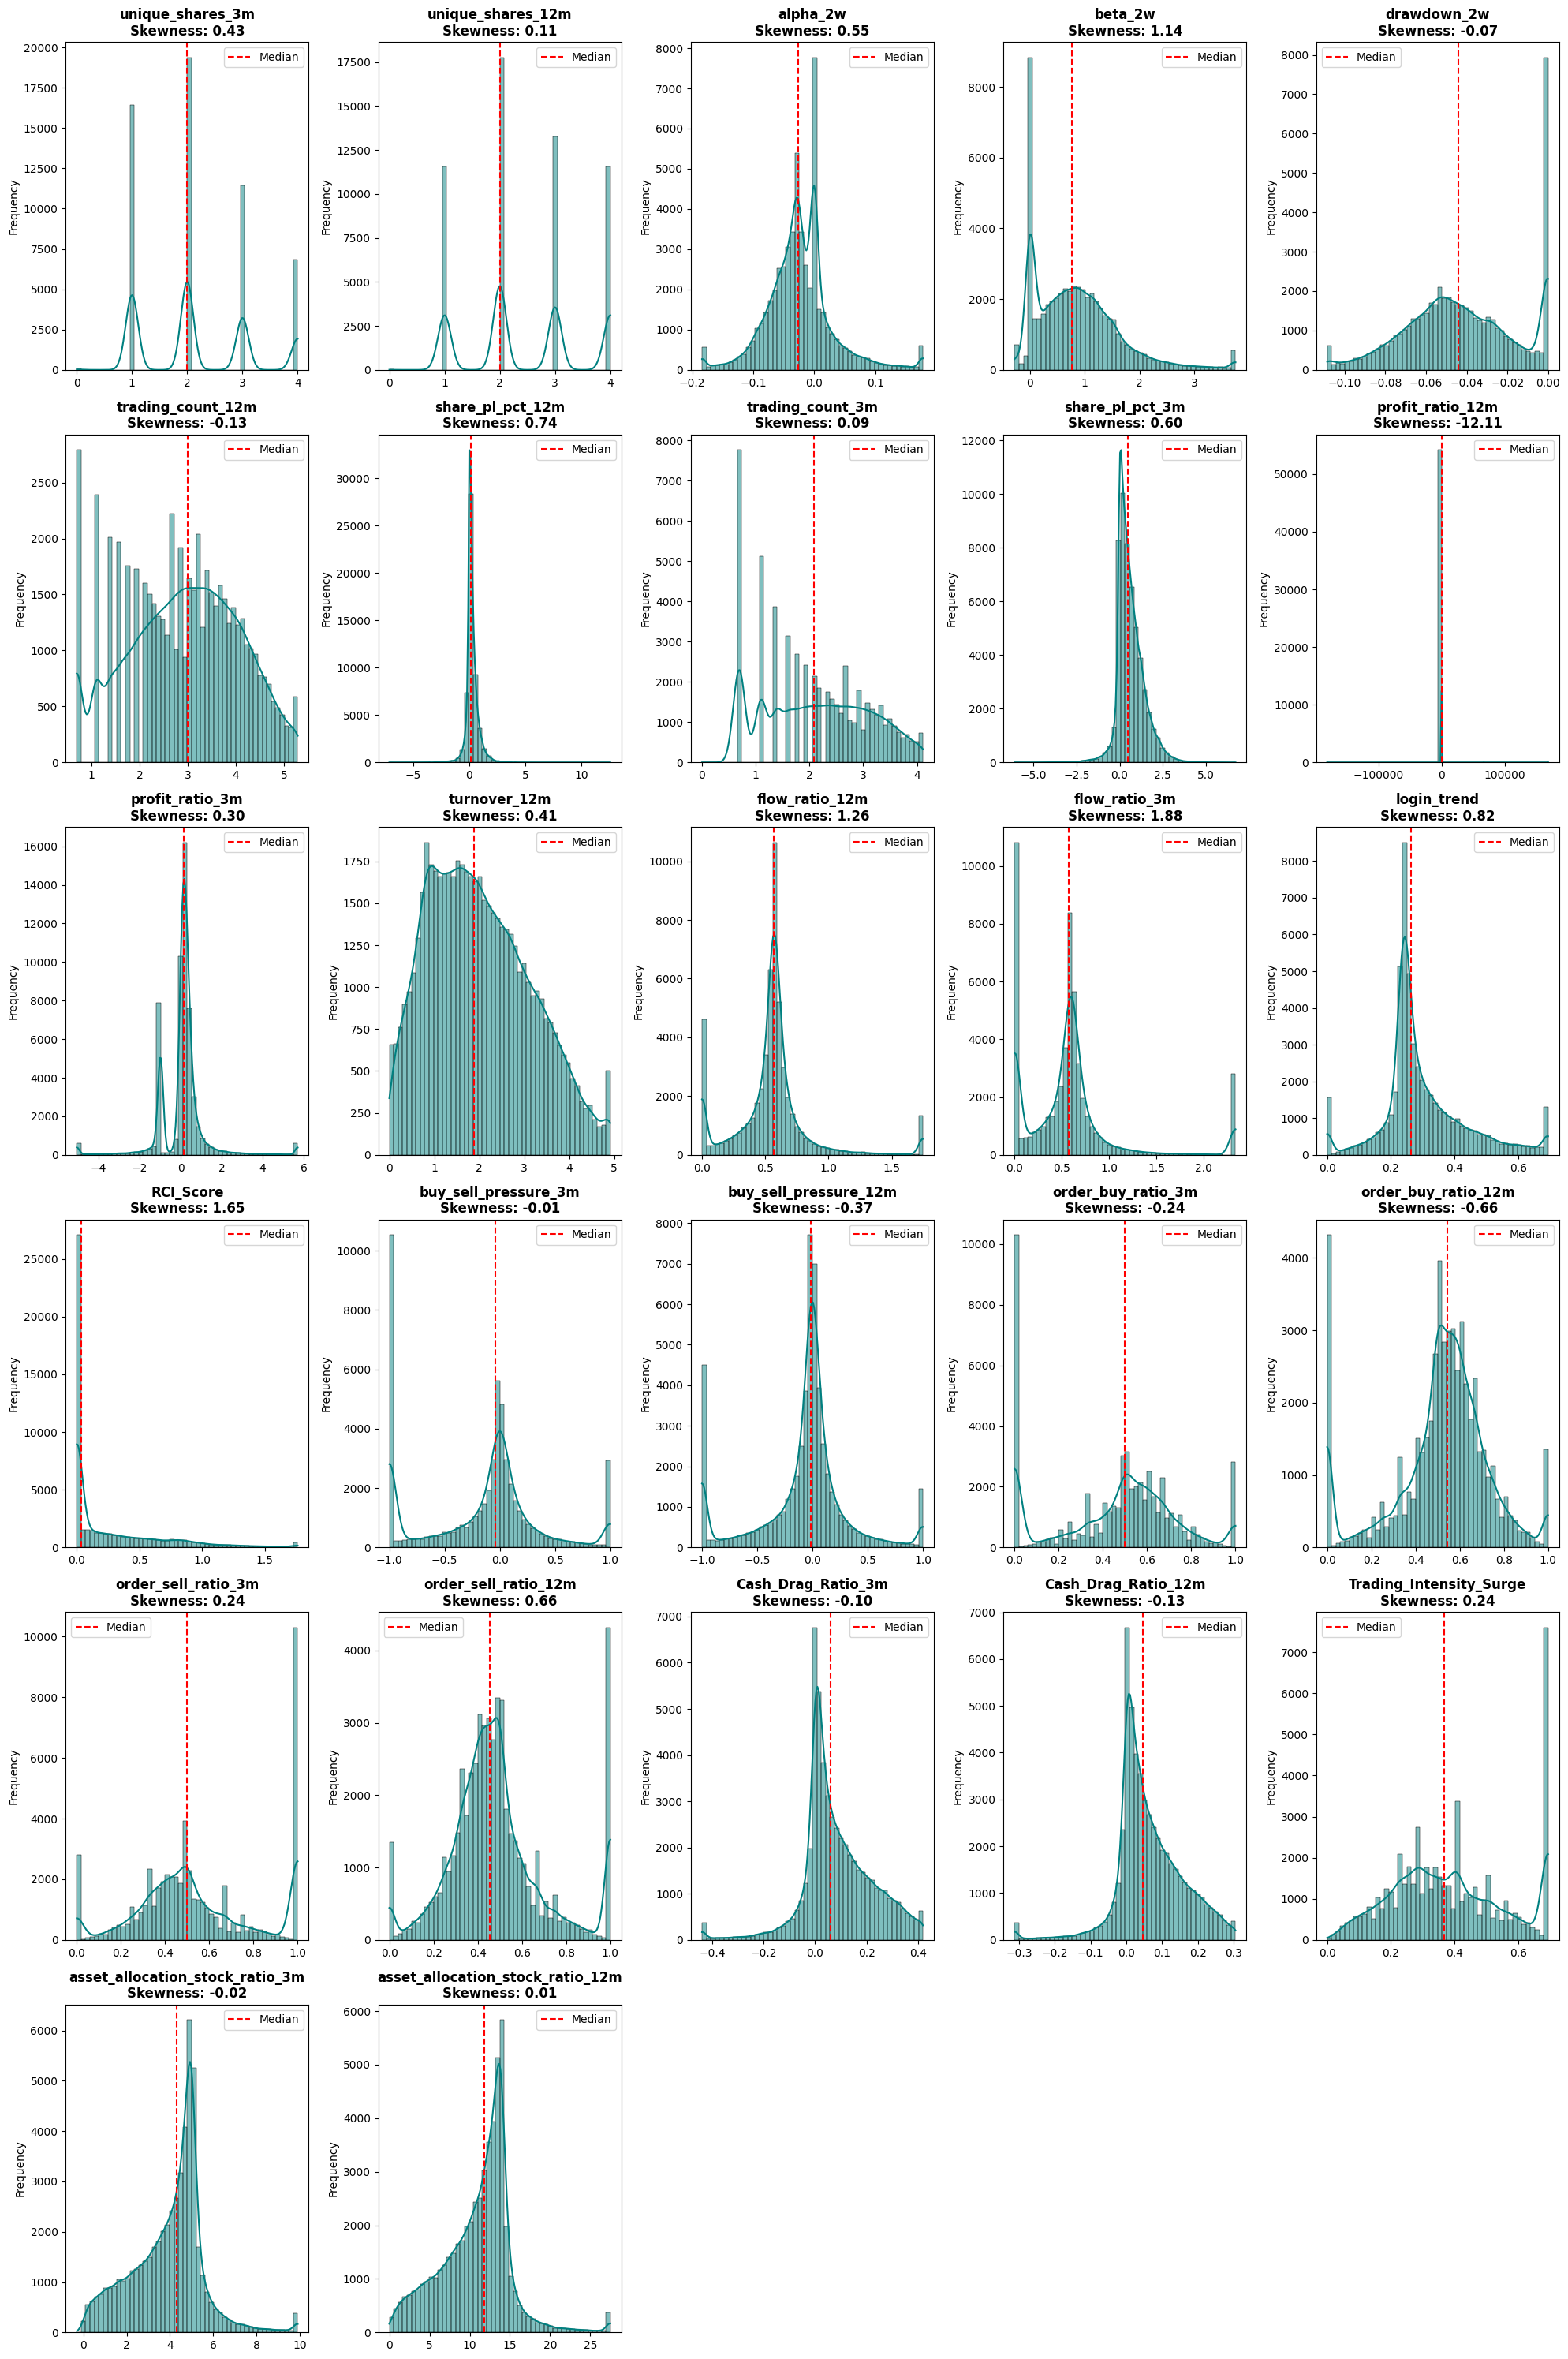

In [577]:
df_clean = df_ready_for_scale.copy()

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def check_money_distribution(df, cols_to_check):
    """
    Vẽ biểu đồ phân phối và tính độ lệch (Skewness)
    """
    # Lọc các cột thực sự tồn tại trong df
    valid_cols = [c for c in cols_to_check if c in df.columns]
    
    n_cols = 5
    n_rows = (len(valid_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(20, 5 * n_rows))
    
    for i, col in enumerate(valid_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # 1. Vẽ Histogram và đường KDE (Kernel Density Estimate)
        sns.histplot(df[col], kde=True, color='teal', bins=50)
        
        # 2. Tính chỉ số Skewness (Độ lệch)
  
        skew_val = df[col].skew()
        plt.title(f'{col}\nSkewness: {skew_val:.2f}', fontsize=12, fontweight='bold')
        plt.xlabel('')
        plt.ylabel('Frequency')
    
        plt.axvline(df[col].median(), color='red', linestyle='--', label='Median')
        plt.legend()

    plt.tight_layout()
    plt.show()

# --- DANH SÁCH CÁC TRƯỜNG TIỀN TỆ CẦN KIỂM TRA ---
money_cols_to_check = [

     'unique_shares_3m', 'unique_shares_12m', 'alpha_2w',
       'beta_2w', 'drawdown_2w', 'trading_count_12m', 'share_pl_pct_12m',
       'trading_count_3m', 'share_pl_pct_3m', 'profit_ratio_12m',
       'profit_ratio_3m', 'turnover_12m', 'flow_ratio_12m', 'flow_ratio_3m',
       'login_trend', 'RCI_Score', 'buy_sell_pressure_3m',
       'buy_sell_pressure_12m', 'order_buy_ratio_3m', 'order_buy_ratio_12m',
       'order_sell_ratio_3m', 'order_sell_ratio_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'order_buy_sell_pressure_3m'
]


check_money_distribution(df_clean, money_cols_to_check)

In [578]:
# Chỉ áp dụng cho các biến có Skewness vẫn lệch phân phối
high_skew_cols = ['share_pl_pct_3m', 'share_pl_pct_12m','cash_flow_3m','cash_flow_12m','asset_allocation_stock_ratio_3m',
                'asset_allocation_stock_ratio_12m', 'Cash_Drag_Ratio_3m', 'Cash_Drag_Ratio_12m','flow_ratio_12m',
                'flow_ratio_3m', 'order_buy_sell_pressure_3m','profit_ratio_3m','profit_ratio_12m', 'beta_2w', 'RCI_Score']

for col in high_skew_cols:
    if col in df_clean.columns:
        # Kẹp giá trị lại, 1% dưới và 99% trên
        lower = df_clean[col].quantile(0.01)
        upper = df_clean[col].quantile(0.99)
        df_clean[col] = df_clean[col].clip(lower, upper)
        print(f"Đã kẹp (clip) biến {col}")

Đã kẹp (clip) biến share_pl_pct_3m
Đã kẹp (clip) biến share_pl_pct_12m
Đã kẹp (clip) biến asset_allocation_stock_ratio_3m
Đã kẹp (clip) biến asset_allocation_stock_ratio_12m
Đã kẹp (clip) biến Cash_Drag_Ratio_3m
Đã kẹp (clip) biến Cash_Drag_Ratio_12m
Đã kẹp (clip) biến flow_ratio_12m
Đã kẹp (clip) biến flow_ratio_3m
Đã kẹp (clip) biến profit_ratio_3m
Đã kẹp (clip) biến profit_ratio_12m
Đã kẹp (clip) biến beta_2w
Đã kẹp (clip) biến RCI_Score


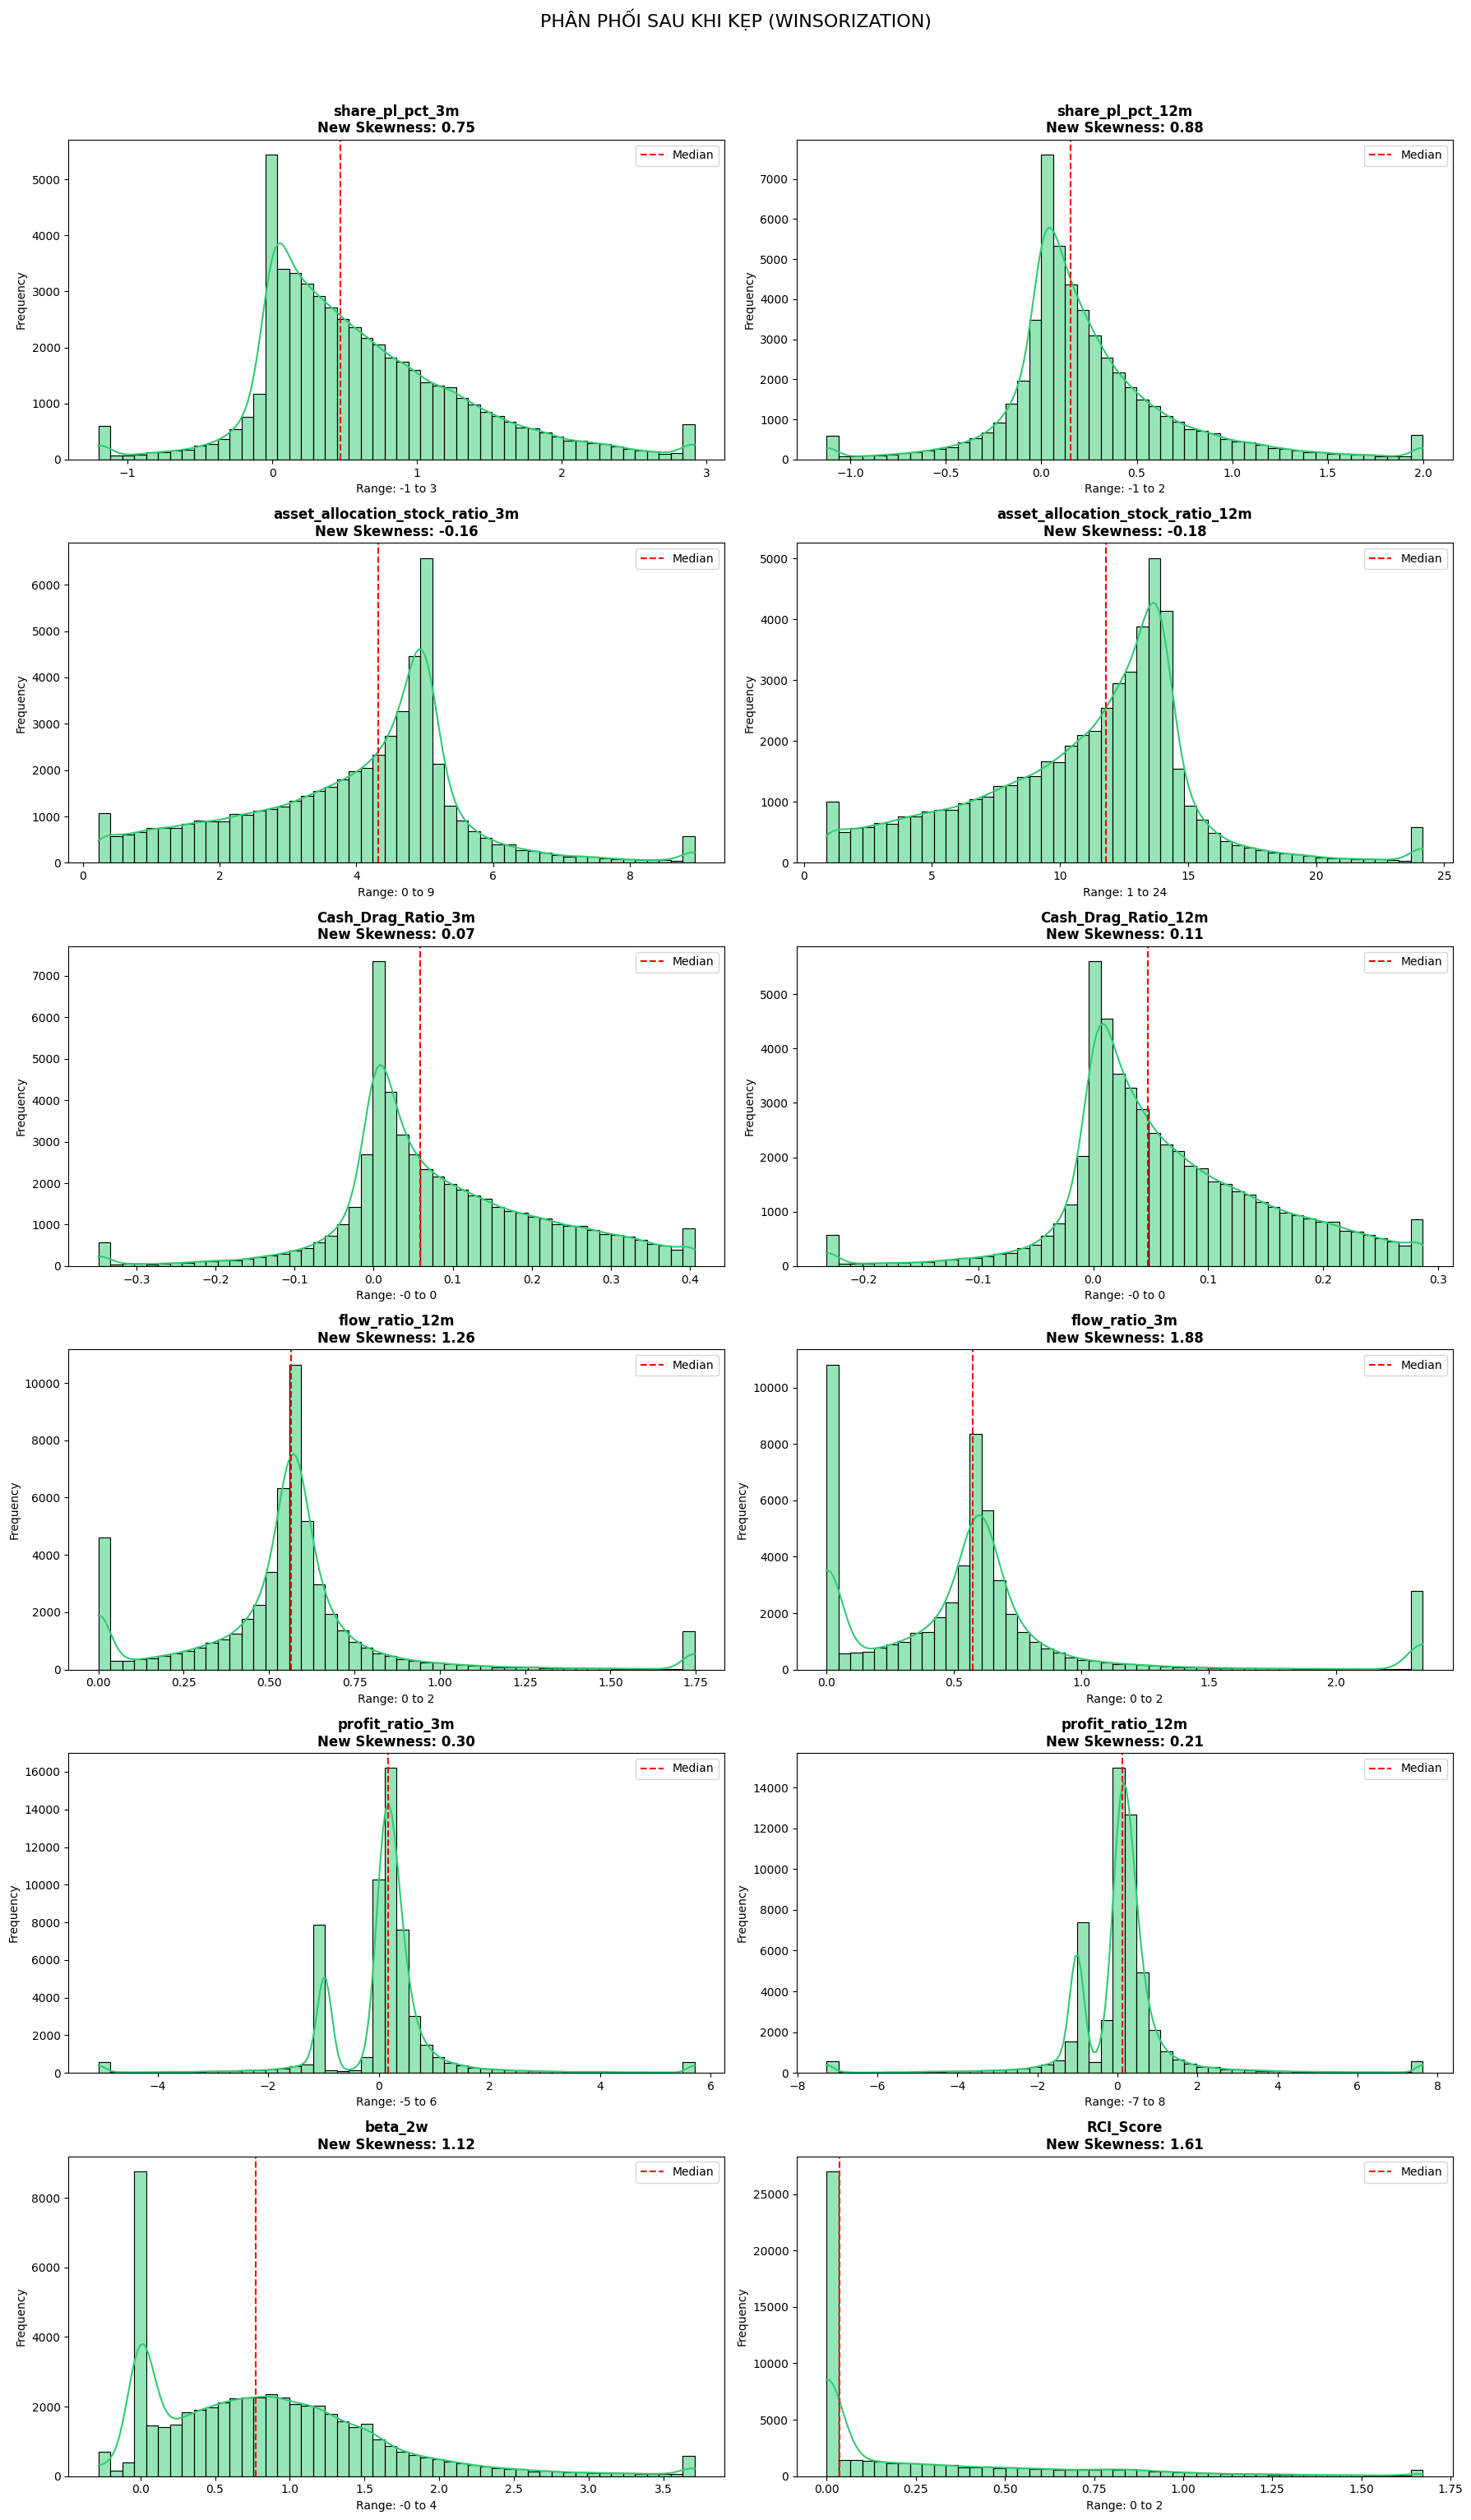

In [579]:
import matplotlib.pyplot as plt
import seaborn as sns

def check_distribution_after_clipping(df, cols_to_check):
    valid_cols = [c for c in cols_to_check if c in df.columns]
    
    n_cols = 2
    n_rows = (len(valid_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(18, 5 * n_rows))
    
    for i, col in enumerate(valid_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        

        sns.histplot(df[col], kde=True, color='#2ecc71', bins=50)
        
        # 2. Tính chỉ số thống kê mới
        new_skew = df[col].skew()
        new_min = df[col].min()
        new_max = df[col].max()
        
        # 3. Trang trí biểu đồ
        plt.title(f'{col}\nNew Skewness: {new_skew:.2f}', fontsize=12, fontweight='bold')
        plt.xlabel(f'Range: {new_min:,.0f} to {new_max:,.0f}') # Hiển thị phạm vi mới
        plt.ylabel('Frequency')
        
        # Thêm đường Median
        plt.axvline(df[col].median(), color='red', linestyle='--', label='Median')
        plt.legend()

    plt.suptitle('PHÂN PHỐI SAU KHI KẸP (WINSORIZATION)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# --- THỰC THI ---
# Danh sách các biến vừa xử lý
high_skew_cols = [ 'share_pl_pct_3m', 'share_pl_pct_12m','cash_flow_3m','cash_flow_12m','asset_allocation_stock_ratio_3m',
                'asset_allocation_stock_ratio_12m', 'Cash_Drag_Ratio_3m', 'Cash_Drag_Ratio_12m','flow_ratio_12m',
                'flow_ratio_3m', 'order_buy_sell_pressure_3m','profit_ratio_3m','profit_ratio_12m', 'beta_2w', 'RCI_Score']

# df_clean lúc này là df đã chạy đoạn code clip ở bước trước
check_distribution_after_clipping(df_clean, high_skew_cols)

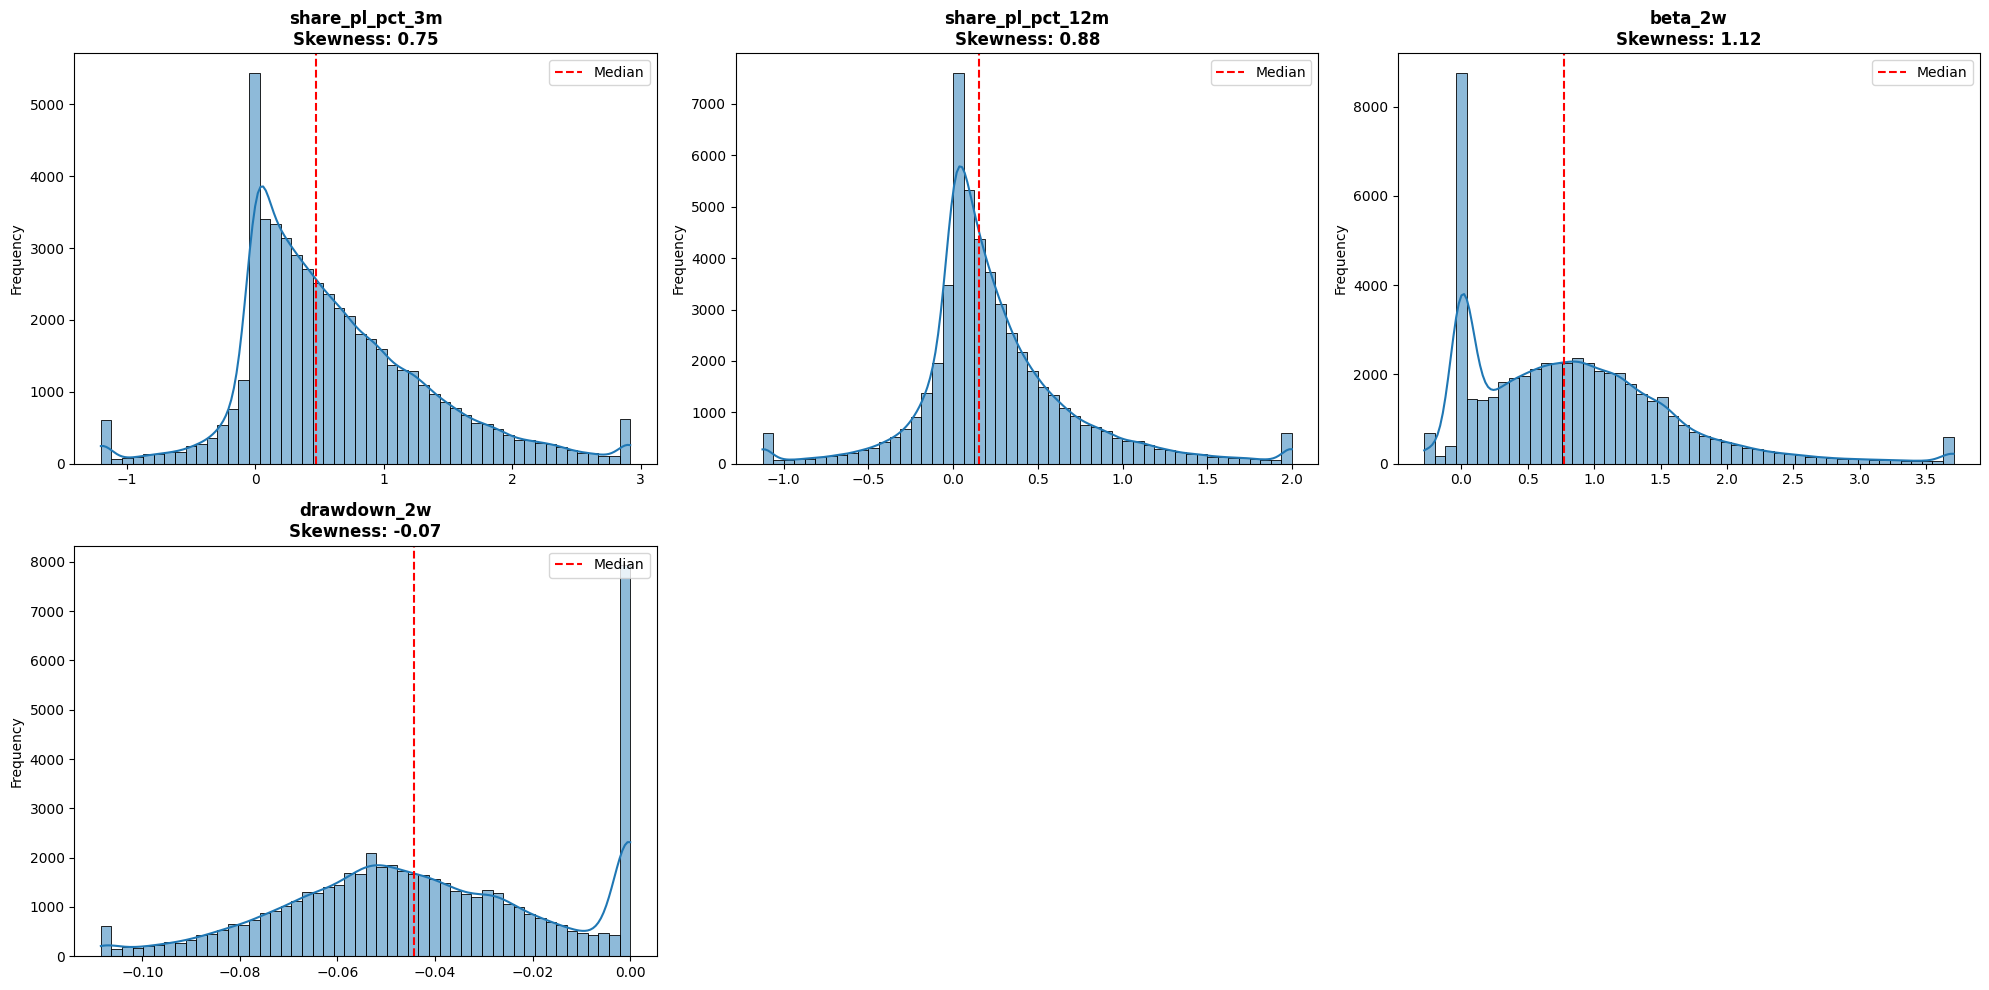

In [580]:
import matplotlib.pyplot as plt
import seaborn as sns
import math


cols_to_check = [
    'profit_value_3m', 'profit_value_12m', 'share_pl_pct_3m', 'share_pl_pct_12m','net_cash_flow_3m','assert_allocation_stock_ratio_3m',
                'assert_allocation_stock_ratio_12m', 'Cash_drag_ratio_3m', 'Cash_drag_ratio_12m', 'conviction_index', 'beta_2w', 'drawdown_2w'
]

# 2. Lọc các cột thực sự tồn tại trong df_clean để tránh lỗi
valid_cols = [c for c in cols_to_check if c in df_clean.columns]

# 3. Thiết lập lưới đồ thị
n_cols = 3  # Số biểu đồ trên 1 hàng
n_rows = math.ceil(len(valid_cols) / n_cols)

plt.figure(figsize=(20, 5 * n_rows))

for i, col in enumerate(valid_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    
    # Vẽ Histogram và đường KDE (màu xanh biển đậm cho dễ nhìn)
    sns.histplot(df_clean[col], kde=True, ax=ax, color='#1f77b4', bins=50)
    
    # Tính chỉ số Skewness
    skew_val = df_clean[col].skew()
    
    # Trang trí tiêu đề và trục
    ax.set_title(f'{col}\nSkewness: {skew_val:.2f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')
    
    # Vẽ đường Median (Trung vị) màu đỏ để tham chiếu
    ax.axvline(df_clean[col].median(), color='red', linestyle='--', linewidth=1.5, label='Median')
    ax.legend(loc='upper right')

# Tự động căn chỉnh khoảng cách
plt.tight_layout()
plt.show()

In [581]:
df_clean.loan_label_next.value_counts()

loan_label_next
0    45013
1     9161
Name: count, dtype: int64

In [582]:
df_clean = df_clean.drop(columns=['avg_nav_ck_3m'], axis=1)

In [583]:
df_clean.fillna(0, inplace=True)

In [584]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix
X = df_clean.drop(columns=['loan_label_next'])
y = df_clean['loan_label_next']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)
y_resampled_counts = pd.Series(y_resampled).value_counts()
count_label_0 = y_resampled_counts.get(0, 0)
count_label_1 = y_resampled_counts.get(1, 0)

print("--- KẾT QUẢ UNDERSAMPLING 1:1 ---")
print(f"Số lượng Label 0 (Đa số mới): {count_label_0:,} mẫu")
print(f"Số lượng Label 1 (Thiểu số): {count_label_1:,} mẫu")
print(f"Tỷ lệ cuối cùng: {count_label_0 / count_label_1:.2f} : 1")


--- KẾT QUẢ UNDERSAMPLING 1:1 ---
Số lượng Label 0 (Đa số mới): 14,658 mẫu
Số lượng Label 1 (Thiểu số): 7,329 mẫu
Tỷ lệ cuối cùng: 2.00 : 1


c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [585]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.special import expit
import numpy as np


# K-Fold setup
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Định nghĩa lại X và y cho việc huấn luyện K-Fold
# X_resampled và y_resampled là đầu ra sau khi Undersample
X_final_train = X_resampled 
y_final_train = y_resampled 

# Các model (Giữ nguyên cấu hình bạn đã chọn)
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=6, max_features='sqrt', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'), 
    "LightGBM": LGBMClassifier(
    random_state=42,
    n_estimators=200,          # Tăng số cây lên nhiều để khai thác learning_rate nhỏ
    learning_rate=0.01,         # Tăng tốc độ học lên 0.01 (thay vì 0.001) để hội tụ nhanh hơn
    max_depth=6,                # Giữ độ sâu vừa phải để chống Overfitting
    colsample_bytree=0.8,       # Sử dụng 80% feature (subsample features)
    subsample=0.8,              # Sử dụng 80% dữ liệu (subsample data)
    reg_alpha=0.1,              # L1 regularization (giúp loại bỏ các feature yếu)
    reg_lambda=0.1,             # L2 regularization (làm mượt model)
    n_jobs=-1                   # Tận dụng tối đa CPU
),
    "CatBoost": CatBoostClassifier(
        verbose=0,
        random_state=42,
        iterations=400, 
        learning_rate=0.01, 
        depth=6, 
        l2_leaf_reg=5.0, 
        subsample=0.8, 
        rsm=0.8, 
        random_strength=1.5, 
        bagging_temperature=1.0
    ),
}

# --- Hàm run_kfold đã điều chỉnh ---
def run_kfold(model, model_name):
    print(f"\n🔍 Đang đánh giá: {model_name} trên tập đã CÂN BẰNG")
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}

    # THAY THẾ X_train_scaled VÀ y_train BẰNG X_final_train VÀ y_final_train
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_final_train, y_final_train)): 
        
        # Lấy dữ liệu train và validation
        X_tr, X_val = X_final_train[train_idx], X_final_train[val_idx]
        y_tr, y_val = y_final_train[train_idx], y_final_train[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]

        scores['accuracy'].append(accuracy_score(y_val, y_pred))
        scores['precision'].append(precision_score(y_val, y_pred))
        scores['recall'].append(recall_score(y_val, y_pred))
        scores['f1'].append(f1_score(y_val, y_pred))
        scores['roc_auc'].append(roc_auc_score(y_val, y_proba))

        print(f" Fold {fold+1}: "
              f"Acc = {scores['accuracy'][-1]:.4f}, "
              f"Prec = {scores['precision'][-1]:.4f}, "
              f"Recall = {scores['recall'][-1]:.4f}, "
              f"F1 = {scores['f1'][-1]:.4f}, "
              f"ROC AUC = {scores['roc_auc'][-1]:.4f}")

    print(f"\n {model_name} - KFold trung bình:")
    for metric, values in scores.items():
        print(f" {metric.capitalize()}: {np.mean(values):.4f}")

# Chạy từng mô hình (K-Fold Evaluation)
for name, model in models.items():
    run_kfold(model, name)

# --- Đánh giá trên tập test cuối cùng ---
print("\n Đánh giá trên tập test cuối cùng:")
for name, model in models.items():
    
    # Huấn luyện trên toàn bộ tập đã cân bằng (X_final_train, y_final_train)
    model.fit(X_final_train, y_final_train) 
    
    # Dự đoán trên tập test GỐC (X_test_scaled, y_test)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    print(f"\n {name} - Test set:")
    print(f" Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f" Precision: {precision_score(y_test, y_pred):.4f}")
    print(f" Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f" F1 Score:  {f1_score(y_test, y_pred):.4f}")
    print(f" ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")


🔍 Đang đánh giá: Random Forest trên tập đã CÂN BẰNG
 Fold 1: Acc = 0.8442, Prec = 0.8312, Recall = 0.6685, F1 = 0.7410, ROC AUC = 0.9070
 Fold 2: Acc = 0.8499, Prec = 0.8309, Recall = 0.6903, F1 = 0.7541, ROC AUC = 0.9058
 Fold 3: Acc = 0.8460, Prec = 0.8316, Recall = 0.6744, F1 = 0.7448, ROC AUC = 0.9054
 Fold 4: Acc = 0.8413, Prec = 0.8288, Recall = 0.6603, F1 = 0.7350, ROC AUC = 0.9084
 Fold 5: Acc = 0.8417, Prec = 0.8166, Recall = 0.6774, F1 = 0.7405, ROC AUC = 0.8999

 Random Forest - KFold trung bình:
 Accuracy: 0.8446
 Precision: 0.8278
 Recall: 0.6742
 F1: 0.7431
 Roc_auc: 0.9053

🔍 Đang đánh giá: Logistic Regression trên tập đã CÂN BẰNG
 Fold 1: Acc = 0.8140, Prec = 0.6828, Recall = 0.8254, F1 = 0.7474, ROC AUC = 0.8955
 Fold 2: Acc = 0.8199, Prec = 0.6957, Recall = 0.8172, F1 = 0.7516, ROC AUC = 0.8944
 Fold 3: Acc = 0.8196, Prec = 0.6963, Recall = 0.8137, F1 = 0.7504, ROC AUC = 0.8982
 Fold 4: Acc = 0.8251, Prec = 0.7037, Recall = 0.8213, F1 = 0.7579, ROC AUC = 0.9008
 Fold

c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 Fold 1: Acc = 0.8515, Prec = 0.8436, Recall = 0.6808, F1 = 0.7535, ROC AUC = 0.9091
[LightGBM] [Info] Number of positive: 5863, number of negative: 11726
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6143
[LightGBM] [Info] Number of data points in the train set: 17589, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147


c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 Fold 2: Acc = 0.8495, Prec = 0.8333, Recall = 0.6855, F1 = 0.7522, ROC AUC = 0.9085
[LightGBM] [Info] Number of positive: 5864, number of negative: 11726
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6143
[LightGBM] [Info] Number of data points in the train set: 17590, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333371 -> initscore=-0.692977
[LightGBM] [Info] Start training from score -0.692977


c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 Fold 3: Acc = 0.8463, Prec = 0.8427, Recall = 0.6621, F1 = 0.7416, ROC AUC = 0.9080
[LightGBM] [Info] Number of positive: 5863, number of negative: 11727
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6142
[LightGBM] [Info] Number of data points in the train set: 17590, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333314 -> initscore=-0.693232
[LightGBM] [Info] Start training from score -0.693232


c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 Fold 4: Acc = 0.8458, Prec = 0.8385, Recall = 0.6658, F1 = 0.7422, ROC AUC = 0.9122
[LightGBM] [Info] Number of positive: 5863, number of negative: 11727
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6140
[LightGBM] [Info] Number of data points in the train set: 17590, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333314 -> initscore=-0.693232
[LightGBM] [Info] Start training from score -0.693232


c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 Fold 5: Acc = 0.8433, Prec = 0.8251, Recall = 0.6726, F1 = 0.7411, ROC AUC = 0.9026

 LightGBM - KFold trung bình:
 Accuracy: 0.8473
 Precision: 0.8367
 Recall: 0.6734
 F1: 0.7461
 Roc_auc: 0.9081

🔍 Đang đánh giá: CatBoost trên tập đã CÂN BẰNG
 Fold 1: Acc = 0.8490, Prec = 0.8282, Recall = 0.6903, F1 = 0.7530, ROC AUC = 0.9100
 Fold 2: Acc = 0.8495, Prec = 0.8242, Recall = 0.6971, F1 = 0.7554, ROC AUC = 0.9071
 Fold 3: Acc = 0.8456, Prec = 0.8280, Recall = 0.6771, F1 = 0.7450, ROC AUC = 0.9094
 Fold 4: Acc = 0.8469, Prec = 0.8318, Recall = 0.6780, F1 = 0.7471, ROC AUC = 0.9111
 Fold 5: Acc = 0.8474, Prec = 0.8250, Recall = 0.6883, F1 = 0.7505, ROC AUC = 0.9049

 CatBoost - KFold trung bình:
 Accuracy: 0.8477
 Precision: 0.8274
 Recall: 0.6862
 F1: 0.7502
 Roc_auc: 0.9085

 Đánh giá trên tập test cuối cùng:

 Random Forest - Test set:
 Accuracy:  0.8907
 Precision: 0.6695
 Recall:    0.6987
 F1 Score:  0.6838
 ROC AUC:   0.9169

 Logistic Regression - Test set:
 Accuracy:  0.8116
 Pre

c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 LightGBM - Test set:
 Accuracy:  0.8949
 Precision: 0.6856
 Recall:    0.6987
 F1 Score:  0.6921
 ROC AUC:   0.9200

 CatBoost - Test set:
 Accuracy:  0.8926
 Precision: 0.6692
 Recall:    0.7211
 F1 Score:  0.6942
 ROC AUC:   0.9204


In [586]:
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


X_train_final = X_resampled 
y_train_final = y_resampled 
X_test_final = X_test_scaled 
y_test_final = y_test 

# Ép về NumPy array cho tính nhất quán và tương thích với KFold indexing
X_train_final_np = np.array(X_train_final)
y_train_final_np = np.array(y_train_final)
X_test_final_np = np.array(X_test_final)
y_test_final_np = np.array(y_test_final)


# ====================================================================
# CÁC MODEL VÀ OBJECTIVES CHO OPTUNA
# ====================================================================

models = {
    # --- LIGHTGBM: Tốc độ cao, cần tune kỹ để không Overfit ---
    "lightgbm_optuna": {
        "model": LGBMClassifier,
        "objective": lambda trial: {
            'n_estimators': trial.suggest_int('n_estimators', 200 , 800), # Tăng min lên 200 vì data bạn >10k dòng
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True), # Log scale để dò kỹ vùng learning rate nhỏ
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 4, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 100), # Quan trọng: Chặn lá quá nhỏ (chống noise)
            'subsample': trial.suggest_float('subsample', 0.6, 0.95), # Bagging fraction
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95), # Feature fraction
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 5.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 5.0, log=True),
            'random_state': 42,
            'n_jobs': -1,
            'verbose': -1
        }
    },


}

# ====================================================================
# HÀM ĐÁNH GIÁ VÀ TỐI ƯU
# ====================================================================

# Hàm đánh giá mô hình bằng KFold (trên tập đã cân bằng)
def evaluate_model(model, X, y):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}

    for train_idx, val_idx in kf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        preds = model.predict(X[val_idx])
        probs = model.predict_proba(X[val_idx])[:, 1]

        scores['accuracy'].append(accuracy_score(y[val_idx], preds))
        scores['precision'].append(precision_score(y[val_idx], preds, zero_division=0))
        scores['recall'].append(recall_score(y[val_idx], preds, zero_division=0))
        scores['f1'].append(f1_score(y[val_idx], preds, zero_division=0))
        scores['roc_auc'].append(roc_auc_score(y[val_idx], probs))

    print("\n KFold Evaluation (Tập đã cân bằng):")
    for metric, values in scores.items():
        print(f" {metric}: {np.mean(values):.4f} (+/- {np.std(values):.4f})")

# Hàm tối ưu bằng Optuna
def optimize_model(model_name, model_class, objective_func):
    def objective(trial):
        params = objective_func(trial)
        model = model_class(**params)
        cv_result = cross_validate(
            model,
            X_train_final_np,
            y_train_final_np,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring='average_precision', 
            n_jobs=-1
        )
        # Mục tiêu: Tối đa hóa ROC AUC trung bình
        return np.mean(cv_result['test_score'])

    print(f"Bắt đầu tối ưu {model_name}...")
    # Tạo study và tối ưu (có thể tăng n_trials lên 50-100 nếu có thời gian)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=35) 

    print(f"\n Best ROC AUC cho {model_name}: {study.best_value:.4f}")
    best_model = model_class(**study.best_params)
    
    # Huấn luyện mô hình tốt nhất trên toàn bộ tập đã cân bằng
    best_model.fit(X_train_final_np, y_train_final_np) 
    
    # Đánh giá KFold trên tập đã cân bằng
    evaluate_model(best_model, X_train_final_np, y_train_final_np) 

    return {
        "model": best_model,
        "params": study.best_params,
        "best_roc_auc": study.best_value
    }

# ====================================================================
# CHẠY TỐI ƯU VÀ BÁO CÁO KẾT QUẢ
# ====================================================================

best_models = {}
for model_name, model_info in models.items():
    print(f"\n==========================================")
    print(f" Tối ưu: {model_name}")
    print(f"==========================================")
    best_models[model_name] = optimize_model(
        model_name,
        model_info["model"],
        model_info["objective"]
    )

# Classification report trên tập test GỐC (Đánh giá cuối cùng)
print(f"\n\n==========================================")
print(f" BÁO CÁO CUỐI CÙNG TRÊN TẬP TEST GỐC")
print(f"==========================================")

for model_name, info in best_models.items():
    model = info["model"]
    # Dự đoán trên tập Test GỐC (đã scaled)
    y_pred = model.predict(X_test_final_np) 
    
    print(f"\n Classification Report - {model_name}:")
    print(classification_report(y_test_final_np, y_pred, target_names=["Label 0", "Label 1"], zero_division=0))

[I 2026-01-08 17:24:49,786] A new study created in memory with name: no-name-ee62f703-7527-445f-b78c-abe2278ccce2



 Tối ưu: lightgbm_optuna
Bắt đầu tối ưu lightgbm_optuna...


[I 2026-01-08 17:24:57,439] Trial 0 finished with value: 0.8601404431143642 and parameters: {'n_estimators': 445, 'learning_rate': 0.0035063442719073116, 'num_leaves': 76, 'max_depth': 6, 'min_child_samples': 37, 'subsample': 0.6111193636975715, 'colsample_bytree': 0.7346108513160229, 'reg_alpha': 0.0044266246537677505, 'reg_lambda': 1.0198451470709708}. Best is trial 0 with value: 0.8601404431143642.
[I 2026-01-08 17:25:03,612] Trial 1 finished with value: 0.86891570942017 and parameters: {'n_estimators': 618, 'learning_rate': 0.00826438125736804, 'num_leaves': 26, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.6694848327879622, 'colsample_bytree': 0.9459629278652335, 'reg_alpha': 0.03294303801324047, 'reg_lambda': 1.227674496865747}. Best is trial 1 with value: 0.86891570942017.
[I 2026-01-08 17:25:12,359] Trial 2 finished with value: 0.8697848605070378 and parameters: {'n_estimators': 538, 'learning_rate': 0.010887595903996487, 'num_leaves': 69, 'max_depth': 10, 'min_child_


 Best ROC AUC cho lightgbm_optuna: 0.8713
[LightGBM] [Info] Number of positive: 7329, number of negative: 14658
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6142
[LightGBM] [Info] Number of data points in the train set: 21987, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5863, number of negative: 11726
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6143
[LightGBM] [Info] Number of data points in the train set: 17589, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5864, number of negative: 11726
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6143
[LightGBM] [Info] Number of data points in the train set: 17590, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333371 -> initscore=-0.692977
[LightGBM] [Info] Start training from score -0.692977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5863, number of negative: 11727
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6142
[LightGBM] [Info] Number of data points in the train set: 17590, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333314 -> initscore=-0.693232
[LightGBM] [Info] Start training from score -0.693232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5863, number of negative: 11727
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6140
[LightGBM] [Info] Number of data points in the train set: 17590, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333314 -> initscore=-0.693232
[LightGBM] [Info] Start training from score -0.693232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 Classification Report cho mô hình: lightgbm_optuna

[TEST]
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      9003
           1       0.65      0.74      0.70      1832

    accuracy                           0.89     10835
   macro avg       0.80      0.83      0.81     10835
weighted avg       0.90      0.89      0.89     10835



c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


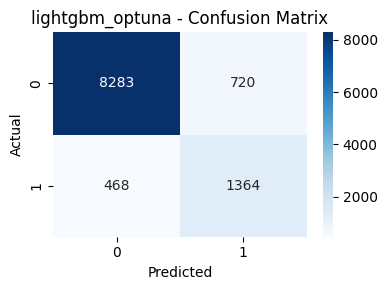

In [587]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, title, labels=["0", "1"]):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()

    plt.show()

# Lặp qua từng mô hình trong best_models
for name, model_info in best_models.items():
    model = model_info["model"]  # Lấy actual model đã được fit

    print(f"\n Classification Report cho mô hình: {name}")
    
    # Predict
    y_pred_test = model.predict(X_test_scaled)

    # In classification report
    print("\n[TEST]")
    print(classification_report(y_test, y_pred_test, zero_division=0))

    # Vẽ Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    plot_confusion_matrix(cm, title=f"{name} - Confusion Matrix")

In [588]:
y_proba = best_models['lightgbm_optuna']['model'].predict_proba(X_test_final_np)[:, 1]
print(y_proba)

[0.77273967 0.07029523 0.01164867 ... 0.95604737 0.03984854 0.11565051]


c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [589]:
y_proba.__len__()

10835

In [590]:
X_test['proba'] = y_proba
X_test['label'] = y_test

X_test

unique_shares_3m  unique_shares_12m  alpha_2w   beta_2w  drawdown_2w  \
43560                 3                  4 -0.080087  0.743653    -0.058111   
17151                 1                  1 -0.066744 -0.280576    -0.049323   
9865                  1                  1  0.000000  0.000000     0.000000   
18030                 2                  2 -0.054398  0.732318    -0.044844   
51677                 3                  4 -0.030581  0.892971    -0.058319   
...                 ...                ...       ...       ...          ...   
12268                 2                  2  0.022667  1.750737    -0.061485   
43499                 4                  4 -0.045290  0.962980    -0.071862   
54289                 1                  1  0.104913  3.706219    -0.108155   
5368                  1                  2 -0.027983  0.000531    -0.000006   
10418                 2                  3  0.051587  0.892826    -0.039977   

       trading_count_12m  share_pl_pct_12m  trading_count_3m  share_pl_pct_3m  \
43560           4.663439         -0.316653          3.931826         0.353392   
17151           3.688879          1.150132          2.397895         0.610731   
9865            2.484907         -0.152310          0.693147         0.070355   
18030           2.484907          0.117116          1.386294         0.224476   
51677           4.343805          0.148635          3.401197         1.416743   
...                  ...               ...               ...              ...   
12268           2.079442          0.131881          1.945910         0.447176   
43499           4.828314          0.208819          3.637586         0.601458   
54289           2.639057          0.024367          2.639057         0.094097   
5368            3.688879          0.340531          1.609438         0.406798   
10418           3.367296          0.094729          2.397895         0.066516   

       profit_ratio_12m  profit_ratio_3m  turnover_12m  flow_ratio_12m  \
43560         -0.378969        -0.182285      2.935644        0.533247   
17151          0.118282         0.255768      1.186858        0.453742   
9865          -1.002771        -0.974745      1.625388        0.439194   
18030          0.314648         0.354033      0.666544        0.361812   
51677          0.383248         0.214451      2.362453        0.504299   
...                 ...              ...           ...             ...   
12268          0.321634         0.354724      1.519841        0.622591   
43499         -0.150334         0.064942      2.617582        0.547261   
54289          0.330926         0.334602      3.523271        0.831971   
5368          -7.269664        -4.701984      1.709796        0.424069   
10418          0.152950         0.124965      2.012449        0.691918   

       flow_ratio_3m  login_trend  RCI_Score  buy_sell_pressure_3m  \
43560   5.696016e-01     0.250578   0.882393             -0.041200   
17151   1.787600e-01     0.239798   0.000000             -0.660614   
9865    4.726404e-14     0.077387   0.000000             -1.000000   
18030   1.817848e-14     0.307967   0.000000             -1.000000   
51677   7.161503e-01     0.299406   0.766992              0.149425   
...              ...          ...        ...                   ...   
12268   4.698907e-01     0.370596   0.000000             -0.183649   
43499   6.042573e-01     0.000000   0.448981              0.005874   
54289   8.961828e-01     0.554311   0.264585              0.353945   
5368    4.674465e-15     0.162204   0.000000             -1.000000   
10418   1.371416e+00     0.231289   0.193887              0.746243   

       buy_sell_pressure_12m  order_buy_ratio_3m  order_buy_ratio_12m  \
43560              -0.058500            0.602094             0.639144   
17151              -0.182603            0.352941             0.507246   
9865               -0.205946            0.000000             0.666667   
18030              -0.333364            0.000000             0.

In [591]:
X_test['pred'] = y_pred_test

In [592]:
X_test.loc[X_test['proba'] >= 0.5]

unique_shares_3m  unique_shares_12m  alpha_2w   beta_2w  drawdown_2w  \
43560                 3                  4 -0.080087  0.743653    -0.058111   
51677                 3                  4 -0.030581  0.892971    -0.058319   
48134                 1                  1 -0.104044  0.674652    -0.052169   
54987                 4                  4 -0.184046 -0.280576    -0.108487   
24372                 3                  3 -0.054621  0.963973    -0.057159   
...                 ...                ...       ...       ...          ...   
53902                 3                  4  0.002460  2.288307    -0.074325   
55964                 2                  2  0.177968  3.706219    -0.076313   
3445                  3                  3 -0.021938  1.131912    -0.068952   
58070                 4                  4  0.060966  1.856305    -0.049555   
54289                 1                  1  0.104913  3.706219    -0.108155   

       trading_count_12m  share_pl_pct_12m  trading_count_3m  share_pl_pct_3m  \
43560           4.663439         -0.316653          3.931826         0.353392   
51677           4.343805          0.148635          3.401197         1.416743   
48134           3.951244         -1.007782          3.258097        -0.730272   
54987           5.117994          1.657286          4.110874         2.725868   
24372           4.564348          0.278915          3.367296         0.250586   
...                  ...               ...               ...              ...   
53902           3.891820          0.183178          3.044522         0.521040   
55964           3.988984          1.477112          3.218876         2.150844   
3445            3.988984          0.341756          3.044522         1.169968   
58070           4.158883         -0.047150          3.526361         0.536493   
54289           2.639057          0.024367          2.639057         0.094097   

       profit_ratio_12m  profit_ratio_3m  turnover_12m  flow_ratio_12m  \
43560         -0.378969        -0.182285      2.935644        0.533247   
51677          0.383248         0.214451      2.362453        0.504299   
48134         -1.002771        -0.974745      2.712656        0.585468   
54987          0.458573         0.180573      1.979429        0.513507   
24372          0.011899        -0.115745      3.848882        0.583202   
...                 ...              ...           ...             ...   
53902         -1.002771        -0.974745      4.489595        0.566425   
55964          0.617605         0.434135      2.095706        0.694228   
3445           0.461705         0.309228      2.560206        0.636283   
58070          0.068001         0.239781      3.557724        0.601831   
54289          0.330926         0.334602      3.523271        0.831971   

       flow_ratio_3m  login_trend  RCI_Score  buy_sell_pressure_3m  \
43560       0.569602     0.250578   0.882393             -0.041200   
51677       0.716150     0.299406   0.766992              0.149425   
48134       0.412082     0.395756   0.204385             -0.271055   
54987       0.498198     0.250523   0.260138             -0.142145   
24372       0.639036     0.240468   0.458030              0.051867   
...              ...          ...        ...                   ...   
53902       0.559535     0.289952   1.672303             -0.055109   
55964       0.695963     0.416701   0.207867              0.124471   
3445        0.539179     0.244061   0.390155             -0.083556   
58070       0.631662     0.421994   0.447138              0.042219   
54289       0.896183     0.554311   0.264585              0.353945   

       buy_sell_pressure_12m  order_buy_ratio_3m  order_buy_ratio_12m  \
43560              -0.058500            0.602094             0.639144   
51677              -0.103005            0.691358             0.556818   
48134               0.019796            0.511628             0.542553   
54987              -0.088764            0.684091             0.

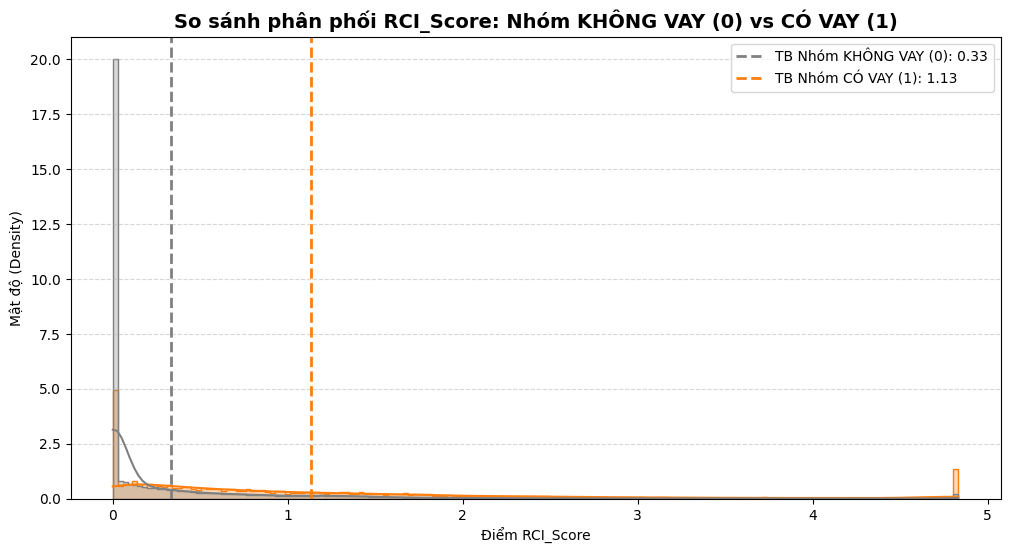

C:\Users\Admin\AppData\Local\Temp\ipykernel_10776\2780722370.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


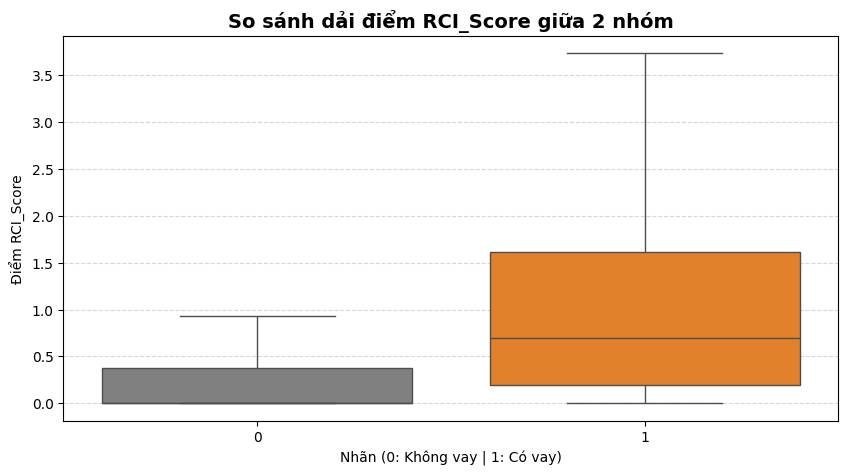


BẢNG SO SÁNH CHỈ SỐ THỐNG KÊ RCI_SCORE
                   count      mean       std  min       25%       50%  \
loan_label_next                                                         
0                52420.0  0.333147  0.684198  0.0  0.000000  0.000000   
1                 9161.0  1.131927  1.247781  0.0  0.199722  0.699827   

                      75%       max  
loan_label_next                      
0                0.372656  4.832039  
1                1.615257  4.832039  


In [593]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. CHUẨN BỊ DỮ LIỆU ---
# Lọc lấy các cột cần thiết và loại bỏ NaN
df_compare = df[['loan_label_next', 'RCI_Score']].dropna().copy()

# [FIX LỖI QUAN TRỌNG]: Ép kiểu dữ liệu về số nguyên (int) để đồng nhất
# Nếu dữ liệu đang là string '0', '1' hoặc float 0.0, 1.0 sẽ về hết int 0, 1
try:
    df_compare['loan_label_next'] = df_compare['loan_label_next'].astype(int)
except ValueError:
    # Phòng trường hợp dữ liệu lỗi không thể ép kiểu, ta in ra để kiểm tra
    print("Cảnh báo: Dữ liệu loan_label_next chứa giá trị không phải số.")
    print(df_compare['loan_label_next'].unique())

# --- 2. VẼ BIỂU ĐỒ HISTOGRAM ---
plt.figure(figsize=(12, 6))

# Định nghĩa palette bao trọn cả trường hợp số (0, 1) và chuỗi ('0', '1') để không bao giờ lỗi
safe_palette = {
    0: 'gray', 1: '#ff7f0e', 
    '0': 'gray', '1': '#ff7f0e'
}

sns.histplot(
    data=df_compare, 
    x='RCI_Score', 
    hue='loan_label_next',     
    kde=True,                  
    palette=safe_palette,      # Sử dụng palette an toàn
    stat="density",            
    common_norm=False,         
    element="step",            
    alpha=0.3                  
)

# Tính đường trung bình (chỉ tính trên dữ liệu int cho chính xác)
mean_0 = df_compare[df_compare['loan_label_next'] == 0]['RCI_Score'].mean()
mean_1 = df_compare[df_compare['loan_label_next'] == 1]['RCI_Score'].mean()

plt.axvline(mean_0, color='gray', linestyle='--', linewidth=2, label=f'TB Nhóm KHÔNG VAY (0): {mean_0:.2f}')
plt.axvline(mean_1, color='#ff7f0e', linestyle='--', linewidth=2, label=f'TB Nhóm CÓ VAY (1): {mean_1:.2f}')

plt.title('So sánh phân phối RCI_Score: Nhóm KHÔNG VAY (0) vs CÓ VAY (1)', fontsize=14, fontweight='bold')
plt.xlabel('Điểm RCI_Score')
plt.ylabel('Mật độ (Density)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# --- 3. VẼ BIỂU ĐỒ BOXPLOT ---
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_compare, 
    x='loan_label_next', 
    y='RCI_Score', 
    palette=safe_palette, # Dùng lại palette an toàn
    showfliers=False  
)

plt.title('So sánh dải điểm RCI_Score giữa 2 nhóm', fontsize=14, fontweight='bold')
plt.xlabel('Nhãn (0: Không vay | 1: Có vay)')
plt.ylabel('Điểm RCI_Score')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# --- 4. BẢNG THỐNG KÊ ---
print("\n" + "="*40)
print("BẢNG SO SÁNH CHỈ SỐ THỐNG KÊ RCI_SCORE")
print("="*40)
print(df_compare.groupby('loan_label_next')['RCI_Score'].describe())

In [594]:
pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")


'2026-01-08 17:28:33'

In [595]:
import pickle
import os 
from lightgbm import LGBMClassifier # Cần import lại class này nếu chưa import

# Giả định: 
# 1. Quá trình tối ưu đã chạy xong và biến best_models đã được điền.
# 2. X_train_final_np và y_train_final_np đã được định nghĩa và sử dụng.

# Lấy đối tượng mô hình LightGBM tốt nhất đã được huấn luyện
# Nó nằm trong dictionary best_models dưới key 'lightgbm_optuna' và là giá trị của key 'model'
best_lgbm_model = best_models["lightgbm_optuna"]["model"]
# get datetime


# --- Lưu mô hình ---
file_name = "lightgbm_optuna_best_model.pkl"

try:
    with open(file_name, "wb") as f:
        pickle.dump(best_lgbm_model, f)
        
    print(f"✅ Mô hình LightGBM (Optuna) đã được lưu thành công vào '{file_name}'.")
    # Bạn cũng có thể lưu các mô hình khác (Random Forest, CatBoost) tương tự nếu muốn
    
    # In ra đường dẫn tuyệt đối để dễ dàng tìm thấy file
    print(f"Đường dẫn lưu: {os.path.abspath(file_name)}")
    
except Exception as e:
    print(f"❌ Lỗi xảy ra trong quá trình lưu mô hình: {e}")

✅ Mô hình LightGBM (Optuna) đã được lưu thành công vào 'lightgbm_optuna_best_model.pkl'.
Đường dẫn lưu: C:\Users\Admin\Downloads\lightgbm_optuna_best_model.pkl


In [596]:
with open("scaler_v1.pkl", "wb") as f:
    pickle.dump(scaler, f)

# 2. Lưu feature order (list)
feature_order = list(X_train.columns)
with open("feature_order_v1.pkl", "wb") as f:
    pickle.dump(feature_order, f)

--- ĐANG LOAD CÁC FILE .PKL ---
✅ Đã load Model LightGBM.
✅ Đã load danh sách 29 features.
✅ Đã load Scaler.

--- TOP 25 FEATURE QUAN TRỌNG NHẤT ---
                             Feature  Importance
4                        drawdown_2w        1395
11                      turnover_12m        1294
3                            beta_2w        1279
5                  trading_count_12m        1265
15                         RCI_Score        1079
23               Cash_Drag_Ratio_12m        1054
7                   trading_count_3m        1021
2                           alpha_2w         929
13                     flow_ratio_3m         919
14                       login_trend         867
10                   profit_ratio_3m         832
6                   share_pl_pct_12m         781
24           Trading_Intensity_Surge         765
8                    share_pl_pct_3m         759
26  asset_allocation_stock_ratio_12m         746
9                   profit_ratio_12m         679
22                

C:\Users\Admin\AppData\Local\Temp\ipykernel_10776\3002544822.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


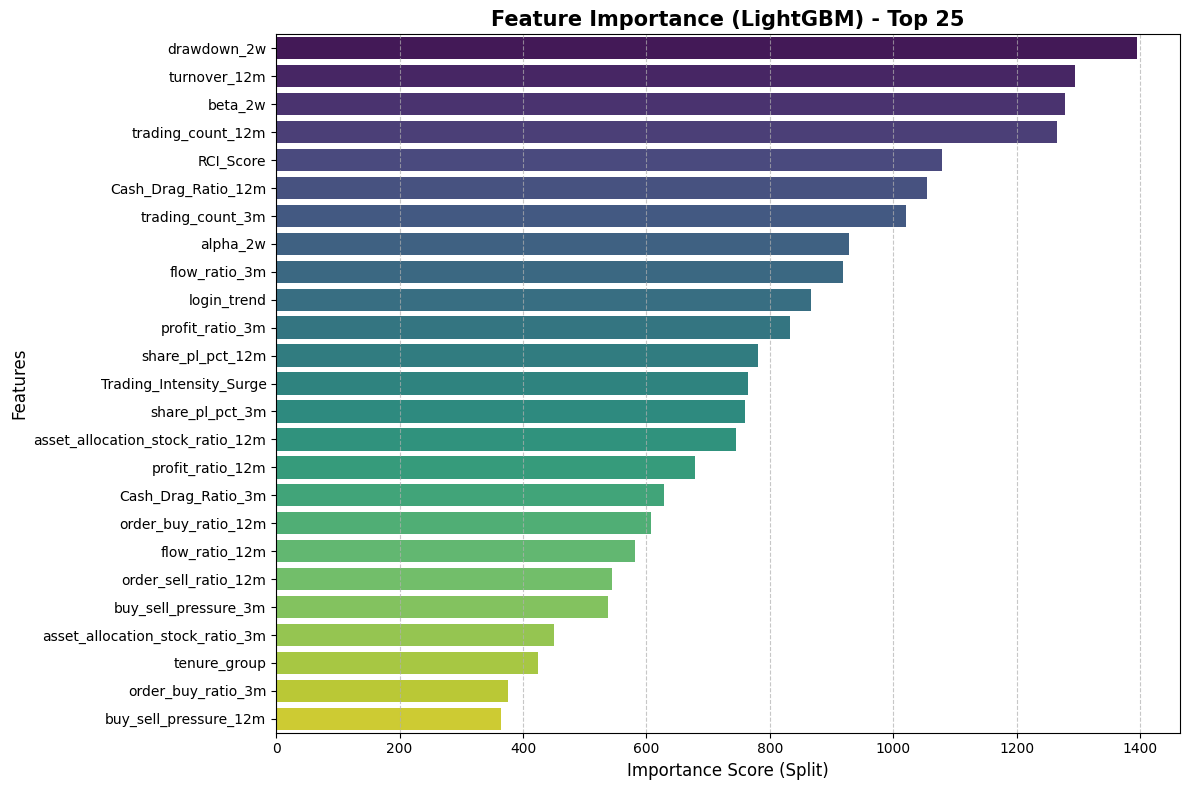

In [597]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. LOAD CÁC FILE ĐÃ LƯU (.pkl)
# ==============================================================================
print("--- ĐANG LOAD CÁC FILE .PKL ---")

try:
    # A. Load Model LightGBM
    with open("lightgbm_optuna_best_model.pkl", "rb") as f:
        loaded_model = pickle.load(f)
    print("✅ Đã load Model LightGBM.")

    # B. Load Feature Order (Danh sách tên cột)
    # RẤT QUAN TRỌNG: Vì model train trên numpy array (đã mất tên cột), 
    # ta cần list này để map lại tên.
    with open("feature_order_v1.pkl", "rb") as f:
        feature_names = pickle.load(f)
    print(f"✅ Đã load danh sách {len(feature_names)} features.")
    
    # C. Load Scaler (Để kiểm tra thôi, không dùng vẽ biểu đồ)
    with open("scaler_v1.pkl", "rb") as f:
        loaded_scaler = pickle.load(f)
    print("✅ Đã load Scaler.")

except Exception as e:
    print(f"❌ Lỗi khi load file: {e}")
    # Dừng chương trình nếu lỗi
    raise e

# ==============================================================================
# 2. TRÍCH XUẤT VÀ VẼ FEATURE IMPORTANCE
# ==============================================================================

def plot_feature_importance(model, feature_list, top_n=20):
    """
    Hàm vẽ biểu đồ tầm quan trọng của biến từ model LightGBM/XGBoost/RF
    """
    # 1. Lấy giá trị importance
    # Với LightGBM sklearn API, mặc định feature_importances_ là kiểu "split" (số lần chia)
    # Nếu muốn kiểu "gain" (lượng thông tin mang lại), cần truy cập booster
    importances = model.feature_importances_
    
    # Kiểm tra khớp độ dài
    if len(importances) != len(feature_list):
        print(f"⚠️ CẢNH BÁO: Số lượng biến trong model ({len(importances)}) "
              f"khác với danh sách tên biến ({len(feature_list)}).")
        return

    # 2. Tạo DataFrame để dễ sắp xếp
    feature_imp_df = pd.DataFrame({
        'Feature': feature_list,
        'Importance': importances
    })

    # 3. Sắp xếp giảm dần
    feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)
    
    # 4. Hiển thị Top N ra màn hình console
    print(f"\n--- TOP {top_n} FEATURE QUAN TRỌNG NHẤT ---")
    print(feature_imp_df.head(top_n))

    # 5. Vẽ biểu đồ
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='Importance', 
        y='Feature', 
        data=feature_imp_df.head(top_n), # Chỉ vẽ top N
        palette='viridis'
    )
    
    plt.title(f'Feature Importance (LightGBM) - Top {top_n}', fontsize=15, fontweight='bold')
    plt.xlabel('Importance Score (Split)', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return feature_imp_df

# --- THỰC THI ---
df_importance = plot_feature_importance(loaded_model, feature_names, top_n=25)

--- 1. LOADING RESOURCES ---
✅ Model & 29 Feature names loaded.
--- 2. PREPARING DATA FOR SHAP ---
⚠️ Dữ liệu Test có 10835 dòng. Đang lấy mẫu 2000 dòng để tính SHAP nhanh hơn...
✅ Data shape for SHAP: (5000, 29)
--- 3. CALCULATING SHAP VALUES ---


c:\Users\Admin\.conda\envs\py39\lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


--- 4. PLOTTING ---


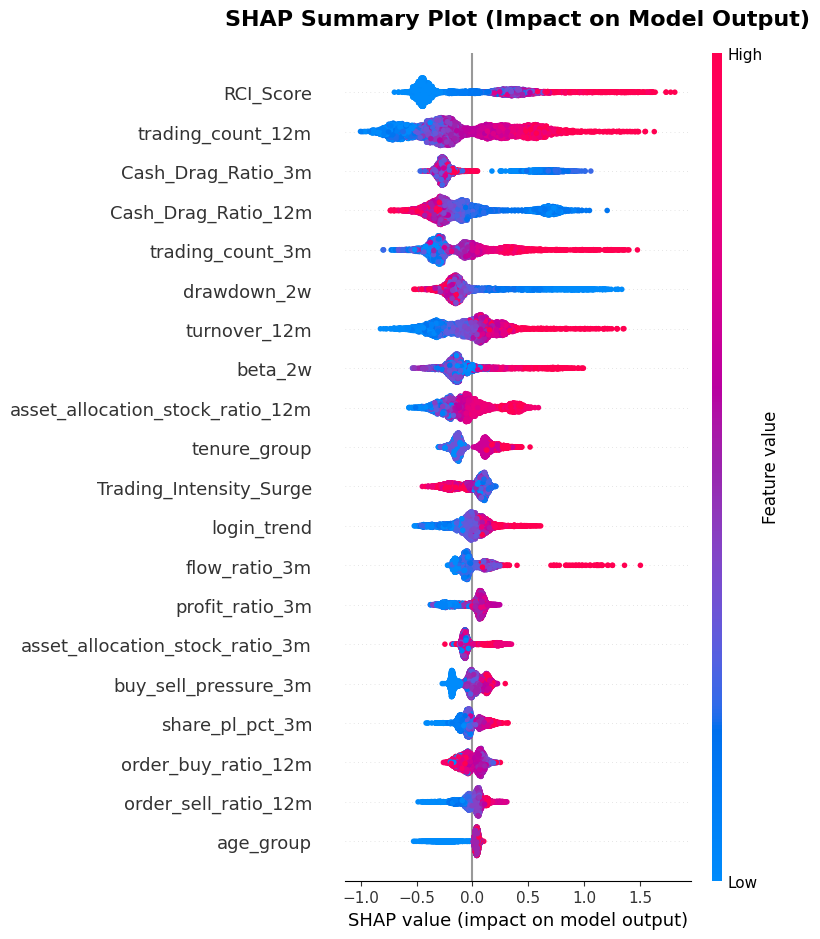

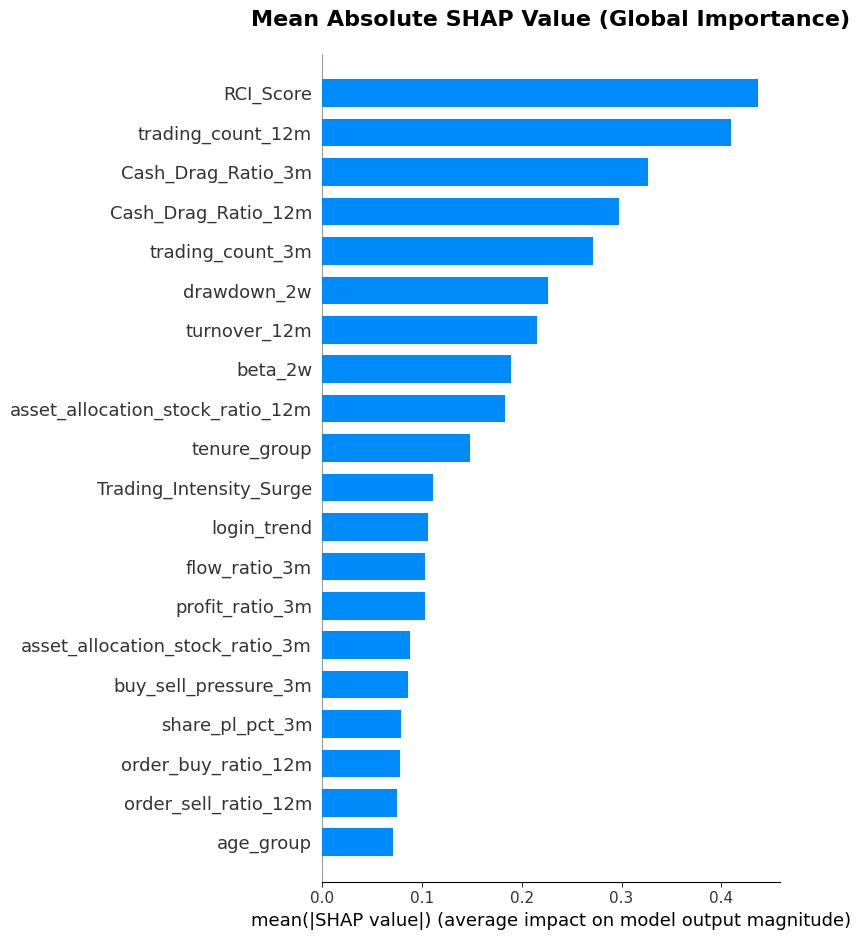

In [598]:
import shap
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# 1. LOAD MODEL VÀ TÊN FEATURE
# ==============================================================================
print("--- 1. LOADING RESOURCES ---")

# Load Model
with open("lightgbm_optuna_best_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# Load danh sách tên cột (Feature Names)
with open("feature_order_v1.pkl", "rb") as f:
    feature_names = pickle.load(f)

print(f"✅ Model & {len(feature_names)} Feature names loaded.")

# ==============================================================================
# 2. CHUẨN BỊ DỮ LIỆU SHAP (QUAN TRỌNG)
# ==============================================================================
print("--- 2. PREPARING DATA FOR SHAP ---")

# Tạo DataFrame từ X_test_final_np để có tên cột hiển thị trên biểu đồ
# Lưu ý: Dữ liệu này đã được scale (theo logic code của bạn: X_test_final = X_test_scaled)
X_shap_df = pd.DataFrame(X_test_final_np, columns=feature_names)

# [TÙY CHỌN] Lấy mẫu (Sampling) nếu dữ liệu quá lớn để vẽ nhanh hơn
# Nếu test set > 2000 dòng, ta chỉ lấy ngẫu nhiên 2000 dòng đại diện
if len(X_shap_df) > 2000:
    print(f"⚠️ Dữ liệu Test có {len(X_shap_df)} dòng. Đang lấy mẫu 2000 dòng để tính SHAP nhanh hơn...")
    X_shap_sample = X_shap_df.sample(n=5000, random_state=42)
else:
    X_shap_sample = X_shap_df

print(f"✅ Data shape for SHAP: {X_shap_sample.shape}")

# ==============================================================================
# 3. TÍNH TOÁN SHAP VALUES
# ==============================================================================
print("--- 3. CALCULATING SHAP VALUES ---")

# Khởi tạo Explainer (LightGBM dùng TreeExplainer là tối ưu nhất)
explainer = shap.TreeExplainer(loaded_model)

# Tính giá trị SHAP
shap_values = explainer.shap_values(X_shap_sample)

# XỬ LÝ KẾT QUẢ BINARY CLASSIFICATION
# LightGBM Classifier thường trả về list 2 mảng: [shap_cho_class_0, shap_cho_class_1]
# Chúng ta cần shap_cho_class_1 (Positive case - Có margin)
vals_to_plot = shap_values
if isinstance(shap_values, list):
    print("👉 Detected Binary Classification. Selecting SHAP values for Class 1 (Positive).")
    vals_to_plot = shap_values[1]
elif len(shap_values.shape) == 3:
     # Một số phiên bản trả về array 3 chiều (samples, features, classes)
    vals_to_plot = shap_values[:, :, 1]

# ==============================================================================
# 4. VẼ BIỂU ĐỒ
# ==============================================================================
print("--- 4. PLOTTING ---")

# --- BIỂU ĐỒ 1: SHAP SUMMARY PLOT (BEESWARM) ---
# Đây là biểu đồ quan trọng nhất: Thể hiện Feature nào quan trọng + Hướng tác động
plt.figure(figsize=(12, 10))
plt.title("SHAP Summary Plot (Impact on Model Output)", fontsize=16, fontweight='bold', pad=20)
shap.summary_plot(vals_to_plot, X_shap_sample, show=False)
plt.tight_layout()
plt.show()

# --- BIỂU ĐỒ 2: SHAP BAR PLOT (GLOBAL IMPORTANCE) ---
# Xếp hạng độ quan trọng tổng thể (giống Feature Importance nhưng chính xác hơn)
plt.figure(figsize=(10, 8))
plt.title("Mean Absolute SHAP Value (Global Importance)", fontsize=16, fontweight='bold', pad=20)
shap.summary_plot(vals_to_plot, X_shap_sample, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

--- Thống kê RCI_Score theo nhóm Loan ---
                   count      mean       std  min       25%       50%  \
loan_label_next                                                         
0                52420.0  0.333147  0.684198  0.0  0.000000  0.000000   
1                 9161.0  1.131927  1.247781  0.0  0.199722  0.699827   

                      75%       max  
loan_label_next                      
0                0.372656  4.832039  
1                1.615257  4.832039  

--- Tỷ lệ khách hàng sẽ vay (Label=1) theo từng nhóm RCI ---
                  Số lượng KH  Tỷ lệ Vay (%)
RCI_Group                                   
Sleeping (=0)           29549       3.888456
Cautious (0-0.3)        11127      15.314101
Active (0.3-1)          11257      23.549791
Aggressive (>1)          9648      37.904229


C:\Users\Admin\AppData\Local\Temp\ipykernel_10776\3276510632.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_analysis = df.groupby('RCI_Group')['loan_label_next'].agg(['count', 'mean'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_10776\3276510632.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conversion_analysis.index, y='Tỷ lệ Vay (%)', data=conversion_analysis.reset_index(), palette='viridis')


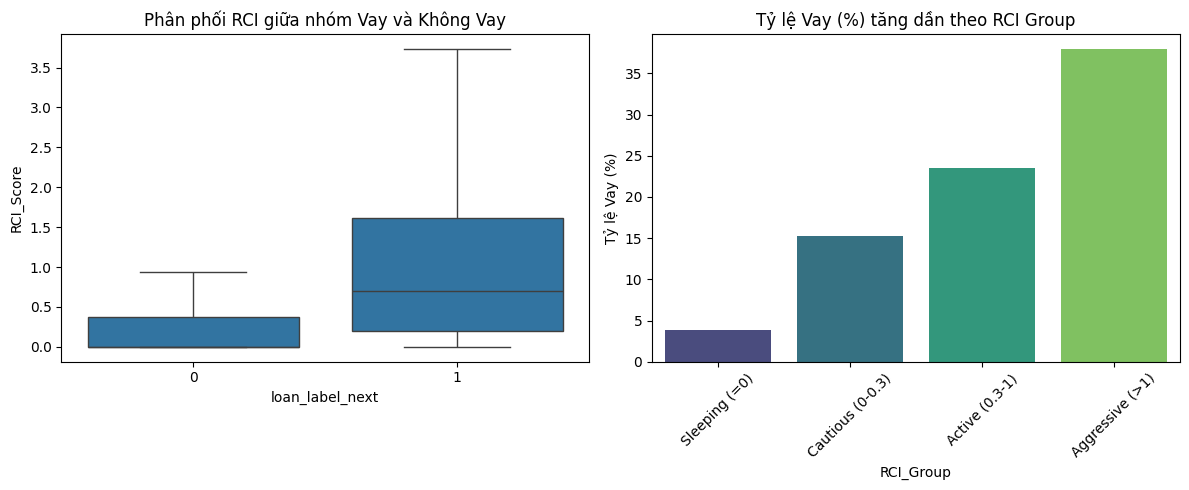

In [599]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- BƯỚC 1: SO SÁNH THỐNG KÊ CƠ BẢN ---
# Xem nhóm vay (1) và không vay (0) có điểm RCI khác biệt thế nào
print("--- Thống kê RCI_Score theo nhóm Loan ---")
print(df.groupby('loan_label_next')['RCI_Score'].describe())

# --- BƯỚC 2: PHÂN TÍCH TỶ LỆ VAY THEO PHÂN KHÚC (BINNING) ---
# Chia RCI thành các nhóm như chúng ta đã định nghĩa
bins = [-0.1, 0.001, 0.3, 1.0, 100]
labels = ['Sleeping (=0)', 'Cautious (0-0.3)', 'Active (0.3-1)', 'Aggressive (>1)']

df['RCI_Group'] = pd.cut(df['RCI_Score'], bins=bins, labels=labels)

# Tính tỷ lệ % khách hàng vay trong từng nhóm
conversion_analysis = df.groupby('RCI_Group')['loan_label_next'].agg(['count', 'mean'])
conversion_analysis.columns = ['Số lượng KH', 'Tỷ lệ Vay (%)']
conversion_analysis['Tỷ lệ Vay (%)'] = conversion_analysis['Tỷ lệ Vay (%)'] * 100

print("\n--- Tỷ lệ khách hàng sẽ vay (Label=1) theo từng nhóm RCI ---")
print(conversion_analysis)

# --- BƯỚC 3: TRỰC QUAN HÓA ---
plt.figure(figsize=(12, 5))

# Biểu đồ 1: Boxplot so sánh phân phối
plt.subplot(1, 2, 1)
sns.boxplot(x='loan_label_next', y='RCI_Score', data=df, showfliers=False) # Ẩn ngoại lai quá xa để dễ nhìn
plt.title('Phân phối RCI giữa nhóm Vay và Không Vay')

# Biểu đồ 2: Barplot tỷ lệ vay
plt.subplot(1, 2, 2)
sns.barplot(x=conversion_analysis.index, y='Tỷ lệ Vay (%)', data=conversion_analysis.reset_index(), palette='viridis')
plt.title('Tỷ lệ Vay (%) tăng dần theo RCI Group')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Số lượng khách VAY bị bỏ sót (False Negatives): 468
Số lượng khách VAY bắt đúng (True Positives): 1364


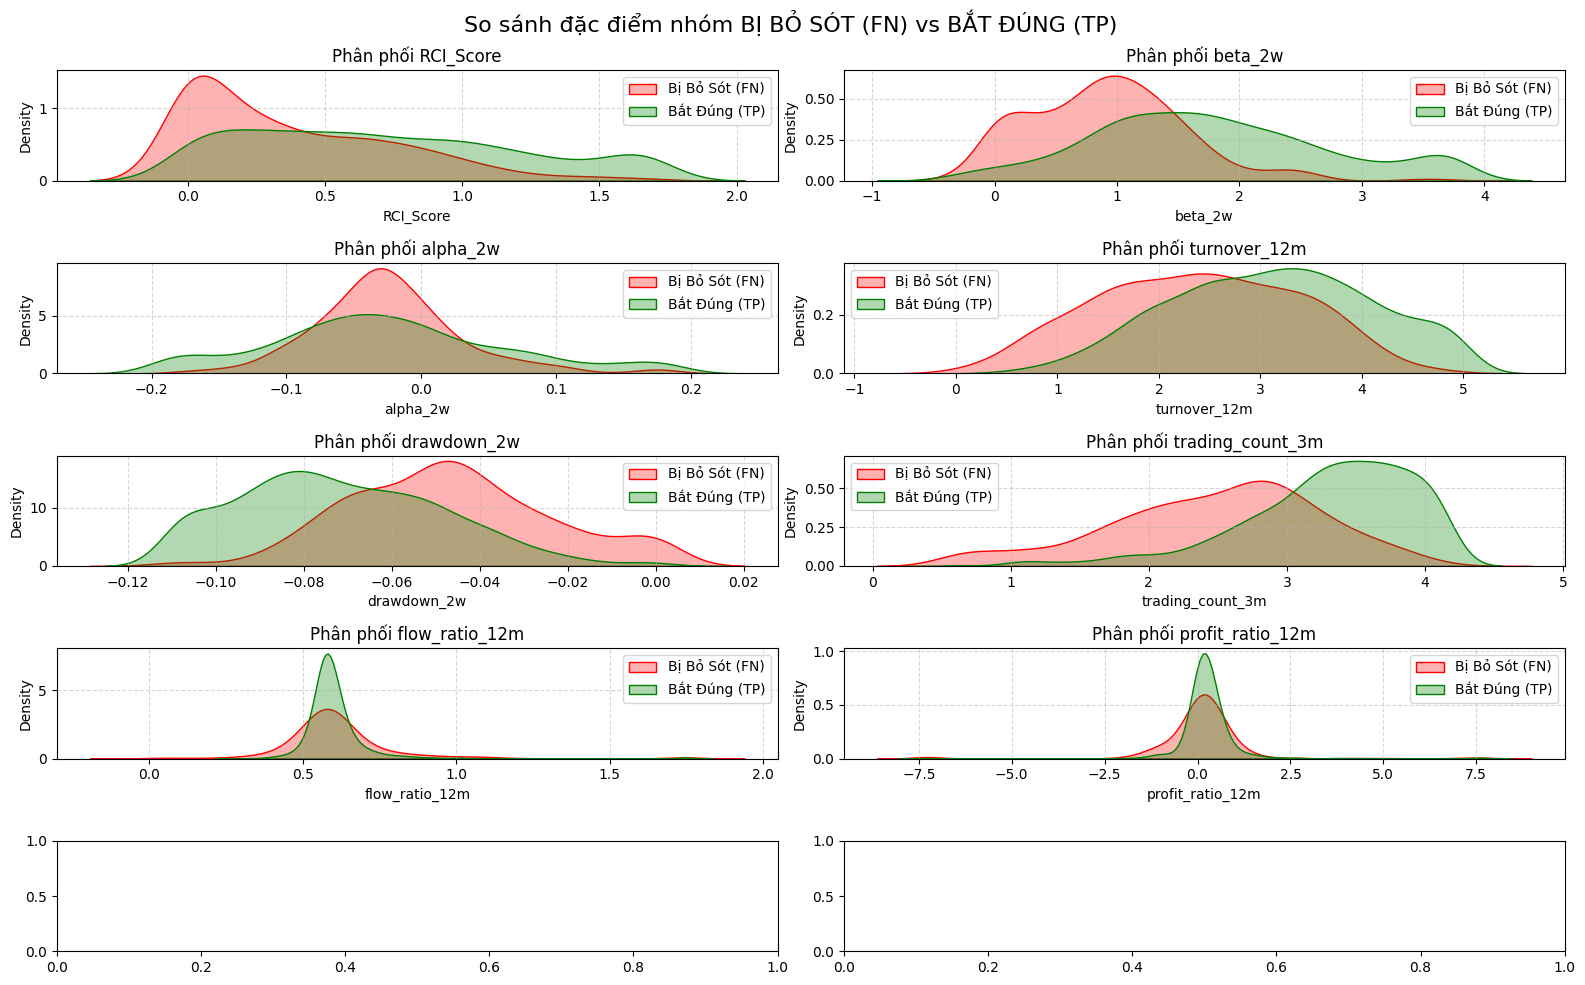


THỐNG KÊ MÔ TẢ (DESCRIBE) CỦA NHÓM BỊ BỎ SÓT (FN)
        RCI_Score     beta_2w    alpha_2w  turnover_12m  drawdown_2w  \
count  468.000000  468.000000  468.000000    468.000000   468.000000   
mean     0.375048    0.913743   -0.024971      2.378483    -0.046651   
std      0.380212    0.639972    0.054759      0.986393     0.023126   
min      0.000000   -0.280576   -0.176934      0.085401    -0.108487   
25%      0.026848    0.415003   -0.057824      1.596262    -0.064349   
50%      0.263365    0.908912   -0.028209      2.405614    -0.047755   
75%      0.621730    1.280066    0.000000      3.148097    -0.032101   
max      1.672303    3.706219    0.177968      4.809888     0.000000   

       trading_count_3m  flow_ratio_12m  profit_ratio_12m  
count        468.000000    4.680000e+02        468.000000  
mean           2.474654    6.247215e-01          0.144116  
std            0.757678    2.218050e-01          1.553295  
min            0.693147    4.846437e-15         -7.269664  


In [600]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 2. TẠO DATAFRAME KẾT QUẢ
# Dự báo trên tập test
y_pred = loaded_model.predict(X_test_scaled)

# Tạo DataFrame chứa Features gốc + Nhãn Thực tế + Nhãn Dự báo
# Lưu ý: X_test cần là DataFrame có tên cột. Nếu X_test của bạn đã bị scale thành numpy array, 
# hãy thay bằng biến DataFrame gốc (ví dụ df_test hoặc X_test ban đầu trước khi scale)
analysis_df = X_test.copy() 
analysis_df['Actual'] = y_test
analysis_df['Predicted'] = y_pred

# 3. LỌC RA CÁC TRƯỜNG HỢP SAI SÓT (False Negatives & False Positives)
# - False Negative (FN): Thực tế Vay (1) - Máy báo Không (0) -> KHÁCH BỊ BỎ SÓT
# - True Positive (TP): Thực tế Vay (1) - Máy báo Vay (1) -> KHÁCH BẮT ĐÚNG
df_fn = analysis_df[(analysis_df['Actual'] == 1) & (analysis_df['Predicted'] == 0)]
df_tp = analysis_df[(analysis_df['Actual'] == 1) & (analysis_df['Predicted'] == 1)]

print(f"Số lượng khách VAY bị bỏ sót (False Negatives): {len(df_fn)}")
print(f"Số lượng khách VAY bắt đúng (True Positives): {len(df_tp)}")

# 4. VẼ BIỂU ĐỒ SO SÁNH: TẠI SAO LẠI BỎ SÓT?
# Chúng ta sẽ so sánh nhóm "Bị bỏ sót" (FN) với nhóm "Bắt đúng" (TP)
# để xem chỉ số của họ khác nhau thế nào.

fig, axes = plt.subplots(5, 2, figsize=(16, 10))
fig.suptitle(f'So sánh đặc điểm nhóm BỊ BỎ SÓT (FN) vs BẮT ĐÚNG (TP)', fontsize=16)

features_to_check = ['RCI_Score', 'beta_2w', 'alpha_2w', 'turnover_12m', 'drawdown_2w', 'trading_count_3m', 'flow_ratio_12m', 'profit_ratio_12m']

for i, feature in enumerate(features_to_check):
    row = i // 2
    col = i % 2
    
    # Vẽ KDE Plot (Mật độ)
    sns.kdeplot(data=df_fn, x=feature, label='Bị Bỏ Sót (FN)', color='red', fill=True, alpha=0.3, ax=axes[row, col])
    sns.kdeplot(data=df_tp, x=feature, label='Bắt Đúng (TP)', color='green', fill=True, alpha=0.3, ax=axes[row, col])
    
    axes[row, col].set_title(f'Phân phối {feature}')
    axes[row, col].legend()
    axes[row, col].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 5. IN RA BẢNG DESCRIBE CỦA NHÓM BỊ BỎ SÓT
print("\n" + "="*50)
print("THỐNG KÊ MÔ TẢ (DESCRIBE) CỦA NHÓM BỊ BỎ SÓT (FN)")
print("="*50)
print(df_fn[features_to_check].describe())

print(df_tp[features_to_check].describe())

print("\n" + "="*50)
print("SO SÁNH TRUNG BÌNH: BỎ SÓT (FN) vs BẮT ĐÚNG (TP)")
print("="*50)
comparison = pd.DataFrame({
    'Bị Bỏ Sót (Mean)': df_fn[features_to_check].mean(),
    'Bắt Đúng (Mean)': df_tp[features_to_check].mean()
})
comparison['Chênh lệch'] = comparison['Bắt Đúng (Mean)'] - comparison['Bị Bỏ Sót (Mean)']
print(comparison)

In [601]:
pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột

In [602]:
fn = X_test.loc[(X_test['proba'] <= 0.4) 
        #    & (X_test['proba'] >= 0.45)
             & (X_test['pred'] == 0) & (X_test['label'] == 1)] # 

In [603]:
tp = X_test.loc[(X_test['proba'] <= 0.55) & (X_test['proba'] >= 0.501) & (X_test['pred'] == 1) & (X_test['label'] == 1)] # 1

In [604]:
tn = X_test.loc[(X_test['proba'] <= 0.4) & (X_test['pred'] == 0) & (X_test['label'] == 0)] 

Số lượng khách VAY bị bỏ sót (False Negatives): 468
Số lượng khách VAY bắt đúng (True Positives): 1364


c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


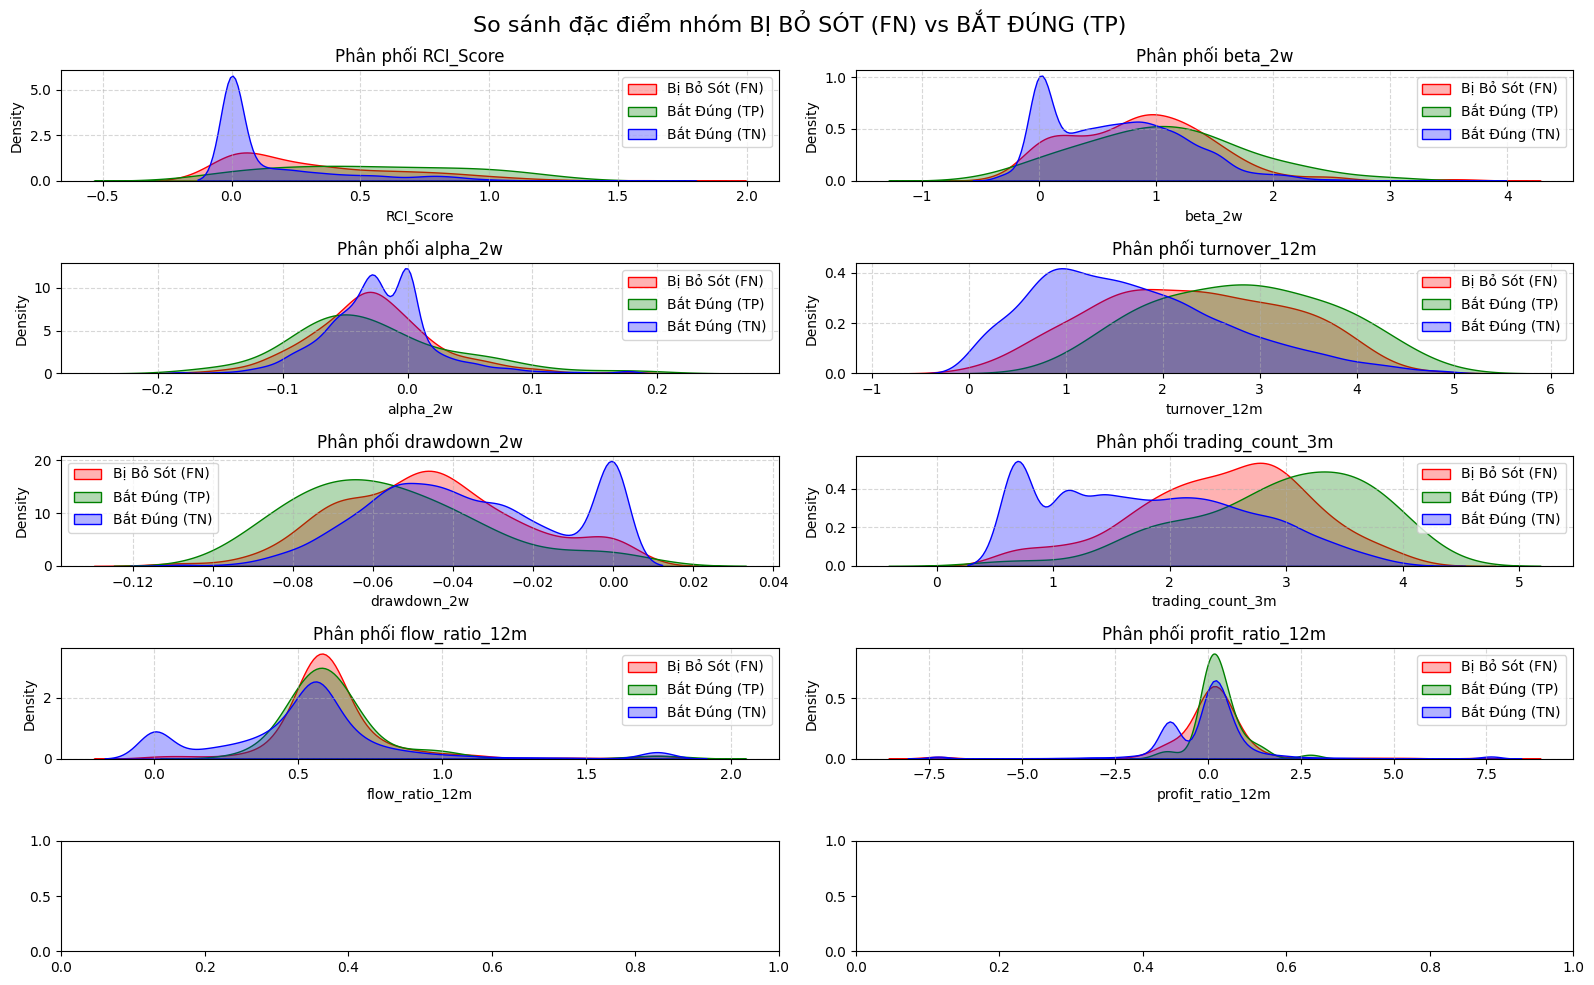


THỐNG KÊ MÔ TẢ (DESCRIBE) CỦA NHÓM BỊ BỎ SÓT (FN)
        RCI_Score     beta_2w    alpha_2w  turnover_12m  drawdown_2w  \
count  468.000000  468.000000  468.000000    468.000000   468.000000   
mean     0.375048    0.913743   -0.024971      2.378483    -0.046651   
std      0.380212    0.639972    0.054759      0.986393     0.023126   
min      0.000000   -0.280576   -0.176934      0.085401    -0.108487   
25%      0.026848    0.415003   -0.057824      1.596262    -0.064349   
50%      0.263365    0.908912   -0.028209      2.405614    -0.047755   
75%      0.621730    1.280066    0.000000      3.148097    -0.032101   
max      1.672303    3.706219    0.177968      4.809888     0.000000   

       trading_count_3m  flow_ratio_12m  profit_ratio_12m  
count        468.000000    4.680000e+02        468.000000  
mean           2.474654    6.247215e-01          0.144116  
std            0.757678    2.218050e-01          1.553295  
min            0.693147    4.846437e-15         -7.269664  


In [605]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 2. TẠO DATAFRAME KẾT QUẢ
# Dự báo trên tập test
y_pred = loaded_model.predict(X_test_scaled)

# Tạo DataFrame chứa Features gốc + Nhãn Thực tế + Nhãn Dự báo
# Lưu ý: X_test cần là DataFrame có tên cột. Nếu X_test của bạn đã bị scale thành numpy array, 
# hãy thay bằng biến DataFrame gốc (ví dụ df_test hoặc X_test ban đầu trước khi scale)
analysis_df = X_test.copy() 
analysis_df['Actual'] = y_test
analysis_df['Predicted'] = y_pred

# 3. LỌC RA CÁC TRƯỜNG HỢP SAI SÓT (False Negatives & False Positives)
# - False Negative (FN): Thực tế Vay (1) - Máy báo Không (0) -> KHÁCH BỊ BỎ SÓT
# - True Positive (TP): Thực tế Vay (1) - Máy báo Vay (1) -> KHÁCH BẮT ĐÚNG
df_fn = analysis_df[(analysis_df['Actual'] == 1) & (analysis_df['Predicted'] == 0)]
df_tp = analysis_df[(analysis_df['Actual'] == 1) & (analysis_df['Predicted'] == 1)]

print(f"Số lượng khách VAY bị bỏ sót (False Negatives): {len(df_fn)}")
print(f"Số lượng khách VAY bắt đúng (True Positives): {len(df_tp)}")

# 4. VẼ BIỂU ĐỒ SO SÁNH: TẠI SAO LẠI BỎ SÓT?
# Chúng ta sẽ so sánh nhóm "Bị bỏ sót" (FN) với nhóm "Bắt đúng" (TP)
# để xem chỉ số của họ khác nhau thế nào.

fig, axes = plt.subplots(5, 2, figsize=(16, 10))
fig.suptitle(f'So sánh đặc điểm nhóm BỊ BỎ SÓT (FN) vs BẮT ĐÚNG (TP)', fontsize=16)

features_to_check = ['RCI_Score', 'beta_2w', 'alpha_2w', 'turnover_12m', 'drawdown_2w', 'trading_count_3m', 'flow_ratio_12m', 'profit_ratio_12m']

for i, feature in enumerate(features_to_check):
    row = i // 2
    col = i % 2
    
    # Vẽ KDE Plot (Mật độ)
    sns.kdeplot(data=fn, x=feature, label='Bị Bỏ Sót (FN)', color='red', fill=True, alpha=0.3, ax=axes[row, col])
    sns.kdeplot(data=tp, x=feature, label='Bắt Đúng (TP)', color='green', fill=True, alpha=0.3, ax=axes[row, col])
    sns.kdeplot(data=tn, x=feature, label='Bắt Đúng (TN)', color='blue', fill=True, alpha=0.3, ax=axes[row, col])

    axes[row, col].set_title(f'Phân phối {feature}')
    axes[row, col].legend()
    axes[row, col].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 5. IN RA BẢNG DESCRIBE CỦA NHÓM BỊ BỎ SÓT
print("\n" + "="*50)
print("THỐNG KÊ MÔ TẢ (DESCRIBE) CỦA NHÓM BỊ BỎ SÓT (FN)")
print("="*50)
print(df_fn[features_to_check].describe())

print(df_tp[features_to_check].describe())

print("\n" + "="*50)
print("SO SÁNH TRUNG BÌNH: BỎ SÓT (FN) vs BẮT ĐÚNG (TP)")
print("="*50)
comparison = pd.DataFrame({
    'Bị Bỏ Sót (Mean)': df_fn[features_to_check].mean(),
    'Bắt Đúng (Mean)': df_tp[features_to_check].mean()
})
comparison['Chênh lệch'] = comparison['Bắt Đúng (Mean)'] - comparison['Bị Bỏ Sót (Mean)']
print(comparison)